# ILI Multi-Sheet Exploratory Analysis Notebook
This notebook performs structured exploratory analysis on a multi-sheet Excel file containing ILI inspection runs from different years. It focuses on schema comparison, data quality, feature drift, clock normalization, reference alignment insight, and a naive cross-year matching sanity check.

Steps overview:
1. Setup & Imports
2. Load Multi-Sheet Data
3. Schema Comparison Across Years
4. Canonical Feature Identification
5. Data Type, Unit & Format Inspection
6. Missing Value & Data Quality Analysis
7. Feature Drift & Evolution Analysis
8. Clock Position Normalization Preview
9. Reference Alignment Insight
10. Initial Cross-Year Matching Sanity Check
11. Save Analysis Outputs
\nNote: If the Excel file is not available initially, the notebook will skip computations gracefully and still run top-to-bottom.

In [37]:
# Setup & Imports
import os
import json
import math
import warnings
from typing import Optional, Dict, List, Tuple

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 220)
pd.set_option('display.max_colwidth', 200)
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['font.size'] = 10

In [38]:
# Utility functions and configuration
excel_path = os.environ.get('ILI_EXCEL_PATH', '/Users/satvikaakati/Desktop/Hack/ILIDataV2.xlsx')  # Set your path or use env var
output_dir = os.environ.get('ILI_OUTPUT_DIR', './outputs')
os.makedirs(output_dir, exist_ok=True)

SHEETS = {
    'summary': 'summary',
    '2007': '2007',
    '2015': '2015',
    '2022': '2022',
}

# Expanded synonyms to capture vendor-specific labels and newline variants
DISTANCE_SYNONYMS = [
    'distance_m', 'distance', 'odometer', 'relative_position', 'pipe_position', 'axial_position',
    'log dist. [ft]', 'log dist', 'distance [ft]', 'distance [m]', 'distance (ft)', 'distance (m)',
    'distance to u/s gw', 'distance to u/s gw [ft]', 'distance to d/s gw [ft]', 'to u/s w. [ft]',
    'distance to u/s gw \n[ft]', 'distance to d/s gw \n[ft]',
    'ili wheel count \n[ft.]', 'ili wheel count [ft.]', 'ili wheel count', 'wheel count'
]
CLOCK_SYNONYMS = [
    'clock_deg', 'clock', 'clock_position', 'clock_angle', 'clock_pos', "o'clock", "O'clock", "O'clock\n[hh:mm]"
]
DEPTH_SYNONYMS = [
    'depth_percent', 'depth_pct', 'depth', 'max_depth_pct', 'depth [%]', 'Depth [%]', 'Metal Loss Depth \n[%]'
]
LENGTH_SYNONYMS = [
    'length', 'length_mm', 'feature_length', 'length [in]', 'Length [in]'
]
WIDTH_SYNONYMS = [
    'width', 'width_mm', 'feature_width', 'width [in]', 'Width [in]'
]
FEATURE_TYPE_SYNONYMS = [
    'feature_type', 'type', 'classification', 'anomaly_type', 'Seam Type', 'Dimension Classification', 'event', 'Event',
    'Event Description', 'Event Type', 'Event\nDescription'
]

def find_col(df: pd.DataFrame, candidates: List[str]) -> Optional[str]:
    """Return the first matching column name in df from candidates (case-insensitive), else None."""
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        key = cand.lower()
        if key in cols_lower:
            return cols_lower[key]
    # try substring contains logic
    for c in df.columns:
        cl = c.lower()
        for cand in candidates:
            if cand.lower() in cl:
                return c
    return None

def parse_clock_to_deg(series: pd.Series) -> pd.Series:
    """Normalize clock positions to degrees [0, 360). Handles numeric (0-12, 0-6, 0-360), time-like, and common string formats."""
    import datetime as _dt
    def to_deg(val):
        if pd.isna(val):
            return np.nan
        # Handle time-like objects (datetime.time, pandas.Timestamp)
        try:
            if isinstance(val, _dt.time):
                h = val.hour if val.hour is not None else np.nan
                return (float(h) * 30) % 360 if not pd.isna(h) else np.nan
            if isinstance(val, pd.Timestamp):
                h = val.hour
                return (float(h) * 30) % 360
        except Exception:
            pass
        # Strings like '3:00', '3 o\'clock', '270°', '270 deg'
        if isinstance(val, str):
            s = val.strip().lower().replace("o'clock",'').replace('deg','').replace('°','').replace(':',' ').replace(',', ' ')
            parts = s.split()
            num = None
            for p in parts:
                try:
                    num = float(p)
                    break
                except Exception:
                    continue
            if num is None:
                return np.nan
            v = num
            # Heuristics: <=6 -> *60, <=12 -> *30, else degrees
            if 0 <= v <= 6:
                return (v * 60) % 360
            if 0 <= v <= 12:
                return (v * 30) % 360
            return v % 360
        # Numeric scale detection
        try:
            v = float(val)
        except Exception:
            # Fallback: try string conversion
            try:
                return to_deg(str(val))
            except Exception:
                return np.nan
        if v < 0:
            v = v % 360
        if 0 <= v <= 6:
            return (v * 60) % 360
        if 0 <= v <= 12:
            return (v * 30) % 360
        return v % 360
    try:
        return series.apply(to_deg)
    except Exception:
        return pd.Series([np.nan]*len(series), index=series.index)

def safe_excel_file(path: str) -> Optional[pd.ExcelFile]:
    try:
        return pd.ExcelFile(path)
    except Exception as e:
        warnings.warn(f"Excel file not found or unreadable at '{path}'. Set excel_path to your file. Error: {e}")
        return None

def get_key_cols(df: pd.DataFrame) -> Dict[str, Optional[str]]:
    return {
        'distance': find_col(df, DISTANCE_SYNONYMS),
        'clock': find_col(df, CLOCK_SYNONYMS),
        'depth_pct': find_col(df, DEPTH_SYNONYMS),
        'length': find_col(df, LENGTH_SYNONYMS),
        'width': find_col(df, WIDTH_SYNONYMS),
        'feature_type': find_col(df, FEATURE_TYPE_SYNONYMS),
    }

def is_empty_df(df: Optional[pd.DataFrame]) -> bool:
    return (df is None) or (len(df) == 0)

def print_head(df: pd.DataFrame, name: str, n: int = 5):
    try:
        display(df.head(n))
    except Exception:
        print(f"[INFO] Unable to display head for {name}.")

In [39]:
# Load Multi-Sheet Data
summary_df = None
df_2007 = None
df_2015 = None
df_2022 = None

xf = safe_excel_file(excel_path)
if xf is not None:
    # Parse sheets; fall back gracefully if a sheet is missing
    try:
        summary_df = xf.parse(SHEETS['summary'])
    except Exception:
        warnings.warn("Missing 'summary' sheet; proceeding without metadata.")
        summary_df = pd.DataFrame()
    for yr in ['2007','2015','2022']:
        try:
            df = xf.parse(SHEETS[yr])
        except Exception:
            warnings.warn(f"Missing '{yr}' sheet; creating empty DataFrame.")
            df = pd.DataFrame()
        if yr == '2007':
            df_2007 = df
        elif yr == '2015':
            df_2015 = df
        elif yr == '2022':
            df_2022 = df
else:
    # Create empty frames to allow notebook to run
    summary_df = pd.DataFrame()
    df_2007 = pd.DataFrame()
    df_2015 = pd.DataFrame()
    df_2022 = pd.DataFrame()

def row_count(df: pd.DataFrame) -> int:
    try:
        return len(df)
    except Exception:
        return 0

print("Row counts:")
print({
    'summary': row_count(summary_df),
    '2007': row_count(df_2007),
    '2015': row_count(df_2015),
    '2022': row_count(df_2022)
})

print("\nFirst 5 rows - 2007:")
print_head(df_2007, '2007')
print("\nFirst 5 rows - 2015:")
print_head(df_2015, '2015')
print("\nFirst 5 rows - 2022:")
print_head(df_2022, '2022')

/var/folders/t_/xvcw4r_j2vjg8215r09c65r40000gn/T/ipykernel_39188/230834891.py:13: UserWarning:

Missing 'summary' sheet; proceeding without metadata.



Row counts:
{'summary': 0, '2007': 2446, '2015': 3678, '2022': 5233}

First 5 rows - 2007:


,J. no.,J. len [ft],t [in],to u/s w. [ft],log dist. [ft],Height [ft],event,depth [%],ID Reduction [%],length [in],width [in],P2 Burst / MOP,o'clock,internal,comment
0,NaN,NaN,0.449,NaN,-27.82,803.6748,Area Start Launcher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,-19.48,803.6644,Support,NaN,NaN,NaN,NaN,NaN,06:00:00,NaN,NaN
2,NaN,NaN,NaN,NaN,-15.78,803.6598,Support,NaN,NaN,NaN,NaN,NaN,06:00:00,NaN,NaN
3,NaN,NaN,NaN,NaN,-12.21,803.6553,Tap,NaN,NaN,NaN,NaN,NaN,06:00:00,NaN,NaN
4,NaN,NaN,NaN,NaN,-6.49,803.6481,Support,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strap



First 5 rows - 2015:


,J. no.,J. len [ft],Wt [in],to u/s w. [ft],to d/s w. [ft],Log Dist. [ft],Event Description,ID/OD,Depth [%],Depth [in],OD Reduction [%],OD Reduction [in],Length [in],Width [in],O'clock,Comments,Anomalies per Joint,Tool Velocity [ft/s],Elevation [ft],Seam Position (TFI),Tool (TFI),Seam Anomaly (TFI),MOP [PSI],SMYS [PSI],Seam Type,Pdesign [PSI],B31G Psafe [PSI],B31G Pburst [PSI],Mod B31G Psafe [PSI],Mod B31G Pburst [PSI],Effective Area Psafe [PSI],Effective Area Pburst [PSI],ERF,RPR
0,NaN,NaN,NaN,NaN,NaN,-14.60,Area Start Launcher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,-1.39,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,NaN,NaN,NaN,233.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,0.00,Valve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,1.40,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,NaN,NaN,NaN,233.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,8.16,Tee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,NaN,NaN,NaN,233.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



First 5 rows - 2022:


,Joint Number,Joint Length [ft],WT [in],Distance to U/S GW \n[ft],Distance to D/S GW \n[ft],ILI Wheel Count \n[ft.],Event Description,ID/OD,Metal Loss Depth \n[%],Metal Loss Depth \n[in],Metal Loss Depth + Tolerance\n[%],Dimension Classification,Metal Loss Depth Tolerance [%] \n(includes seamless and HAZ and modified specs),Dent Depth\n [%],Dent Depth\n [in],Is any part of the dent affecting the top of the pipe? \n[Y/N],Length [in],Width [in],O'clock\n[hh:mm],Comments,Anomalies per Joint,Was anomaly sizing reviewed by analyst? \n[Y/N],Was anomaly sizing/dimensions manually changed? \n[Y/N],Magnetization Level \n[kA/m] for MFL survey \nor \nActual WT [in] for UT Survey,Elevation [ft],Seam Position\n[hh:mm],Distance To Seam Weld \n[in],Tool,Evaluation Pressure [PSI],SMYS [PSI],Pipe Type,Pipe Diameter (O.D.) \n[in.],Pdesign [PSI],Mod B31G Psafe \n[PSI],Mod B31G Pburst [PSI],Mod B31G Psafe Pressure with Tolerance\n[PSI],Mod B31G Pburst Pressure with Tolerance\n[PSI],Effective Area Psafe [PSI],Effective Area Pburst [PSI],ERF,RPR,Length Tolerance [in],Width Tolerance [in]
0,5,4.528,0.344,NaN,NaN,-2.500,Girth Weld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIRTH WELD - ERW START,0,NaN,NaN,5.97,NaN,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5,4.528,0.344,NaN,NaN,-1.565,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,1.5 IN OFFTAKE-WELDOLET,0,NaN,NaN,5.97,NaN,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,4.528,0.344,NaN,NaN,-0.003,Valve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MOV-0109C LAUNCHER,0,NaN,NaN,5.97,233.47,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,4.528,0.344,NaN,NaN,1.243,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,1.5 IN OFFTAKE-WELDOLET,0,NaN,NaN,5.97,233.45,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,4.551,0.344,NaN,NaN,2.028,Girth Weld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIRTH WELD,0,NaN,NaN,5.97,NaN,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Schema Comparison Across Years
The goal here is to understand column overlap and differences across the 2007, 2015, and 2022 inspection runs. We’ll list columns per year, compute the common set, and identify year-specific columns. Results will also be saved to CSV for downstream use.

In [40]:
# Compute and display schema comparison
def cols(df: pd.DataFrame) -> List[str]:
    return list(df.columns) if df is not None else []

cols_2007 = cols(df_2007)
cols_2015 = cols(df_2015)
cols_2022 = cols(df_2022)

set_2007 = set(cols_2007)
set_2015 = set(cols_2015)
set_2022 = set(cols_2022)

common_all = sorted(list(set_2007 & set_2015 & set_2022))
unique_2007 = sorted(list(set_2007 - (set_2015 | set_2022)))
unique_2015 = sorted(list(set_2015 - (set_2007 | set_2022)))
unique_2022 = sorted(list(set_2022 - (set_2007 | set_2015)))

df_common = pd.DataFrame({'common_columns': common_all})
df_unique = pd.DataFrame({
    'unique_2007': pd.Series(unique_2007),
    'unique_2015': pd.Series(unique_2015),
    'unique_2022': pd.Series(unique_2022),
})

print("Columns in 2007:")
display(pd.DataFrame({'2007_columns': cols_2007}))
print("\nColumns in 2015:")
display(pd.DataFrame({'2015_columns': cols_2015}))
print("\nColumns in 2022:")
display(pd.DataFrame({'2022_columns': cols_2022}))
print("\nCommon to all years:")
display(df_common)
print("\nUnique per year:")
display(df_unique)

# Save outputs
df_common.to_csv(os.path.join(output_dir, 'schema_common_columns.csv'), index=False)
df_unique.to_csv(os.path.join(output_dir, 'schema_unique_columns_by_year.csv'), index=False)

Columns in 2007:


,2007_columns
0,J. no.
1,J. len [ft]
2,t [in]
3,to u/s w. [ft]
4,log dist. [ft]
5,Height [ft]
6,event
7,depth [%]
8,ID Reduction [%]
9,length [in]



Columns in 2015:


,2015_columns
0,J. no.
1,J. len [ft]
2,Wt [in]
3,to u/s w. [ft]
4,to d/s w. [ft]
5,Log Dist. [ft]
6,Event Description
7,ID/OD
8,Depth [%]
9,Depth [in]



Columns in 2022:


,2022_columns
0,Joint Number
1,Joint Length [ft]
2,WT [in]
3,Distance to U/S GW \n[ft]
4,Distance to D/S GW \n[ft]
5,ILI Wheel Count \n[ft.]
6,Event Description
7,ID/OD
8,Metal Loss Depth \n[%]
9,Metal Loss Depth \n[in]



Common to all years:


,common_columns



Unique per year:


,unique_2007,unique_2015,unique_2022
0,Height [ft],B31G Pburst [PSI],Dent Depth\n [%]
1,ID Reduction [%],B31G Psafe [PSI],Dent Depth\n [in]
2,P2 Burst / MOP,Depth [%],Dimension Classification
3,comment,Depth [in],Distance To Seam Weld \n[in]
4,depth [%],Log Dist. [ft],Distance to D/S GW \n[ft]
5,event,MOP [PSI],Distance to U/S GW \n[ft]
6,internal,Mod B31G Psafe [PSI],Evaluation Pressure [PSI]
7,length [in],O'clock,ILI Wheel Count \n[ft.]
8,log dist. [ft],OD Reduction [%],Is any part of the dent affecting the top of the pipe? \n[Y/N]
9,o'clock,OD Reduction [in],Joint Length [ft]


# Canonical Feature Identification
We propose a canonical schema that captures core fields used for alignment and growth analysis. We’ll mark which fields appear across all years (required) and which are optional/year-specific. Where available, we map each year’s column name to the canonical field.

In [41]:
# Build canonical schema table
def canonical_schema(df_by_year: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    rows = []
    canonical_fields = [
        ('distance_m', 'location', True),
        ('clock_deg', 'location', True),
        ('depth_percent', 'geometry', True),
        ('length_mm', 'geometry', False),
        ('width_mm', 'geometry', False),
        ('feature_type', 'classification', True),
    ]
    for cname, role, required_default in canonical_fields:
        mapping = {}
        notes = []
        for yr, df in df_by_year.items():
            col = None
            if cname == 'distance_m':
                col = find_col(df, DISTANCE_SYNONYMS)
            elif cname == 'clock_deg':
                col = find_col(df, CLOCK_SYNONYMS)
            elif cname == 'depth_percent':
                col = find_col(df, DEPTH_SYNONYMS)
            elif cname == 'length_mm':
                col = find_col(df, LENGTH_SYNONYMS)
            elif cname == 'width_mm':
                col = find_col(df, WIDTH_SYNONYMS)
            elif cname == 'feature_type':
                col = find_col(df, FEATURE_TYPE_SYNONYMS)
            mapping[yr] = col
            if col is None:
                notes.append(f"missing in {yr}")
        required = required_default and all(mapping[yr] is not None for yr in df_by_year.keys())
        rows.append({
            'canonical_field': cname,
            'role': role,
            'required': required,
            '2007_col': mapping.get('2007'),
            '2015_col': mapping.get('2015'),
            '2022_col': mapping.get('2022'),
            'notes': '; '.join(notes) if notes else ''
        })
    return pd.DataFrame(rows)

schema_tbl = canonical_schema({'2007': df_2007, '2015': df_2015, '2022': df_2022})
display(schema_tbl)
schema_tbl.to_csv(os.path.join(output_dir, 'canonical_schema_mapping.csv'), index=False)

,canonical_field,role,required,2007_col,2015_col,2022_col,notes
0,distance_m,location,True,log dist. [ft],Log Dist. [ft],Distance to U/S GW \n[ft],
1,clock_deg,location,True,o'clock,O'clock,O'clock\n[hh:mm],
2,depth_percent,geometry,True,depth [%],Depth [%],Metal Loss Depth \n[%],
3,length_mm,geometry,False,length [in],Length [in],Length [in],
4,width_mm,geometry,False,width [in],Width [in],Width [in],
5,feature_type,classification,True,event,Seam Type,Dimension Classification,


# Data Type, Unit & Format Inspection
We inspect key fields for data types and ranges across years to catch unit or format inconsistencies (e.g., clock in hours vs degrees, distance scaling, percent vs fraction).

In [42]:
# Inspect dtypes and ranges for key fields
def field_stats(df: pd.DataFrame, yr: str) -> pd.DataFrame:
    cols_map = get_key_cols(df)
    rows = []
    for field_key, col in cols_map.items():
        if col is None or col not in df.columns:
            rows.append({'year': yr, 'field': field_key, 'column': None, 'dtype': None, 'min': None, 'max': None, 'nonnull': 0, 'missing_pct': 100.0, 'notes': 'missing'})
            continue
        s = df[col]
        nonnull = s.notna().sum()
        missing_pct = 100.0 * (len(s) - nonnull) / max(len(s), 1)
        dtype = str(s.dtype)
        min_val = pd.to_numeric(s, errors='coerce').min() if s.dtype.kind in 'biufc' or s.dtype == 'object' else None
        max_val = pd.to_numeric(s, errors='coerce').max() if s.dtype.kind in 'biufc' or s.dtype == 'object' else None
        notes = ''
        if field_key == 'clock':
            # heuristic: clock in hours (<=12) or radians (~<=6) or degrees (<=360)
            try:
                if max_val is not None:
                    if max_val <= 6:
                        notes = 'clock may be radians or 0-6 scale'
                    elif max_val <= 12:
                        notes = 'clock may be hours (x30 deg)'
                    elif max_val <= 360:
                        notes = 'clock likely degrees'
            except Exception:
                pass
        if field_key == 'depth_pct':
            # depth percent vs fraction
            try:
                if max_val is not None and max_val <= 1:
                    notes = 'depth may be fraction (x100 to percent)'
            except Exception:
                pass
        rows.append({'year': yr, 'field': field_key, 'column': col, 'dtype': dtype, 'min': min_val, 'max': max_val, 'nonnull': nonnull, 'missing_pct': round(missing_pct, 2), 'notes': notes})
    return pd.DataFrame(rows)

stats_frames = []
for yr, df in [('2007', df_2007), ('2015', df_2015), ('2022', df_2022)]:
    stats_frames.append(field_stats(df, yr))
stats_tbl = pd.concat(stats_frames, ignore_index=True)
display(stats_tbl)
stats_tbl.to_csv(os.path.join(output_dir, 'key_field_dtype_and_range_by_year.csv'), index=False)

,year,field,column,dtype,min,max,nonnull,missing_pct,notes
0,2007,distance,log dist. [ft],float64,-27.82,57266.640,2446,0.00,
1,2007,clock,o'clock,object,NaN,NaN,738,69.83,
2,2007,depth_pct,depth [%],float64,10.00,67.000,711,70.93,
3,2007,length,length [in],float64,0.35,44.240,711,70.93,
4,2007,width,width [in],float64,0.55,42.810,711,70.93,
5,2007,feature_type,event,str,NaN,NaN,2446,0.00,
6,2015,distance,Log Dist. [ft],float64,-14.60,57340.000,3678,0.00,
7,2015,clock,O'clock,object,NaN,NaN,1894,48.50,
8,2015,depth_pct,Depth [%],float64,10.00,85.000,1768,51.93,
9,2015,length,Length [in],float64,0.32,27.540,1774,51.77,


# Missing Value & Data Quality Analysis
We compute missing percentages per column for each year, highlight columns with >20% missing, and note fields absent in specific years.

In [43]:
# Compute missing value summaries
def missing_summary(df: pd.DataFrame, yr: str) -> pd.DataFrame:
    if df is None or len(df) == 0:
        return pd.DataFrame({'year': [yr], 'column': ['<empty>'], 'missing_pct': [100.0]})
    ms = df.isna().mean().mul(100).round(2)
    return pd.DataFrame({'year': yr, 'column': ms.index, 'missing_pct': ms.values})

miss_frames = [missing_summary(df_2007, '2007'), missing_summary(df_2015, '2015'), missing_summary(df_2022, '2022')]
miss_tbl = pd.concat(miss_frames, ignore_index=True)
display(miss_tbl)

high_missing = miss_tbl[miss_tbl['missing_pct'] > 20]
print("\nColumns with >20% missing values:")
display(high_missing)

# Save outputs
miss_tbl.to_csv(os.path.join(output_dir, 'missing_value_summary_by_year.csv'), index=False)
high_missing.to_csv(os.path.join(output_dir, 'high_missing_columns_by_year.csv'), index=False)

,year,column,missing_pct
0,2007,J. no.,34.14
1,2007,J. len [ft],34.18
2,2007,t [in],4.99
3,2007,to u/s w. [ft],70.93
4,2007,log dist. [ft],0.00
...,...,...,...
87,2022,Effective Area Pburst [PSI],49.63
88,2022,ERF,49.63
89,2022,RPR,49.63
90,2022,Length Tolerance [in],51.02



Columns with >20% missing values:


,year,column,missing_pct
0,2007,J. no.,34.14
1,2007,J. len [ft],34.18
3,2007,to u/s w. [ft],70.93
7,2007,depth [%],70.93
8,2007,ID Reduction [%],100.00
...,...,...,...
87,2022,Effective Area Pburst [PSI],49.63
88,2022,ERF,49.63
89,2022,RPR,49.63
90,2022,Length Tolerance [in],51.02


# Feature Drift & Evolution Analysis
We compare distributions for distance, depth_percent, length, and width across years, and analyze changes in feature_type composition (newly appearing or disappearing types).

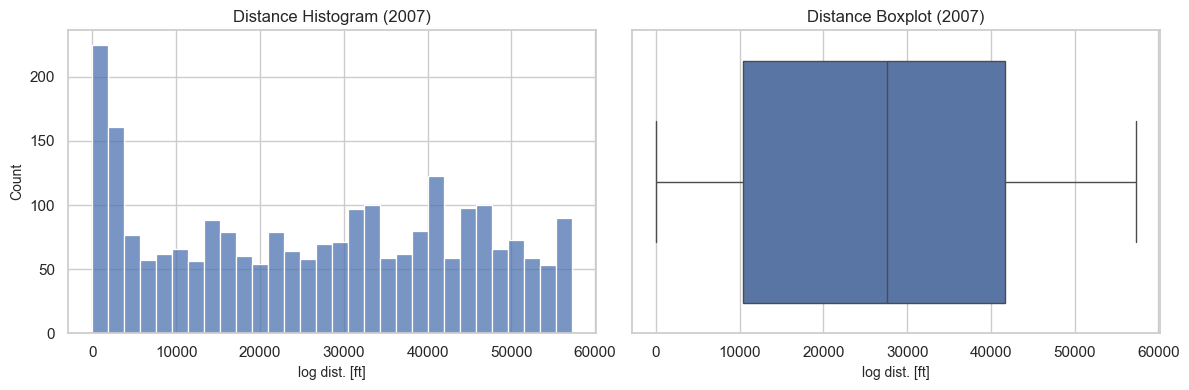

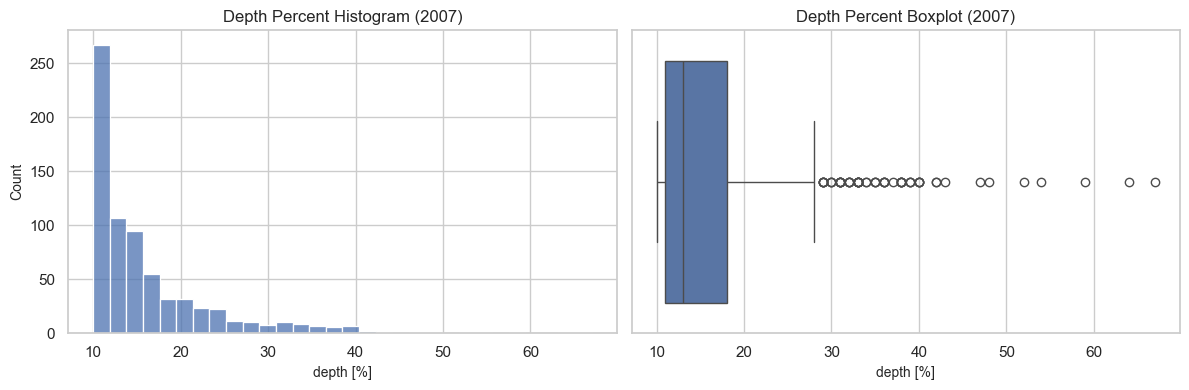

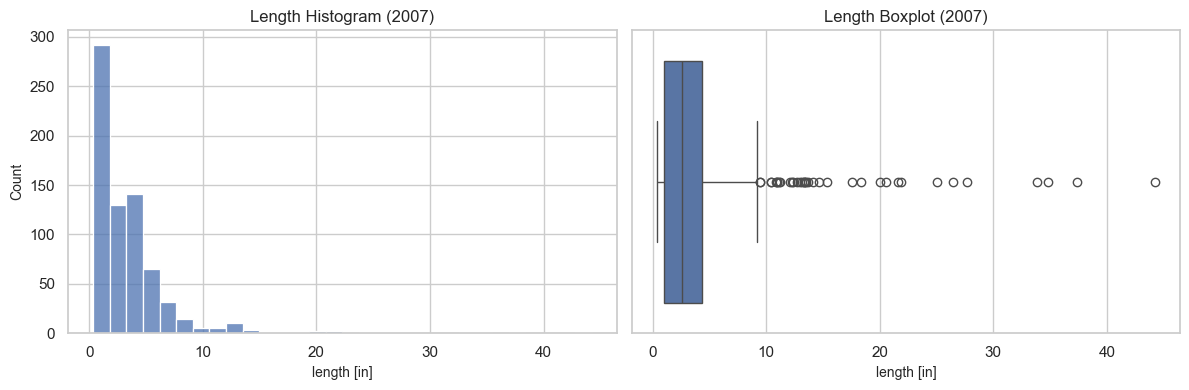

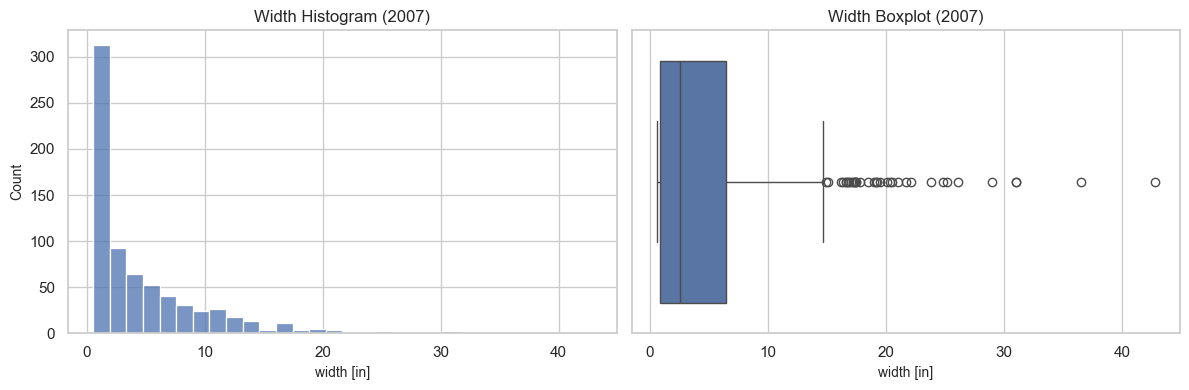

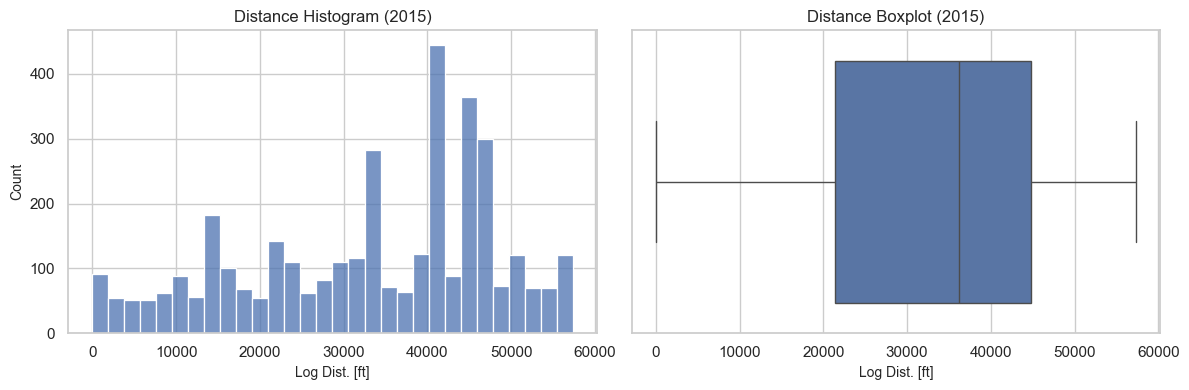

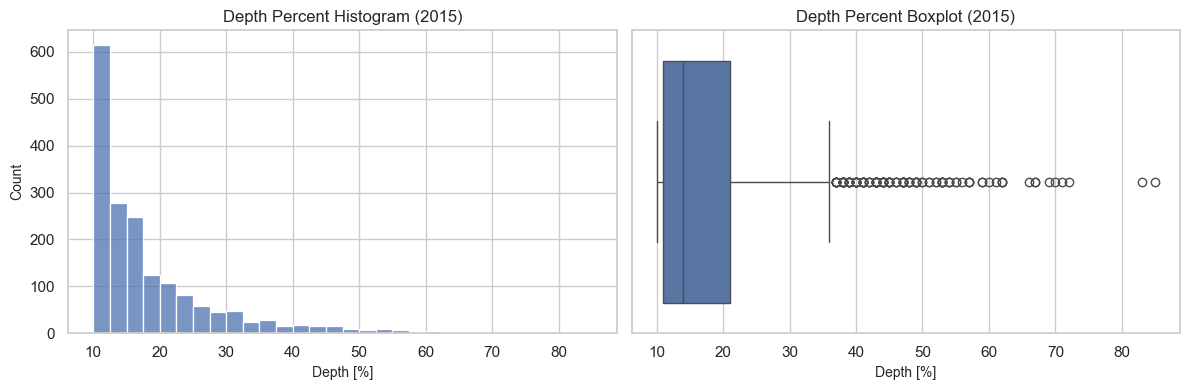

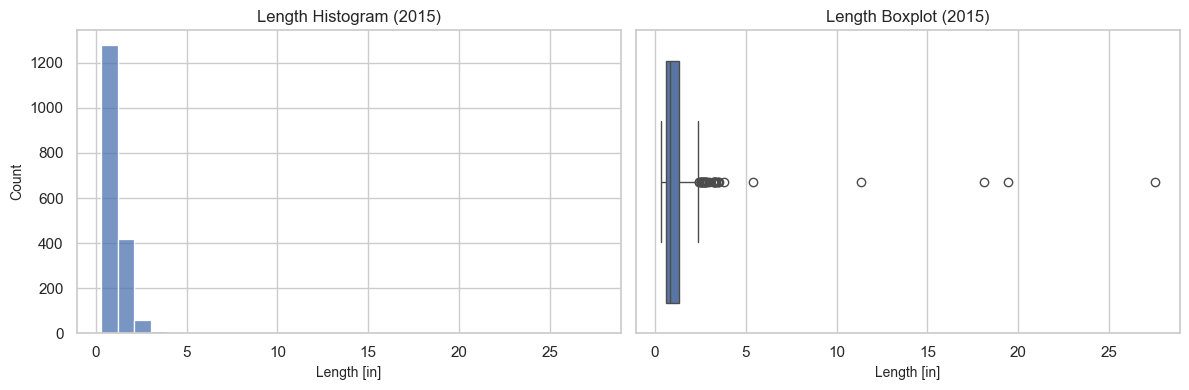

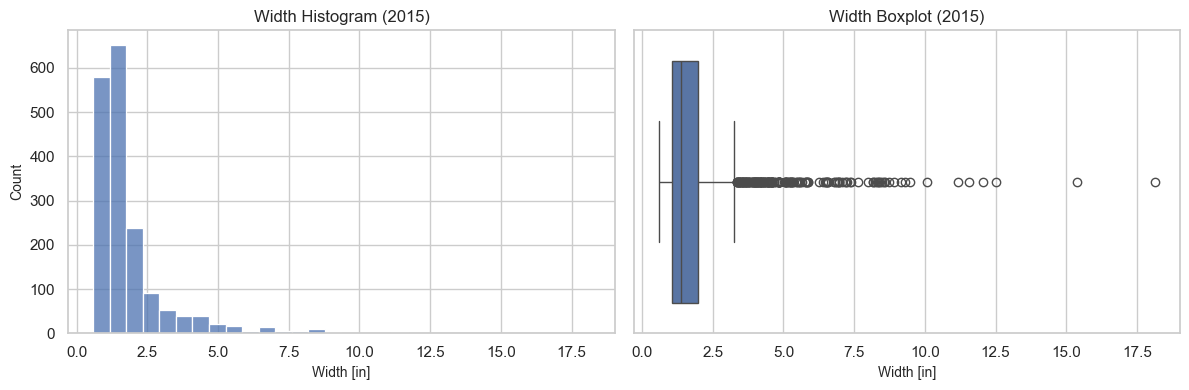

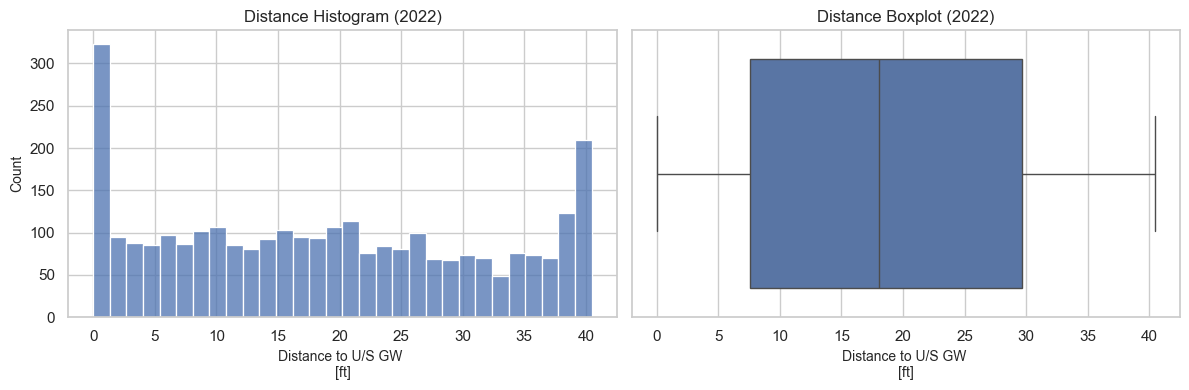

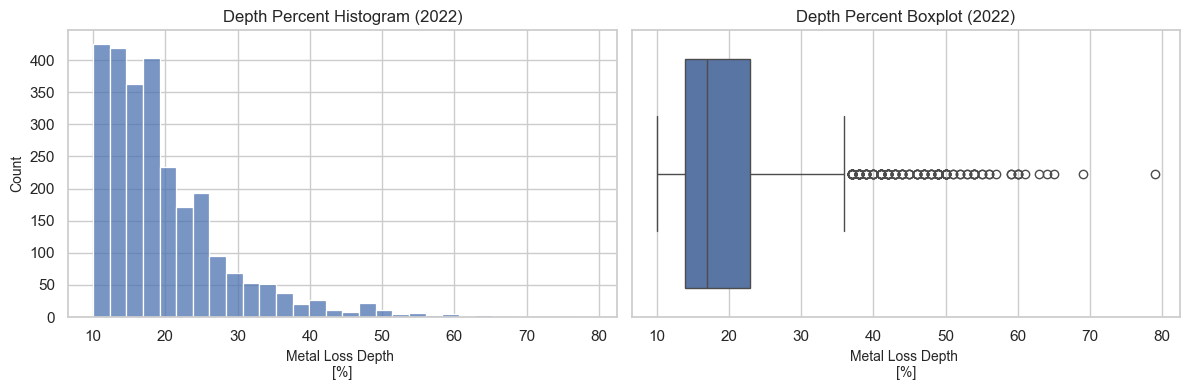

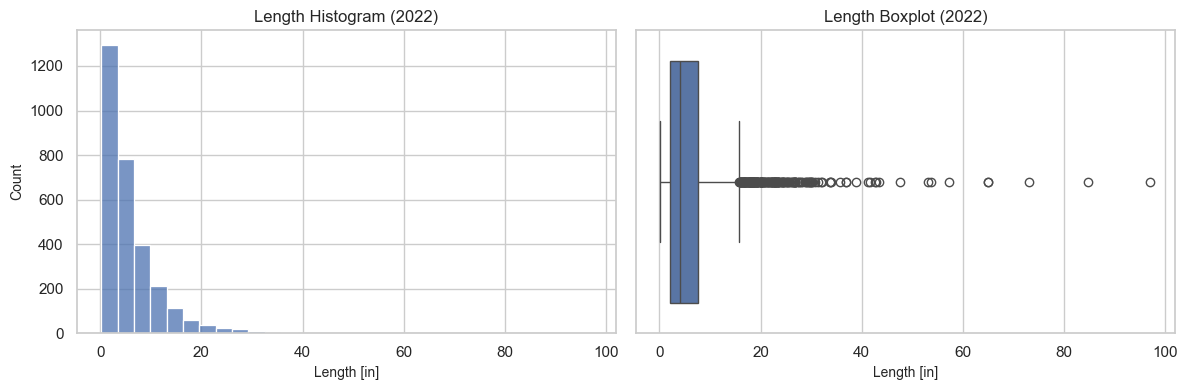

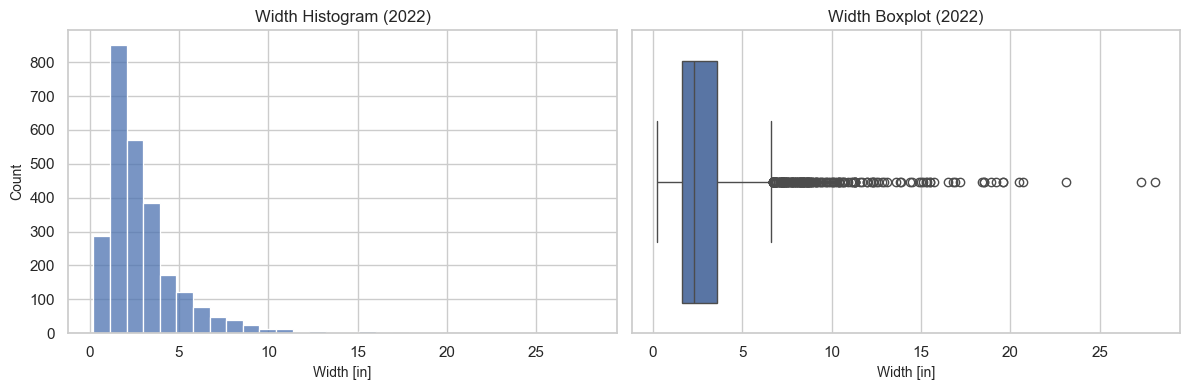

,feature_type,count_2007,count_2015,count_2022
0,<NA>,0,3678,2597
1,AXGR,0,0,101
2,AXSL,0,0,14
3,Above Ground Marker,12,0,0
4,Area End Installation,2,0,0
5,Area End Launcher,1,0,0
6,Area End Receiver,1,0,0
7,Area Start Installation,2,0,0
8,Area Start Launcher,1,0,0
9,Area Start Receiver,1,0,0


New in 2015 (vs 2007): ['<NA>']
New in 2022 (vs 2015): ['AXGR', 'AXSL', 'CIGR', 'CISL', 'GENE', 'PITT']
Disappeared by 2015 (vs 2007): ['Above Ground Marker', 'Area End Installation', 'Area End Launcher', 'Area End Receiver', 'Area Start Installation', 'Area Start Launcher', 'Area Start Receiver', 'Bend', 'Cathodic Protection Point', 'Cluster', 'Flange', 'Girth Weld', 'Magnet', 'Support', 'Tap', 'Tee', 'Valve', 'metal loss', 'metal loss-manufacturing anomaly']
Disappeared by 2022 (vs 2015): []


In [44]:
# Plot distributions and analyze feature_type changes
def plot_numeric_dist(df: pd.DataFrame, yr: str, col: Optional[str], title: str):
    if col is None or col not in df.columns or len(df) == 0:
        print(f"[{yr}] Skipping {title}: column missing or empty.")
        return
    s = pd.to_numeric(df[col], errors='coerce')
    s = s.dropna()
    if len(s) == 0:
        print(f"[{yr}] Skipping {title}: no numeric data.")
        return
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(s, bins=30, ax=axes[0])
    axes[0].set_title(f"{title} Histogram ({yr})")
    sns.boxplot(x=s, ax=axes[1])
    axes[1].set_title(f"{title} Boxplot ({yr})")
    plt.tight_layout()
    plt.show()

for yr, df in [('2007', df_2007), ('2015', df_2015), ('2022', df_2022)]:
    km = get_key_cols(df)
    plot_numeric_dist(df, yr, km['distance'], 'Distance')
    plot_numeric_dist(df, yr, km['depth_pct'], 'Depth Percent')
    plot_numeric_dist(df, yr, km['length'], 'Length')
    plot_numeric_dist(df, yr, km['width'], 'Width')

# Feature type counts
def feature_counts(df: pd.DataFrame) -> pd.Series:
    col = find_col(df, FEATURE_TYPE_SYNONYMS)
    if col is None or col not in df.columns or len(df) == 0:
        return pd.Series(dtype=int)
    return df[col].fillna('<NA>').astype(str).value_counts()

fc_2007 = feature_counts(df_2007)
fc_2015 = feature_counts(df_2015)
fc_2022 = feature_counts(df_2022)

feature_union = sorted(list(set(fc_2007.index) | set(fc_2015.index) | set(fc_2022.index)))
drift_tbl = pd.DataFrame({
    'feature_type': feature_union,
    'count_2007': [int(fc_2007.get(ft, 0)) for ft in feature_union],
    'count_2015': [int(fc_2015.get(ft, 0)) for ft in feature_union],
    'count_2022': [int(fc_2022.get(ft, 0)) for ft in feature_union],
})
display(drift_tbl)

# Newly appearing / disappearing types
new_in_2015 = [ft for ft in feature_union if fc_2015.get(ft, 0) > 0 and fc_2007.get(ft, 0) == 0]
new_in_2022 = [ft for ft in feature_union if fc_2022.get(ft, 0) > 0 and fc_2015.get(ft, 0) == 0]
disappeared_by_2015 = [ft for ft in feature_union if fc_2007.get(ft, 0) > 0 and fc_2015.get(ft, 0) == 0]
disappeared_by_2022 = [ft for ft in feature_union if fc_2015.get(ft, 0) > 0 and fc_2022.get(ft, 0) == 0]

print("New in 2015 (vs 2007):", new_in_2015)
print("New in 2022 (vs 2015):", new_in_2022)
print("Disappeared by 2015 (vs 2007):", disappeared_by_2015)
print("Disappeared by 2022 (vs 2015):", disappeared_by_2022)

# Save counts
drift_tbl.to_csv(os.path.join(output_dir, 'feature_type_counts_by_year.csv'), index=False)

# Clock Position Normalization Preview
We detect clock formats and normalize them to degrees (0–360). We’ll show before/after samples for each year to verify consistency.

In [45]:
# Normalize clock positions
def add_clock_deg_norm(df: pd.DataFrame) -> pd.DataFrame:
    if df is None or len(df) == 0:
        return df
    col = find_col(df, CLOCK_SYNONYMS)
    if col is None or col not in df.columns:
        return df
    df = df.copy()
    df['clock_deg_norm'] = parse_clock_to_deg(df[col])
    return df

df_2007 = add_clock_deg_norm(df_2007)
df_2015 = add_clock_deg_norm(df_2015)
df_2022 = add_clock_deg_norm(df_2022)

def show_clock_preview(df: pd.DataFrame, yr: str):
    if df is None or len(df) == 0:
        print(f"[{yr}] No data for preview.")
        return
    clock_col = find_col(df, CLOCK_SYNONYMS)
    if clock_col is None:
        print(f"[{yr}] No clock column found.")
        return
    preview = df[[clock_col]].copy()
    if 'clock_deg_norm' in df.columns:
        preview['clock_deg_norm'] = df['clock_deg_norm']
    display(preview.head(10))

print("Clock preview - 2007:")
show_clock_preview(df_2007, '2007')
print("Clock preview - 2015:")
show_clock_preview(df_2015, '2015')
print("Clock preview - 2022:")
show_clock_preview(df_2022, '2022')

Clock preview - 2007:


,o'clock,clock_deg_norm
0,NaN,NaN
1,06:00:00,180.0
2,06:00:00,180.0
3,06:00:00,180.0
4,NaN,NaN
5,NaN,NaN
6,09:00:00,270.0
7,NaN,NaN
8,09:00:00,270.0
9,09:00:00,270.0


Clock preview - 2015:


,O'clock,clock_deg_norm
0,NaN,NaN
1,09:00:00,270.0
2,NaN,NaN
3,09:00:00,270.0
4,09:00:00,270.0
5,12:00:00,0.0
6,NaN,NaN
7,12:00:00,0.0
8,NaN,NaN
9,NaN,NaN


Clock preview - 2022:


,O'clock\n[hh:mm],clock_deg_norm
0,NaN,NaN
1,09:00:00,270.0
2,NaN,NaN
3,09:00:00,270.0
4,NaN,NaN
5,NaN,NaN
6,09:00:00,270.0
7,NaN,NaN
8,12:00:00,0.0
9,NaN,NaN


# Reference Alignment Insight
We identify reference features (e.g., welds, valves) from feature types and examine their distribution along the pipeline to detect long dead-reckoning gaps (>1 mile ≈ 1609.34 m).

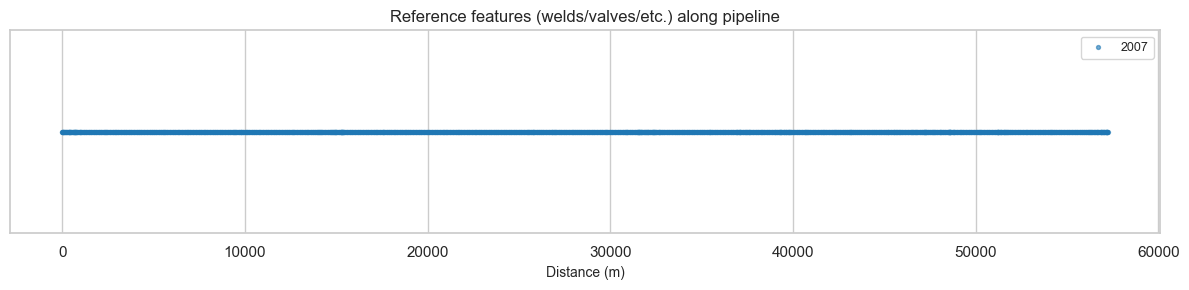

Dead-reckoning gaps (>1 mile):


""


In [46]:
# Detect reference features and dead-reckoning gaps
REF_PATTERNS = ['weld', 'valve', 'flange', 'tee']
MILE_M = 1609.34

def extract_reference_distances(df: pd.DataFrame, yr: str) -> pd.Series:
    if df is None or len(df) == 0:
        return pd.Series(dtype=float)
    ft_col = find_col(df, FEATURE_TYPE_SYNONYMS)
    # Prefer standardized meters distance when available
    dist_col_std = 'distance_m_std' if 'distance_m_std' in df.columns else None
    dist_col_raw = find_col(df, DISTANCE_SYNONYMS)
    if ft_col is None:
        return pd.Series(dtype=float)
    if dist_col_std is None and dist_col_raw is None:
        return pd.Series(dtype=float)
    dist_col = dist_col_std if dist_col_std is not None else dist_col_raw
    # Robust string normalization for feature type
    series = df[ft_col]
    try:
        lower = series.astype('string').fillna('').str.lower()
    except Exception:
        lower = series.astype(str).str.lower().fillna('')
    mask = lower.apply(lambda s: any(p in s for p in REF_PATTERNS))
    s = pd.to_numeric(df.loc[mask, dist_col], errors='coerce').dropna()
    return s

ref_2007 = extract_reference_distances(df_2007_std if 'df_2007_std' in globals() else df_2007, '2007')
ref_2015 = extract_reference_distances(df_2015_std if 'df_2015_std' in globals() else df_2015, '2015')
ref_2022 = extract_reference_distances(df_2022_std if 'df_2022_std' in globals() else df_2022, '2022')

# Plot distribution of references
fig, ax = plt.subplots(figsize=(12, 3))
for yr, s, color in [('2007', ref_2007, 'tab:blue'), ('2015', ref_2015, 'tab:orange'), ('2022', ref_2022, 'tab:green')]:
    if len(s) > 0:
        ax.scatter(s.values, np.ones_like(s.values), label=yr, s=8, alpha=0.6, c=color)
ax.set_xlabel('Distance (m)')
ax.set_yticks([])
ax.set_title('Reference features (welds/valves/etc.) along pipeline')
ax.legend()
plt.tight_layout()
plt.show()

# Identify gaps > 1 mile using combined references
combined = pd.concat([ref_2007, ref_2015, ref_2022], ignore_index=True).dropna().sort_values()
gaps = []
if len(combined) >= 2:
    prev = None
    for x in combined.values:
        if prev is not None:
            gap = x - prev
            if gap > MILE_M:
                gaps.append({'start_m': float(prev), 'end_m': float(x), 'length_m': float(gap)})
        prev = x
ref_gap_tbl = pd.DataFrame(gaps)
print("Dead-reckoning gaps (>1 mile):")
display(ref_gap_tbl)

# Save gaps
ref_gap_tbl.to_csv(os.path.join(output_dir, 'dead_reckoning_gaps.csv'), index=False)

# Initial Cross-Year Matching Sanity Check
We perform a naive distance-based matching to get a sense of overlap and potential ambiguity between consecutive runs (2007→2015 and 2015→2022). We only report summary counts.

In [47]:
# Naive distance-based matching summary
# Prefer standardized distance in meters when available

def naive_match_summary(dfA: pd.DataFrame, dfB: pd.DataFrame, yearA: str, yearB: str, tol_m: float = 5.0) -> Dict[str, int]:
    def get_distance_series(df: pd.DataFrame) -> pd.Series:
        if df is None or len(df) == 0:
            return pd.Series(dtype=float)
        if 'distance_m_std' in df.columns:
            return pd.to_numeric(df['distance_m_std'], errors='coerce')
        dist_col = find_col(df, DISTANCE_SYNONYMS)
        if dist_col is None:
            return pd.Series(dtype=float)
        return pd.to_numeric(df[dist_col], errors='coerce')

    A = get_distance_series(dfA).dropna().values
    B = get_distance_series(dfB).dropna().values
    if len(A) == 0 or len(B) == 0:
        return {'source_year': yearA, 'target_year': yearB, 'source_count': len(A), 'target_count': len(B), 'potential_matches': 0, 'unmatched_source': len(A), 'ambiguous_source': 0}
    B_sorted = np.sort(B)
    potential = 0
    unmatched = 0
    ambiguous = 0
    for a in A:
        # find candidates in B within tol_m using binary search
        left = np.searchsorted(B_sorted, a - tol_m, side='left')
        right = np.searchsorted(B_sorted, a + tol_m, side='right')
        count = max(0, right - left)
        if count == 0:
            unmatched += 1
        elif count == 1:
            potential += 1
        else:
            ambiguous += 1
    return {'source_year': yearA, 'target_year': yearB, 'source_count': len(A), 'target_count': len(B), 'potential_matches': potential, 'unmatched_source': unmatched, 'ambiguous_source': ambiguous}

summary_2007_2015 = naive_match_summary(df_2007_std if 'df_2007_std' in globals() else df_2007,
                                        df_2015_std if 'df_2015_std' in globals() else df_2015,
                                        '2007', '2015', tol_m=5.0)
summary_2015_2022 = naive_match_summary(df_2015_std if 'df_2015_std' in globals() else df_2015,
                                        df_2022_std if 'df_2022_std' in globals() else df_2022,
                                        '2015', '2022', tol_m=5.0)
print("Naive matching summary 2007 → 2015:")
print(summary_2007_2015)
print("\nNaive matching summary 2015 → 2022:")
print(summary_2015_2022)

Naive matching summary 2007 → 2015:
{'source_year': '2007', 'target_year': '2015', 'source_count': 2446, 'target_count': 3678, 'potential_matches': 716, 'unmatched_source': 1454, 'ambiguous_source': 276}

Naive matching summary 2015 → 2022:
{'source_year': '2015', 'target_year': '2022', 'source_count': 3678, 'target_count': 2974, 'potential_matches': 0, 'unmatched_source': 3666, 'ambiguous_source': 12}


# Save Analysis Outputs
We save key tables and summaries (schema, missing values, feature counts, dead-reckoning gaps, naive matching) to CSV/JSON for downstream processing.

In [48]:
# Write summaries to disk
# Naive matching summaries
naive_summaries = pd.DataFrame([summary_2007_2015, summary_2015_2022])
display(naive_summaries)
naive_summaries.to_csv(os.path.join(output_dir, 'naive_matching_summary.csv'), index=False)

# Also dump to JSON
with open(os.path.join(output_dir, 'naive_matching_summary.json'), 'w') as f:
    json.dump([summary_2007_2015, summary_2015_2022], f, indent=2)

print("Saved analysis outputs to:", os.path.abspath(output_dir))
print("If the Excel file path is set and readable, all sections should populate.")

,source_year,target_year,source_count,target_count,potential_matches,unmatched_source,ambiguous_source
0,2007,2015,2446,3678,716,1454,276
1,2015,2022,3678,2974,0,3666,12


Saved analysis outputs to: /Users/satvikaakati/Desktop/Hack/outputs
If the Excel file path is set and readable, all sections should populate.


# Data Ingestion & Preprocessing
We standardize units (feet→meters, inches→mm), normalize clock positions to degrees, and harmonize feature types into canonical categories. The goal is to produce comparable columns across runs for downstream alignment and matching.

In [49]:
# Preprocessing functions: unit standardization and feature normalization
FT_CANON_MAP = {
    'weld': 'weld',
    'valve': 'valve',
    'flange': 'flange',
    'tee': 'tee',
    'metal loss': 'corrosion',
    'corrosion': 'corrosion',
    'pitting': 'corrosion',
    'pit': 'corrosion',
    'ml': 'corrosion',
    'dent': 'dent',
    'gouge': 'gouge',
    'lamination': 'lamination',
}

def normalize_feature_type(s: pd.Series) -> pd.Series:
    if s is None or len(s) == 0:
        return pd.Series([], dtype='object')
    def norm_one(x):
        if pd.isna(x):
            return np.nan
        t = str(x).strip().lower()
        for k, v in FT_CANON_MAP.items():
            if k in t:
                return v
        return t  # fallback to cleaned original
    return s.apply(norm_one)

def detect_distance_units(dist_series: pd.Series, col_name: str | None = None) -> str:
    """Detect units for distance column using column-name cues and magnitude heuristics.
    Prefers explicit ft if column name hints at feet; else uses magnitude.
    """
    # Column-name hint
    if col_name:
        cn = col_name.lower()
        if 'ft' in cn or '[ft]' in cn or 'log dist' in cn:
            return 'ft'
        if 'm' in cn and ('[m]' in cn or 'distance_m' in cn or 'meters' in cn):
            return 'm'
    # Magnitude heuristic
    x = pd.to_numeric(dist_series, errors='coerce').dropna()
    if len(x) == 0:
        return 'm'
    p90 = np.percentile(x, 90)
    mx = np.max(x)
    # Typical pipeline odometer in feet: p90 often in hundreds to thousands; meters often similar.
    # Use a more conservative rule: if max < 20000 and p90 < 5000, and column name didn't say meters, assume feet.
    if (mx < 20000 and p90 < 5000):
        return 'ft'
    # Very large values likely meters (kilometers) or feet on very long lines; default to meters.
    return 'm'

def convert_distance_to_m(dist_series: pd.Series, units: str) -> pd.Series:
    x = pd.to_numeric(dist_series, errors='coerce')
    if units == 'ft':
        return x * 0.3048
    return x

def detect_size_units(size_series: pd.Series) -> str:
    x = pd.to_numeric(size_series, errors='coerce').dropna()
    if len(x) == 0:
        return 'mm'
    median = np.median(x)
    # Heuristic: inches typically < 30 for anomalies; mm often > 30
    if median <= 30:
        return 'in'
    return 'mm'

def convert_size_to_mm(size_series: pd.Series, units: str) -> pd.Series:
    x = pd.to_numeric(size_series, errors='coerce')
    if units == 'in':
        return x * 25.4
    return x

def standardize_depth_percent(depth_series: pd.Series) -> pd.Series:
    x = pd.to_numeric(depth_series, errors='coerce')
    # If max <= 1, likely fraction; convert to percent
    mx = pd.to_numeric(depth_series, errors='coerce').max()
    if pd.notna(mx) and mx <= 1:
        return x * 100.0
    return x

def preprocess_df(df: pd.DataFrame, year_label: str) -> pd.DataFrame:
    if df is None or len(df) == 0:
        return df
    km = get_key_cols(df)
    out = df.copy()
    # Distance
    if km['distance'] is not None and km['distance'] in out.columns:
        units = detect_distance_units(out[km['distance']], col_name=km['distance'])
        out['distance_m_std'] = convert_distance_to_m(out[km['distance']], units)
        out['distance_units_detected'] = units
    else:
        out['distance_m_std'] = np.nan
        out['distance_units_detected'] = np.nan
    # Length
    if km['length'] is not None and km['length'] in out.columns:
        lunits = detect_size_units(out[km['length']])
        out['length_mm_std'] = convert_size_to_mm(out[km['length']], lunits)
        out['length_units_detected'] = lunits
    else:
        out['length_mm_std'] = np.nan
        out['length_units_detected'] = np.nan
    # Width
    if km['width'] is not None and km['width'] in out.columns:
        wunits = detect_size_units(out[km['width']])
        out['width_mm_std'] = convert_size_to_mm(out[km['width']], wunits)
        out['width_units_detected'] = wunits
    else:
        out['width_mm_std'] = np.nan
        out['width_units_detected'] = np.nan
    # Depth percent
    if km['depth_pct'] is not None and km['depth_pct'] in out.columns:
        out['depth_percent_std'] = standardize_depth_percent(out[km['depth_pct']])
    else:
        out['depth_percent_std'] = np.nan
    # Clock normalization (reuse clock_deg_norm if already present)
    if 'clock_deg_norm' in out.columns:
        out['clock_deg_std'] = out['clock_deg_norm']
    else:
        if km['clock'] is not None and km['clock'] in out.columns:
            out['clock_deg_std'] = parse_clock_to_deg(out[km['clock']])
        else:
            out['clock_deg_std'] = np.nan
    # Feature type normalization
    if km['feature_type'] is not None and km['feature_type'] in out.columns:
        out['feature_type_norm'] = normalize_feature_type(out[km['feature_type']])
    else:
        out['feature_type_norm'] = np.nan
    # Canonical presence flags
    out['has_canonical_location'] = out['distance_m_std'].notna() & out['clock_deg_std'].notna()
    out['has_canonical_geometry'] = out['depth_percent_std'].notna()
    out['has_canonical_classification'] = out['feature_type_norm'].notna()
    return out

# Apply preprocessing to each run
df_2007_std = preprocess_df(df_2007, '2007')
df_2015_std = preprocess_df(df_2015, '2015')
df_2022_std = preprocess_df(df_2022, '2022')

print("Preprocessing complete. Canonical columns created:")
print([
    'distance_m_std', 'length_mm_std', 'width_mm_std', 'depth_percent_std', 'clock_deg_std', 'feature_type_norm'
])

print("\nSample preview (up to 5 rows per year):")
print("2007:")
print_head(df_2007_std, '2007_std')
print("2015:")
print_head(df_2015_std, '2015_std')
print("2022:")
print_head(df_2022_std, '2022_std')

# Save standardized outputs
if df_2007_std is not None and len(df_2007_std) > 0:
    df_2007_std.to_csv(os.path.join(output_dir, '2007_standardized.csv'), index=False)
if df_2015_std is not None and len(df_2015_std) > 0:
    df_2015_std.to_csv(os.path.join(output_dir, '2015_standardized.csv'), index=False)
if df_2022_std is not None and len(df_2022_std) > 0:
    df_2022_std.to_csv(os.path.join(output_dir, '2022_standardized.csv'), index=False)

Preprocessing complete. Canonical columns created:
['distance_m_std', 'length_mm_std', 'width_mm_std', 'depth_percent_std', 'clock_deg_std', 'feature_type_norm']

Sample preview (up to 5 rows per year):
2007:


,J. no.,J. len [ft],t [in],to u/s w. [ft],log dist. [ft],Height [ft],event,depth [%],ID Reduction [%],length [in],width [in],P2 Burst / MOP,o'clock,internal,comment,clock_deg_norm,distance_m_std,distance_units_detected,length_mm_std,length_units_detected,width_mm_std,width_units_detected,depth_percent_std,clock_deg_std,feature_type_norm,has_canonical_location,has_canonical_geometry,has_canonical_classification
0,NaN,NaN,0.449,NaN,-27.82,803.6748,Area Start Launcher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.479536,ft,NaN,in,NaN,in,NaN,NaN,area start launcher,False,False,True
1,NaN,NaN,NaN,NaN,-19.48,803.6644,Support,NaN,NaN,NaN,NaN,NaN,06:00:00,NaN,NaN,180.0,-5.937504,ft,NaN,in,NaN,in,NaN,180.0,support,True,False,True
2,NaN,NaN,NaN,NaN,-15.78,803.6598,Support,NaN,NaN,NaN,NaN,NaN,06:00:00,NaN,NaN,180.0,-4.809744,ft,NaN,in,NaN,in,NaN,180.0,support,True,False,True
3,NaN,NaN,NaN,NaN,-12.21,803.6553,Tap,NaN,NaN,NaN,NaN,NaN,06:00:00,NaN,NaN,180.0,-3.721608,ft,NaN,in,NaN,in,NaN,180.0,tap,True,False,True
4,NaN,NaN,NaN,NaN,-6.49,803.6481,Support,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Strap,NaN,-1.978152,ft,NaN,in,NaN,in,NaN,NaN,support,False,False,True


2015:


,J. no.,J. len [ft],Wt [in],to u/s w. [ft],to d/s w. [ft],Log Dist. [ft],Event Description,ID/OD,Depth [%],Depth [in],OD Reduction [%],OD Reduction [in],Length [in],Width [in],O'clock,Comments,Anomalies per Joint,Tool Velocity [ft/s],Elevation [ft],Seam Position (TFI),Tool (TFI),Seam Anomaly (TFI),MOP [PSI],SMYS [PSI],Seam Type,Pdesign [PSI],B31G Psafe [PSI],B31G Pburst [PSI],Mod B31G Psafe [PSI],Mod B31G Pburst [PSI],Effective Area Psafe [PSI],Effective Area Pburst [PSI],ERF,RPR,clock_deg_norm,distance_m_std,distance_units_detected,length_mm_std,length_units_detected,width_mm_std,width_units_detected,depth_percent_std,clock_deg_std,feature_type_norm,has_canonical_location,has_canonical_geometry,has_canonical_classification
0,NaN,NaN,NaN,NaN,NaN,-14.60,Area Start Launcher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.450080,ft,NaN,in,NaN,in,NaN,NaN,NaN,False,False,False
1,NaN,NaN,NaN,NaN,NaN,-1.39,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,NaN,NaN,NaN,233.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,-0.423672,ft,NaN,in,NaN,in,NaN,270.0,NaN,True,False,False
2,NaN,NaN,NaN,NaN,NaN,0.00,Valve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,233.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,ft,NaN,in,NaN,in,NaN,NaN,NaN,False,False,False
3,NaN,NaN,NaN,NaN,NaN,1.40,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,NaN,NaN,NaN,233.45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,0.426720,ft,NaN,in,NaN,in,NaN,270.0,NaN,True,False,False
4,NaN,NaN,NaN,NaN,NaN,8.16,Tee,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,NaN,NaN,NaN,233.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,2.487168,ft,NaN,in,NaN,in,NaN,270.0,NaN,True,False,False


2022:


,Joint Number,Joint Length [ft],WT [in],Distance to U/S GW \n[ft],Distance to D/S GW \n[ft],ILI Wheel Count \n[ft.],Event Description,ID/OD,Metal Loss Depth \n[%],Metal Loss Depth \n[in],Metal Loss Depth + Tolerance\n[%],Dimension Classification,Metal Loss Depth Tolerance [%] \n(includes seamless and HAZ and modified specs),Dent Depth\n [%],Dent Depth\n [in],Is any part of the dent affecting the top of the pipe? \n[Y/N],Length [in],Width [in],O'clock\n[hh:mm],Comments,Anomalies per Joint,Was anomaly sizing reviewed by analyst? \n[Y/N],Was anomaly sizing/dimensions manually changed? \n[Y/N],Magnetization Level \n[kA/m] for MFL survey \nor \nActual WT [in] for UT Survey,Elevation [ft],Seam Position\n[hh:mm],Distance To Seam Weld \n[in],Tool,Evaluation Pressure [PSI],SMYS [PSI],Pipe Type,Pipe Diameter (O.D.) \n[in.],Pdesign [PSI],Mod B31G Psafe \n[PSI],Mod B31G Pburst [PSI],Mod B31G Psafe Pressure with Tolerance\n[PSI],Mod B31G Pburst Pressure with Tolerance\n[PSI],Effective Area Psafe [PSI],Effective Area Pburst [PSI],ERF,RPR,Length Tolerance [in],Width Tolerance [in],clock_deg_norm,distance_m_std,distance_units_detected,length_mm_std,length_units_detected,width_mm_std,width_units_detected,depth_percent_std,clock_deg_std,feature_type_norm,has_canonical_location,has_canonical_geometry,has_canonical_classification
0,5,4.528,0.344,NaN,NaN,-2.500,Girth Weld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIRTH WELD - ERW START,0,NaN,NaN,5.97,NaN,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft,NaN,in,NaN,in,NaN,NaN,NaN,False,False,False
1,5,4.528,0.344,NaN,NaN,-1.565,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,1.5 IN OFFTAKE-WELDOLET,0,NaN,NaN,5.97,NaN,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,ft,NaN,in,NaN,in,NaN,270.0,NaN,False,False,False
2,5,4.528,0.344,NaN,NaN,-0.003,Valve,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MOV-0109C LAUNCHER,0,NaN,NaN,5.97,233.47,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft,NaN,in,NaN,in,NaN,NaN,NaN,False,False,False
3,5,4.528,0.344,NaN,NaN,1.243,Tap,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,09:00:00,1.5 IN OFFTAKE-WELDOLET,0,NaN,NaN,5.97,233.45,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,270.0,NaN,ft,NaN,in,NaN,in,NaN,270.0,NaN,False,False,False
4,15,4.551,0.344,NaN,NaN,2.028,Girth Weld,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,GIRTH WELD,0,NaN,NaN,5.97,NaN,UNKN,NaN,CMFL,1025,65000,E.R. WELD,24,1341.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ft,NaN,in,NaN,in,NaN,NaN,NaN,False,False,False


In [50]:
# Anchors extraction and baseline alignment prep
from typing import Dict, Tuple

ANCHOR_TYPES = {"weld", "valve", "tee", "flange"}

def extract_anchors(df_std: pd.DataFrame, raw_df: pd.DataFrame, year_label: str) -> pd.DataFrame:
    """Return reference anchors (welds, valves, fittings) with canonical location fields.
    Uses feature_type_norm if available; falls back to raw feature/event column when empty.
    """
    if df_std is None or len(df_std) == 0:
        return pd.DataFrame(columns=["year","idx","anchor_type","event_raw","distance_m_std","clock_deg_std"])    
    km = get_key_cols(raw_df)
    # Decide source text
    use_norm = ("feature_type_norm" in df_std.columns) and (df_std["feature_type_norm"].notna().any())
    if use_norm:
        src = df_std["feature_type_norm"].astype(str).str.lower()
    else:
        # Fallback: raw event/description column
        event_col = km.get("feature_type")
        if event_col is None:
            # Try common names directly
            event_col = find_col(raw_df, ["Event Description", "Event", "event", "Event Type", "Event\nDescription"])    
        src = raw_df[event_col].astype(str).str.lower() if event_col else pd.Series([None]*len(df_std))
    # Debug sample of src
    print(f"[{year_label}] src sample:", src.head(10).tolist())
    # Filter anchors by type keywords
    def classify_anchor(t: str) -> str | None:
        if t is None:
            return None
        t = str(t)
        for a in ANCHOR_TYPES:
            if a in t:
                return a
        # Map common synonyms
        if "girth" in t and "weld" in t:
            return "weld"
        if "tap" in t:
            return "tee"  # treat taps as fittings
        if "fitting" in t:
            return "flange"  # generic fitting -> flange bucket
        return None
    anchor_type = src.apply(classify_anchor)
    mask = anchor_type.notna() & df_std["distance_m_std"].notna()
    # Debug counts
    print(f"[{year_label}] anchor_type.notna() = {int(anchor_type.notna().sum())}")
    print(f"[{year_label}] distance_m_std.notna() = {int(df_std['distance_m_std'].notna().sum())}")
    print(f"[{year_label}] combined mask sum = {int(mask.sum())}")
    anchors = pd.DataFrame({
        "year": year_label,
        "idx": df_std.index,
        "anchor_type": anchor_type,
        "event_raw": src,
        "distance_m_std": df_std["distance_m_std"],
        "clock_deg_std": df_std.get("clock_deg_std", pd.Series([np.nan]*len(df_std)))
    })
    # Use positional mask to avoid index alignment issues
    anchors = anchors[mask.values].copy()
    anchors = anchors.sort_values(by=["distance_m_std"]).reset_index(drop=True)
    return anchors

# Build anchors per run and save
anchors_2007 = extract_anchors(df_2007_std, df_2007, "2007")
anchors_2015 = extract_anchors(df_2015_std, df_2015, "2015")
anchors_2022 = extract_anchors(df_2022_std, df_2022, "2022")

anchors_2007.to_csv(os.path.join(output_dir, "anchors_2007.csv"), index=False)
anchors_2015.to_csv(os.path.join(output_dir, "anchors_2015.csv"), index=False)
anchors_2022.to_csv(os.path.join(output_dir, "anchors_2022.csv"), index=False)

print(f"Anchors extracted: 2007={len(anchors_2007)}, 2015={len(anchors_2015)}, 2022={len(anchors_2022)}")

# Matching and affine alignment (Run B -> align to Run A)

def match_anchors(a1: pd.DataFrame, a2: pd.DataFrame, tol_m: float = 150.0) -> pd.DataFrame:
    """Greedy ordinal matching by anchor_type. Returns pairs with residuals after initial fit.
    """
    pairs = []
    for t in sorted(ANCHOR_TYPES):
        d1 = a1[a1["anchor_type"] == t]["distance_m_std"].values
        d2 = a2[a2["anchor_type"] == t]["distance_m_std"].values
        n = min(len(d1), len(d2))
        if n == 0:
            continue
        # Ordinal pairing
        for i in range(n):
            pairs.append((t, float(d1[i]), float(d2[i])))
    if not pairs:
        return pd.DataFrame(columns=["anchor_type","d_src","d_dst"])    
    mdf = pd.DataFrame(pairs, columns=["anchor_type","d_src","d_dst"])    
    # Initial fit across all types
    a, b = np.polyfit(mdf["d_dst"], mdf["d_src"], 1)
    mdf["d_aligned"] = a * mdf["d_dst"] + b
    mdf["residual_m"] = mdf["d_src"] - mdf["d_aligned"]
    # Inlier refinement
    inliers = mdf[mdf["residual_m"].abs() <= tol_m]
    if len(inliers) >= 3:
        a, b = np.polyfit(inliers["d_dst"], inliers["d_src"], 1)
        mdf["d_aligned"] = a * mdf["d_dst"] + b
        mdf["residual_m"] = mdf["d_src"] - mdf["d_aligned"]
    mdf["a"] = a
    mdf["b"] = b
    return mdf


def compute_alignment(a1: pd.DataFrame, a2: pd.DataFrame, label_src: str, label_dst: str, tol_m: float = 150.0) -> Tuple[Dict[str, float], pd.DataFrame]:
    mdf = match_anchors(a1, a2, tol_m=tol_m)
    if len(mdf) == 0:
        return {"a": 1.0, "b": 0.0, "n_pairs": 0, "rmse_m": None}, mdf
    # Final parameters from last fit
    a = float(mdf["a"].iloc[-1])
    b = float(mdf["b"].iloc[-1])
    rmse = float(np.sqrt(np.mean(np.square(mdf["residual_m"])) ))
    params = {"a": a, "b": b, "n_pairs": int(len(mdf)), "rmse_m": rmse, "src": label_src, "dst": label_dst}
    return params, mdf

params_2007_2015, matches_2007_2015 = compute_alignment(anchors_2007, anchors_2015, "2007", "2015")
params_2015_2022, matches_2015_2022 = compute_alignment(anchors_2015, anchors_2022, "2015", "2022")

# Save matches and params
matches_2007_2015.to_csv(os.path.join(output_dir, "matches_2007_2015.csv"), index=False)
matches_2015_2022.to_csv(os.path.join(output_dir, "matches_2015_2022.csv"), index=False)
with open(os.path.join(output_dir, "alignment_params_2007_2015.json"), "w") as f:
    json.dump(params_2007_2015, f, indent=2)
with open(os.path.join(output_dir, "alignment_params_2015_2022.json"), "w") as f:
    json.dump(params_2015_2022, f, indent=2)

print("Alignment parameters:")
print(params_2007_2015)
print(params_2015_2022)

# Apply alignment to create ready aligned datasets (dst aligned to src)

def apply_alignment(df_std: pd.DataFrame, params: Dict[str, float], src_label: str, dst_label: str) -> pd.DataFrame:
    out = df_std.copy()
    a = float(params.get("a", 1.0))
    b = float(params.get("b", 0.0))
    out[f"distance_m_aligned_to_{src_label}"] = a * out["distance_m_std"] + b
    return out

aligned_2015_to_2007 = apply_alignment(df_2015_std, params_2007_2015, "2007", "2015")
aligned_2022_to_2015 = apply_alignment(df_2022_std, params_2015_2022, "2015", "2022")

aligned_2015_to_2007.to_csv(os.path.join(output_dir, "aligned_2015_to_2007.csv"), index=False)
aligned_2022_to_2015.to_csv(os.path.join(output_dir, "aligned_2022_to_2015.csv"), index=False)

print("Aligned datasets saved: aligned_2015_to_2007.csv, aligned_2022_to_2015.csv")

[2007] src sample: ['area start launcher', 'support', 'support', 'tap', 'support', 'flange', 'tap', 'valve', 'tap', 'tee']
[2007] anchor_type.notna() = 1629
[2007] distance_m_std.notna() = 2446
[2007] combined mask sum = 1629
[2015] src sample: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[2015] anchor_type.notna() = 0
[2015] distance_m_std.notna() = 3678
[2015] combined mask sum = 0
[2022] src sample: [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]
[2022] anchor_type.notna() = 0
[2022] distance_m_std.notna() = 2974
[2022] combined mask sum = 0
Anchors extracted: 2007=1629, 2015=0, 2022=0
Alignment parameters:
{'a': 1.0, 'b': 0.0, 'n_pairs': 0, 'rmse_m': None}
{'a': 1.0, 'b': 0.0, 'n_pairs': 0, 'rmse_m': None}
Aligned datasets saved: aligned_2015_to_2007.csv, aligned_2022_to_2015.csv
Aligned datasets saved: aligned_2015_to_2007.csv, aligned_2022_to_2015.csv


In [51]:
# Quick debug: feature type counts and anchor availability
print("Feature type counts (normalized):")
for lbl, df_std in [("2007", df_2007_std), ("2015", df_2015_std), ("2022", df_2022_std)]:
    vc = df_std.get("feature_type_norm", pd.Series([], dtype="object")).value_counts(dropna=False).head(10)
    print(lbl, vc.to_dict())

print("\nAnchor type presence by run:")
for lbl, df_std in [("2007", df_2007_std), ("2015", df_2015_std), ("2022", df_2022_std)]:
    if "feature_type_norm" in df_std.columns:
        has_anchor = df_std["feature_type_norm"].astype(str).str.contains("weld|valve|tee|flange|tap", case=False, regex=True)
        print(lbl, int(has_anchor.sum()), "candidate anchor rows")
    else:
        print(lbl, 0, "candidate anchor rows (no feature_type_norm)")

Feature type counts (normalized):
2007 {'weld': 1603, 'cluster': 387, 'corrosion': 324, 'bend': 78, 'tap': 18, 'above ground marker': 12, 'support': 5, 'valve': 4, 'flange': 2, 'tee': 2}
2015 {nan: 3678}
2022 {nan: 2597, 'gene': 2262, 'corrosion': 229, 'axgr': 101, 'cigr': 26, 'axsl': 14, 'cisl': 4}

Anchor type presence by run:
2007 1629 candidate anchor rows
2015 0 candidate anchor rows
2022 0 candidate anchor rows


In [52]:
# Debug: print raw columns for 2015/2022 to locate event description fields
print("2015 raw columns:")
print(list(df_2015.columns))
print("2022 raw columns:")
print(list(df_2022.columns))

# Show a sample of potential event description text
cand_2015 = find_col(df_2015, ["Event Description", "Event", "event", "Event Type", "Event\\nDescription"]) 
print("Detected 2015 event col:", cand_2015)
if cand_2015:
    print(df_2015[cand_2015].head(10).tolist())

cand_2022 = find_col(df_2022, ["Event Description", "Event", "event", "Event Type", "Event\\nDescription"]) 
print("Detected 2022 event col:", cand_2022)
if cand_2022:
    print(df_2022[cand_2022].head(10).tolist())

2015 raw columns:
['J. no.', 'J. len [ft]', 'Wt [in]', 'to u/s w. [ft]', 'to d/s w. [ft]', 'Log Dist. [ft]', 'Event Description', 'ID/OD', 'Depth [%]', 'Depth [in]', 'OD Reduction [%]', 'OD Reduction [in]', 'Length [in]', 'Width [in]', "O'clock", 'Comments', 'Anomalies per Joint', 'Tool Velocity [ft/s]', 'Elevation [ft]', 'Seam Position (TFI)', 'Tool   (TFI)', 'Seam Anomaly  (TFI)', 'MOP [PSI]', 'SMYS [PSI]', 'Seam Type', 'Pdesign [PSI]', 'B31G Psafe [PSI]', 'B31G Pburst [PSI]', 'Mod B31G Psafe [PSI]', 'Mod B31G Pburst [PSI]', 'Effective Area Psafe [PSI]', 'Effective Area Pburst [PSI]', 'ERF', 'RPR', 'clock_deg_norm']
2022 raw columns:
['Joint Number', 'Joint Length [ft]', 'WT [in]', 'Distance to U/S GW \n[ft]', 'Distance to D/S GW \n[ft]', 'ILI Wheel Count \n[ft.]', 'Event Description', 'ID/OD', 'Metal Loss Depth \n[%]', 'Metal Loss Depth \n[in]', 'Metal Loss Depth + Tolerance\n[%]', 'Dimension Classification', 'Metal Loss Depth Tolerance [%] \n(includes seamless and HAZ and modified 

In [53]:
# Temporary debug: manual anchor detection on 2015 using raw Event Description
src_2015 = df_2015[find_col(df_2015, ["Event Description", "Event", "event"])].astype(str).str.lower()

def classify_anchor_debug(t: str) -> str | None:
    if t is None:
        return None
    for a in ANCHOR_TYPES:
        if a in t:
            return a
    if "girth" in t and "weld" in t:
        return "weld"
    if "tap" in t:
        return "tee"
    if "fitting" in t:
        return "flange"
    return None

anchor_types_2015 = src_2015.apply(classify_anchor_debug)
print("2015 manual anchors classified:", int(anchor_types_2015.notna().sum()))
print("Sample anchors:", src_2015[anchor_types_2015.notna()].head(10).tolist())
print("distance_m_std populated:", int(df_2015_std["distance_m_std"].notna().sum()))
print("Overlap anchors & distance:", int((anchor_types_2015.notna() & df_2015_std["distance_m_std"].notna()).sum()))

2015 manual anchors classified: 1637
Sample anchors: ['tap', 'valve', 'tap', 'tee', 'tap', 'girthweld', 'girthweld', 'girthweld', 'girthweld', 'girthweld']
distance_m_std populated: 3678
Overlap anchors & distance: 1637


In [54]:
# Anchor override for 2015/2022 using raw Event Description
# Build 2015 anchors
_ev15 = find_col(df_2015, ["Event Description", "Event", "event"]) 
src15 = df_2015[_ev15].astype(str).str.lower()

def _class_anchor(t: str) -> str | None:
    if t is None:
        return None
    for a in ANCHOR_TYPES:
        if a in t:
            return a
    if "girth" in t and "weld" in t:
        return "weld"
    if "tap" in t:
        return "tee"
    if "fitting" in t:
        return "flange"
    return None

at15 = src15.apply(_class_anchor)
mask15 = at15.notna() & df_2015_std["distance_m_std"].notna()
anchors_2015 = pd.DataFrame({
    "year": "2015",
    "idx": df_2015_std.index,
    "anchor_type": at15,
    "event_raw": src15,
    "distance_m_std": df_2015_std["distance_m_std"],
    "clock_deg_std": df_2015_std.get("clock_deg_std", pd.Series([np.nan]*len(df_2015_std)))
})
anchors_2015 = anchors_2015[mask15.values].sort_values(by=["distance_m_std"]).reset_index(drop=True)
anchors_2015.to_csv(os.path.join(output_dir, "anchors_2015.csv"), index=False)
print("[override] anchors_2015:", len(anchors_2015))

# Build 2022 anchors
_ev22 = find_col(df_2022, ["Event Description", "Event", "event"]) 
src22 = df_2022[_ev22].astype(str).str.lower()
at22 = src22.apply(_class_anchor)
mask22 = at22.notna() & df_2022_std["distance_m_std"].notna()
anchors_2022 = pd.DataFrame({
    "year": "2022",
    "idx": df_2022_std.index,
    "anchor_type": at22,
    "event_raw": src22,
    "distance_m_std": df_2022_std["distance_m_std"],
    "clock_deg_std": df_2022_std.get("clock_deg_std", pd.Series([np.nan]*len(df_2022_std)))
})
anchors_2022 = anchors_2022[mask22.values].sort_values(by=["distance_m_std"]).reset_index(drop=True)
anchors_2022.to_csv(os.path.join(output_dir, "anchors_2022.csv"), index=False)
print("[override] anchors_2022:", len(anchors_2022))

# Recompute matches and params using overrides
params_2007_2015, matches_2007_2015 = compute_alignment(anchors_2007, anchors_2015, "2007", "2015")
params_2015_2022, matches_2015_2022 = compute_alignment(anchors_2015, anchors_2022, "2015", "2022")

matches_2007_2015.to_csv(os.path.join(output_dir, "matches_2007_2015.csv"), index=False)
matches_2015_2022.to_csv(os.path.join(output_dir, "matches_2015_2022.csv"), index=False)
with open(os.path.join(output_dir, "alignment_params_2007_2015.json"), "w") as f:
    json.dump(params_2007_2015, f, indent=2)
with open(os.path.join(output_dir, "alignment_params_2015_2022.json"), "w") as f:
    json.dump(params_2015_2022, f, indent=2)
print("[override] alignment params:", params_2007_2015, params_2015_2022)

# Apply alignment and save
aligned_2015_to_2007 = apply_alignment(df_2015_std, params_2007_2015, "2007", "2015")
aligned_2022_to_2015 = apply_alignment(df_2022_std, params_2015_2022, "2015", "2022")
aligned_2015_to_2007.to_csv(os.path.join(output_dir, "aligned_2015_to_2007.csv"), index=False)
aligned_2022_to_2015.to_csv(os.path.join(output_dir, "aligned_2022_to_2015.csv"), index=False)
print("[override] aligned datasets updated.")

[override] anchors_2015: 1637
[override] anchors_2022: 331
[override] alignment params: {'a': 1.0004704050591884, 'b': 26.700326892595946, 'n_pairs': 1628, 'rmse_m': 688.417500567444, 'src': '2007', 'dst': '2015'} {'a': 349.36895696640954, 'b': -164.9765962472576, 'n_pairs': 331, 'rmse_m': 145.41282121264246, 'src': '2015', 'dst': '2022'}
[override] aligned datasets updated.
[override] aligned datasets updated.


In [55]:
# Robust alignment (RANSAC + piecewise) using weld-only anchors
from dataclasses import dataclass

@dataclass
class AffineParams:
    a: float
    b: float
    rmse_m: float | None
    n_pairs: int


def ordinal_pairs(a1: pd.DataFrame, a2: pd.DataFrame, anchor_type: str = "weld") -> Tuple[np.ndarray, np.ndarray]:
    d1 = a1[a1["anchor_type"] == anchor_type]["distance_m_std"].values
    d2 = a2[a2["anchor_type"] == anchor_type]["distance_m_std"].values
    n = min(len(d1), len(d2))
    return d2[:n].astype(float), d1[:n].astype(float)  # dst, src


def ransac_affine(d_dst: np.ndarray, d_src: np.ndarray, n_iter: int = 500, residual_thresh: float = 150.0, min_inliers: int = 25) -> AffineParams:
    if len(d_dst) < 2 or len(d_src) < 2:
        # Fallback to LS if insufficient points
        a, b = np.polyfit(d_dst, d_src, 1)
        rmse = float(np.sqrt(np.mean(np.square(d_src - (a*d_dst + b)))))
        return AffineParams(a=float(a), b=float(b), rmse_m=rmse, n_pairs=len(d_dst))
    best_inliers = None
    best_a, best_b = 1.0, 0.0
    rng = np.random.default_rng(42)
    for _ in range(n_iter):
        # Randomly sample 2 points to determine a,b
        idx = rng.choice(len(d_dst), size=2, replace=False)
        x = d_dst[idx]
        y = d_src[idx]
        if np.abs(x[1]-x[0]) < 1e-6:
            continue
        a = (y[1]-y[0]) / (x[1]-x[0])
        b = y[0] - a*x[0]
        residuals = d_src - (a*d_dst + b)
        inliers = np.where(np.abs(residuals) <= residual_thresh)[0]
        if best_inliers is None or len(inliers) > len(best_inliers):
            best_inliers = inliers
            best_a, best_b = a, b
    if best_inliers is None or len(best_inliers) < min_inliers:
        a, b = np.polyfit(d_dst, d_src, 1)
        residuals = d_src - (a*d_dst + b)
        rmse = float(np.sqrt(np.mean(np.square(residuals))))
        return AffineParams(a=float(a), b=float(b), rmse_m=rmse, n_pairs=len(d_dst))
    # Refine on inliers
    a, b = np.polyfit(d_dst[best_inliers], d_src[best_inliers], 1)
    residuals = d_src[best_inliers] - (a*d_dst[best_inliers] + b)
    rmse = float(np.sqrt(np.mean(np.square(residuals))))
    return AffineParams(a=float(a), b=float(b), rmse_m=rmse, n_pairs=int(len(best_inliers)))


def piecewise_affine(d_dst: np.ndarray, d_src: np.ndarray, n_bins: int = 8, min_bin_points: int = 20) -> list[dict]:
    if len(d_dst) < n_bins:
        a, b = np.polyfit(d_dst, d_src, 1)
        return [{"bin_start": float(np.min(d_dst)), "bin_end": float(np.max(d_dst)), "a": float(a), "b": float(b), "count": int(len(d_dst))}]
    qs = np.quantile(d_dst, np.linspace(0, 1, n_bins+1))
    params = []
    for i in range(n_bins):
        lo, hi = qs[i], qs[i+1]
        mask = (d_dst >= lo) & (d_dst <= hi)
        x = d_dst[mask]
        y = d_src[mask]
        if len(x) < min_bin_points:
            continue
        a, b = np.polyfit(x, y, 1)
        params.append({"bin_start": float(lo), "bin_end": float(hi), "a": float(a), "b": float(b), "count": int(len(x))})
    return params


def apply_piecewise(df_std: pd.DataFrame, params: list[dict], src_label: str) -> pd.DataFrame:
    out = df_std.copy()
    col = f"distance_m_aligned_to_{src_label}_piecewise"
    out[col] = np.nan
    d = out["distance_m_std"].values.astype(float)
    res = np.full_like(d, np.nan)
    for p in params:
        mask = (d >= p["bin_start"]) & (d <= p["bin_end"]) 
        res[mask] = p["a"] * d[mask] + p["b"]
    out[col] = res
    return out

# Build weld-only sequences for both pairs
w07 = anchors_2007[anchors_2007["anchor_type"] == "weld"]
w15 = anchors_2015[anchors_2015["anchor_type"] == "weld"]
w22 = anchors_2022[anchors_2022["anchor_type"] == "weld"]

# Prepare pairs (ordinal)
d_dst_15, d_src_07 = ordinal_pairs(anchors_2007, anchors_2015, anchor_type="weld")
d_dst_22, d_src_15 = ordinal_pairs(anchors_2015, anchors_2022, anchor_type="weld")

# RANSAC affine fits
ransac_07_15 = ransac_affine(d_dst_15, d_src_07, n_iter=800, residual_thresh=120.0, min_inliers=50)
ransac_15_22 = ransac_affine(d_dst_22, d_src_15, n_iter=800, residual_thresh=120.0, min_inliers=30)

params_ransac_2007_2015 = {"a": ransac_07_15.a, "b": ransac_07_15.b, "rmse_m": ransac_07_15.rmse_m, "n_pairs": ransac_07_15.n_pairs, "src": "2007", "dst": "2015"}
params_ransac_2015_2022 = {"a": ransac_15_22.a, "b": ransac_15_22.b, "rmse_m": ransac_15_22.rmse_m, "n_pairs": ransac_15_22.n_pairs, "src": "2015", "dst": "2022"}

with open(os.path.join(output_dir, "alignment_params_ransac_2007_2015.json"), "w") as f:
    json.dump(params_ransac_2007_2015, f, indent=2)
with open(os.path.join(output_dir, "alignment_params_ransac_2015_2022.json"), "w") as f:
    json.dump(params_ransac_2015_2022, f, indent=2)

# Apply RANSAC affine alignment
aligned_2015_to_2007_ransac = apply_alignment(df_2015_std, params_ransac_2007_2015, "2007", "2015")
aligned_2022_to_2015_ransac = apply_alignment(df_2022_std, params_ransac_2015_2022, "2015", "2022")

aligned_2015_to_2007_ransac.to_csv(os.path.join(output_dir, "aligned_2015_to_2007_ransac.csv"), index=False)
aligned_2022_to_2015_ransac.to_csv(os.path.join(output_dir, "aligned_2022_to_2015_ransac.csv"), index=False)

# Piecewise fits
pw_07_15 = piecewise_affine(d_dst_15, d_src_07, n_bins=8, min_bin_points=20)
pw_15_22 = piecewise_affine(d_dst_22, d_src_15, n_bins=8, min_bin_points=20)

with open(os.path.join(output_dir, "alignment_params_piecewise_2007_2015.json"), "w") as f:
    json.dump({"bins": pw_07_15, "src": "2007", "dst": "2015"}, f, indent=2)
with open(os.path.join(output_dir, "alignment_params_piecewise_2015_2022.json"), "w") as f:
    json.dump({"bins": pw_15_22, "src": "2015", "dst": "2022"}, f, indent=2)

aligned_2015_to_2007_piece = apply_piecewise(df_2015_std, pw_07_15, "2007")
aligned_2022_to_2015_piece = apply_piecewise(df_2022_std, pw_15_22, "2015")

aligned_2015_to_2007_piece.to_csv(os.path.join(output_dir, "aligned_2015_to_2007_piecewise.csv"), index=False)
aligned_2022_to_2015_piece.to_csv(os.path.join(output_dir, "aligned_2022_to_2015_piecewise.csv"), index=False)

print("RANSAC params:", params_ransac_2007_2015, params_ransac_2015_2022)
print("Piecewise bins counts:", [p.get('count', 0) for p in pw_07_15], [p.get('count', 0) for p in pw_15_22])

RANSAC params: {'a': 1.0004805166520996, 'b': 26.914519613115232, 'rmse_m': 12.19348212635664, 'n_pairs': 1603, 'src': '2007', 'dst': '2015'} {'a': 414.54738440983886, 'b': -429.1957023867413, 'rmse_m': 66.0045108588896, 'n_pairs': 210, 'src': '2015', 'dst': '2022'}
Piecewise bins counts: [201, 200, 200, 201, 201, 200, 200, 201] [42, 41, 41, 42, 42, 41, 41, 42]


In [56]:
# Step 3: Anomaly matching (Run 2 -> Run 1) using rule-based similarity
from typing import Dict, Tuple

def angle_diff_deg(a: float, b: float) -> float:
    if pd.isna(a) or pd.isna(b):
        return np.nan
    d = abs((a - b) % 360.0)
    return d if d <= 180.0 else 360.0 - d

# Similarity scoring weights and scales
SIM_WEIGHTS = {
    "distance": 0.4,
    "clock": 0.2,
    "type": 0.2,
    "size": 0.2,
}
SIM_SCALES = {
    "distance_m": 150.0,   # meters
    "clock_deg": 90.0,     # degrees
    "length_mm": 50.0,     # mm
    "width_mm": 50.0,      # mm
    "depth_pct": 20.0,     # percentage points
}

TYPE_COMPAT = {
    ("corrosion", "corrosion"): 1.0,
    ("weld", "weld"): 1.0,
    ("dent", "dent"): 1.0,
    ("gouge", "gouge"): 1.0,
    ("tee", "tee"): 0.9,
    ("valve", "valve"): 0.9,
}


def type_score(t_dst: str, t_src: str) -> float:
    if pd.isna(t_dst) or pd.isna(t_src):
        return 0.0
    td = str(t_dst).strip().lower()
    ts = str(t_src).strip().lower()
    if (td, ts) in TYPE_COMPAT:
        return TYPE_COMPAT[(td, ts)]
    if td == ts:
        return 1.0
    # corrosion family compatibility
    if ("corrosion" in td) and ("corrosion" in ts):
        return 0.9
    return 0.0


def size_similarity(dst_row: pd.Series, src_row: pd.Series) -> float:
    comps = []
    # Length
    if not pd.isna(dst_row.get("length_mm_std")) and not pd.isna(src_row.get("length_mm_std")):
        diff = abs(dst_row["length_mm_std"] - src_row["length_mm_std"])
        comps.append(max(0.0, 1.0 - diff / SIM_SCALES["length_mm"]))
    # Width
    if not pd.isna(dst_row.get("width_mm_std")) and not pd.isna(src_row.get("width_mm_std")):
        diff = abs(dst_row["width_mm_std"] - src_row["width_mm_std"])
        comps.append(max(0.0, 1.0 - diff / SIM_SCALES["width_mm"]))
    # Depth percent
    if not pd.isna(dst_row.get("depth_percent_std")) and not pd.isna(src_row.get("depth_percent_std")):
        diff = abs(dst_row["depth_percent_std"] - src_row["depth_percent_std"])
        comps.append(max(0.0, 1.0 - diff / SIM_SCALES["depth_pct"]))
    if len(comps) == 0:
        return 0.0
    return float(np.mean(comps))


def compute_similarity(dst_row: pd.Series, src_row: pd.Series, aligned_col: str, src_dist_col: str = "distance_m_std") -> Dict[str, float]:
    # Distance component
    d_dst = dst_row.get(aligned_col)
    d_src = src_row.get(src_dist_col)
    if pd.isna(d_dst) or pd.isna(d_src):
        s_dist = 0.0
        dist_diff = np.nan
    else:
        dist_diff = abs(float(d_dst) - float(d_src))
        s_dist = max(0.0, 1.0 - dist_diff / SIM_SCALES["distance_m"])  # linear decay
    # Clock component
    clk_dst = dst_row.get("clock_deg_std")
    clk_src = src_row.get("clock_deg_std")
    if pd.isna(clk_dst) or pd.isna(clk_src):
        s_clk = 0.0
        clk_diff = np.nan
    else:
        clk_diff = angle_diff_deg(float(clk_dst), float(clk_src))
        s_clk = max(0.0, 1.0 - clk_diff / SIM_SCALES["clock_deg"])  # linear decay
    # Type compatibility
    s_type = type_score(dst_row.get("feature_type_norm"), src_row.get("feature_type_norm"))
    # Size similarity
    s_size = size_similarity(dst_row, src_row)
    # Aggregate
    score = (
        SIM_WEIGHTS["distance"] * s_dist +
        SIM_WEIGHTS["clock"] * s_clk +
        SIM_WEIGHTS["type"] * s_type +
        SIM_WEIGHTS["size"] * s_size
    )
    return {
        "score": float(score),
        "dist_diff_m": float(dist_diff) if not pd.isna(dist_diff) else np.nan,
        "clock_diff_deg": float(clk_diff) if not pd.isna(clk_diff) else np.nan,
        "s_distance": float(s_dist),
        "s_clock": float(s_clk),
        "s_type": float(s_type),
        "s_size": float(s_size),
    }


def greedy_match(dst_df: pd.DataFrame, src_df: pd.DataFrame, aligned_col: str, window_m: float = 150.0,
                 match_thresh: float = 0.7, uncertain_thresh: float = 0.5) -> Tuple[pd.DataFrame, Dict[str, int]]:
    # Pre-index sources by distance for fast windowing
    src_dist = src_df["distance_m_std"].values.astype(float)
    src_idx = src_df.index.values
    order = np.argsort(src_dist)
    src_dist_sorted = src_dist[order]
    src_idx_sorted = src_idx[order]
    used_src = set()

    results = []
    for i, dst_row in dst_df.iterrows():
        d = dst_row.get(aligned_col)
        if pd.isna(d):
            continue
        # Find window [d - w, d + w]
        lo = d - window_m
        hi = d + window_m
        # Binary search
        left = np.searchsorted(src_dist_sorted, lo, side='left')
        right = np.searchsorted(src_dist_sorted, hi, side='right')
        best = None
        best_src_id = None
        # Evaluate candidates
        for j in range(left, right):
            src_id = src_idx_sorted[j]
            src_row = src_df.loc[src_id]
            sim = compute_similarity(dst_row, src_row, aligned_col)
            if (best is None) or (sim["score"] > best["score"]):
                best = sim
                best_src_id = src_id
        # Record tentative best
        if best is not None:
            results.append({
                "dst_id": int(i),
                "src_id": int(best_src_id),
                "score": best["score"],
                "dist_diff_m": best["dist_diff_m"],
                "clock_diff_deg": best["clock_diff_deg"],
                "s_distance": best["s_distance"],
                "s_clock": best["s_clock"],
                "s_type": best["s_type"],
                "s_size": best["s_size"],
            })
    # Deduplicate by choosing highest-scoring per src_id
    results.sort(key=lambda x: x["score"], reverse=True)
    final = []
    for r in results:
        if r["src_id"] in used_src:
            continue
        used_src.add(r["src_id"])
        final.append(r)
    matches_df = pd.DataFrame(final)
    # Categorize
    matches_df["category"] = np.where(matches_df["score"] >= match_thresh, "matched",
                               np.where(matches_df["score"] >= uncertain_thresh, "uncertain", "new"))
    matched_src_ids = set(matches_df.loc[matches_df["score"] >= uncertain_thresh, "src_id"].astype(int).tolist())
    total_src = int(len(src_df))
    missing_count = total_src - len(matched_src_ids)
    summary = {
        "matched": int((matches_df["score"] >= match_thresh).sum()),
        "uncertain": int(((matches_df["score"] < match_thresh) & (matches_df["score"] >= uncertain_thresh)).sum()),
        "new": int((matches_df["score"] < uncertain_thresh).sum()),
        "missing": int(missing_count),
        "total_dst": int(len(dst_df)),
        "total_src": int(total_src),
    }
    return matches_df, summary

# Run matching for 2015 -> 2007 using RANSAC-aligned distances
matches_15_07_df, summary_15_07 = greedy_match(
    aligned_2015_to_2007_ransac,
    df_2007_std,
    aligned_col="distance_m_aligned_to_2007",
    window_m=150.0,
    match_thresh=0.7,
    uncertain_thresh=0.5,
)

# Run matching for 2022 -> 2015 using RANSAC-aligned distances
matches_22_15_df, summary_22_15 = greedy_match(
    aligned_2022_to_2015_ransac,
    df_2015_std,
    aligned_col="distance_m_aligned_to_2015",
    window_m=150.0,
    match_thresh=0.7,
    uncertain_thresh=0.5,
)

# Save results
matches_15_07_df.to_csv(os.path.join(output_dir, "anomaly_matches_2015_to_2007.csv"), index=False)
matches_22_15_df.to_csv(os.path.join(output_dir, "anomaly_matches_2022_to_2015.csv"), index=False)
with open(os.path.join(output_dir, "anomaly_matches_summary.json"), "w") as f:
    json.dump({"2015_to_2007": summary_15_07, "2022_to_2015": summary_22_15}, f, indent=2)

print("Matching summaries:")
print("2015 -> 2007:", summary_15_07)
print("2022 -> 2015:", summary_22_15)

print("Outputs saved:")
print("- anomaly_matches_2015_to_2007.csv")
print("- anomaly_matches_2022_to_2015.csv")
print("- anomaly_matches_summary.json")

Matching summaries:
2015 -> 2007: {'matched': 42, 'uncertain': 258, 'new': 1423, 'missing': 2146, 'total_dst': 3678, 'total_src': 2446}
2022 -> 2015: {'matched': 36, 'uncertain': 75, 'new': 337, 'missing': 3567, 'total_dst': 5233, 'total_src': 3678}
Outputs saved:
- anomaly_matches_2015_to_2007.csv
- anomaly_matches_2022_to_2015.csv
- anomaly_matches_summary.json


In [57]:
# Step 4: Growth rate calculation for matched defects
from typing import List

YEARS_DELTA_15_07 = 2015 - 2007  # 8 years
YEARS_DELTA_22_15 = 2022 - 2015  # 7 years

# Risk normalization scales (tunable)
GROWTH_SCALES = {
    "depth_pct_per_year": 5.0,   # % per year considered significant
    "length_mm_per_year": 10.0,  # mm per year
    "width_mm_per_year": 10.0,   # mm per year
}

def compute_growth_table(matches_df: pd.DataFrame,
                         dst_df: pd.DataFrame,
                         src_df: pd.DataFrame,
                         years_delta: float,
                         aligned_col: str,
                         label_dst: str,
                         label_src: str) -> pd.DataFrame:
    rows: List[dict] = []
    if matches_df is None or len(matches_df) == 0:
        return pd.DataFrame(columns=[
            "dst_id","src_id","years","depth_growth_per_year","length_growth_mm_per_year","width_growth_mm_per_year",
            "depth_dst_pct","depth_src_pct","len_dst_mm","len_src_mm","wid_dst_mm","wid_src_mm",
            "distance_aligned_dst_m","distance_src_m","dist_diff_m","score","category","risk_index"
        ])
    for _, r in matches_df.iterrows():
        if str(r.get("category","")) != "matched":
            continue
        di = int(r["dst_id"]) ; si = int(r["src_id"]) 
        dst = dst_df.loc[di]
        src = src_df.loc[si]
        # Values
        depth_dst = pd.to_numeric(dst.get("depth_percent_std"), errors="coerce")
        depth_src = pd.to_numeric(src.get("depth_percent_std"), errors="coerce")
        len_dst = pd.to_numeric(dst.get("length_mm_std"), errors="coerce")
        len_src = pd.to_numeric(src.get("length_mm_std"), errors="coerce")
        wid_dst = pd.to_numeric(dst.get("width_mm_std"), errors="coerce")
        wid_src = pd.to_numeric(src.get("width_mm_std"), errors="coerce")
        # Growth per year
        depth_gpy = (depth_dst - depth_src) / years_delta if (pd.notna(depth_dst) and pd.notna(depth_src)) else np.nan
        len_gpy = (len_dst - len_src) / years_delta if (pd.notna(len_dst) and pd.notna(len_src)) else np.nan
        wid_gpy = (wid_dst - wid_src) / years_delta if (pd.notna(wid_dst) and pd.notna(wid_src)) else np.nan
        # Distances
        d_aligned = pd.to_numeric(dst.get(aligned_col), errors="coerce")
        d_src = pd.to_numeric(src.get("distance_m_std"), errors="coerce")
        # Risk index (simple normalized sum, negatives clamped to zero)
        depth_term = max(0.0, float(depth_gpy)/GROWTH_SCALES["depth_pct_per_year"]) if pd.notna(depth_gpy) else 0.0
        len_term = max(0.0, float(len_gpy)/GROWTH_SCALES["length_mm_per_year"]) if pd.notna(len_gpy) else 0.0
        wid_term = max(0.0, float(wid_gpy)/GROWTH_SCALES["width_mm_per_year"]) if pd.notna(wid_gpy) else 0.0
        risk_idx = 0.6*depth_term + 0.2*len_term + 0.2*wid_term
        rows.append({
            "dst_id": di,
            "src_id": si,
            "years": years_delta,
            "depth_growth_per_year": float(depth_gpy) if pd.notna(depth_gpy) else np.nan,
            "length_growth_mm_per_year": float(len_gpy) if pd.notna(len_gpy) else np.nan,
            "width_growth_mm_per_year": float(wid_gpy) if pd.notna(wid_gpy) else np.nan,
            "depth_dst_pct": float(depth_dst) if pd.notna(depth_dst) else np.nan,
            "depth_src_pct": float(depth_src) if pd.notna(depth_src) else np.nan,
            "len_dst_mm": float(len_dst) if pd.notna(len_dst) else np.nan,
            "len_src_mm": float(len_src) if pd.notna(len_src) else np.nan,
            "wid_dst_mm": float(wid_dst) if pd.notna(wid_dst) else np.nan,
            "wid_src_mm": float(wid_src) if pd.notna(wid_src) else np.nan,
            "distance_aligned_dst_m": float(d_aligned) if pd.notna(d_aligned) else np.nan,
            "distance_src_m": float(d_src) if pd.notna(d_src) else np.nan,
            "dist_diff_m": float(r.get("dist_diff_m", np.nan)) if pd.notna(r.get("dist_diff_m", np.nan)) else np.nan,
            "score": float(r.get("score", np.nan)) if pd.notna(r.get("score", np.nan)) else np.nan,
            "category": str(r.get("category","")),
            "risk_index": float(risk_idx),
        })
    out = pd.DataFrame(rows)
    # Rank by risk
    out = out.sort_values(by=["risk_index"], ascending=False).reset_index(drop=True)
    return out

# Build growth tables
growth_15_07 = compute_growth_table(
    matches_15_07_df,
    aligned_2015_to_2007_ransac,
    df_2007_std,
    YEARS_DELTA_15_07,
    aligned_col="distance_m_aligned_to_2007",
    label_dst="2015",
    label_src="2007",
)

growth_22_15 = compute_growth_table(
    matches_22_15_df,
    aligned_2022_to_2015_ransac,
    df_2015_std,
    YEARS_DELTA_22_15,
    aligned_col="distance_m_aligned_to_2015",
    label_dst="2022",
    label_src="2015",
)

# Save results
growth_15_07.to_csv(os.path.join(output_dir, "growth_rates_2015_to_2007.csv"), index=False)
growth_22_15.to_csv(os.path.join(output_dir, "growth_rates_2022_to_2015.csv"), index=False)

with open(os.path.join(output_dir, "growth_rates_summary.json"), "w") as f:
    top15 = growth_15_07.head(50).to_dict(orient="records")
    top22 = growth_22_15.head(50).to_dict(orient="records")
    json.dump({"top_50_2015_to_2007": top15, "top_50_2022_to_2015": top22}, f, indent=2)

print("Growth calculation complete.")
print("Rows (2015->2007):", len(growth_15_07), "Rows (2022->2015):", len(growth_22_15))
print("Saved: growth_rates_2015_to_2007.csv, growth_rates_2022_to_2015.csv, growth_rates_summary.json")

Growth calculation complete.
Rows (2015->2007): 42 Rows (2022->2015): 36
Saved: growth_rates_2015_to_2007.csv, growth_rates_2022_to_2015.csv, growth_rates_summary.json


Final structured outputs saved:
- final_results_2015_to_2007.csv, final_results_2022_to_2015.csv
- new_defects_2015.csv, new_defects_2022.csv
- missing_defects_2007.csv, missing_defects_2015.csv
- final_results_summary.json
Dashboard image saved: ./outputs/dashboard_growth_overview.png


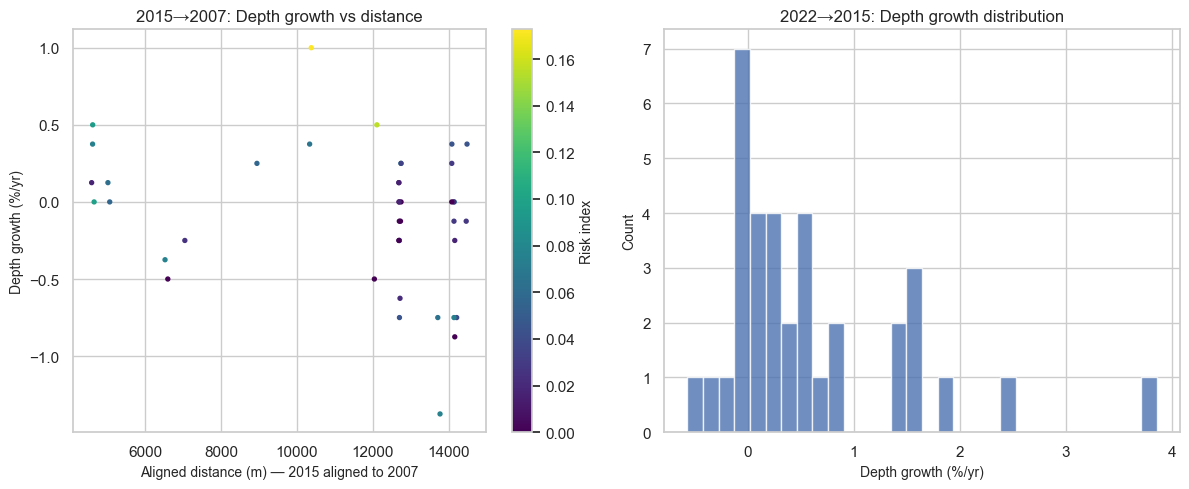

In [58]:
# Step 5: Results & usability — structured outputs and lightweight dashboard
from typing import Tuple

def build_final_results(matches_df: pd.DataFrame,
                        growth_df: pd.DataFrame,
                        dst_df: pd.DataFrame,
                        src_df: pd.DataFrame,
                        aligned_col: str,
                        label_dst: str,
                        label_src: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Prepare matches with categories
    m = matches_df.copy()
    m["confidence"] = m["score"].astype(float)
    # Enrich with basic dst/src info
    def take_cols(df: pd.DataFrame, idx: int) -> dict:
        row = df.loc[idx]
        return {
            "feature_type_norm": row.get("feature_type_norm"),
            "clock_deg_std": row.get("clock_deg_std"),
            "depth_percent_std": row.get("depth_percent_std"),
            "length_mm_std": row.get("length_mm_std"),
            "width_mm_std": row.get("width_mm_std"),
            "distance_m_std": row.get("distance_m_std"),
        }
    records = []
    growth_key = set(zip(growth_df.get("dst_id", pd.Series([], dtype=int)), growth_df.get("src_id", pd.Series([], dtype=int))))
    growth_map = {(int(r["dst_id"]), int(r["src_id"])): r for _, r in growth_df.iterrows()} if len(growth_df) else {}
    for _, r in m.iterrows():
        di = int(r["dst_id"]) ; si = int(r["src_id"]) ; cat = str(r.get("category"))
        dst_info = take_cols(dst_df, di)
        src_info = take_cols(src_df, si)
        out = {
            "pair": f"{label_dst}_to_{label_src}",
            "dst_id": di,
            "src_id": si,
            "category": cat,
            "confidence": float(r.get("confidence", np.nan)),
            "score": float(r.get("score", np.nan)),
            "dist_diff_m": float(r.get("dist_diff_m", np.nan)) if pd.notna(r.get("dist_diff_m", np.nan)) else np.nan,
            "clock_diff_deg": float(r.get("clock_diff_deg", np.nan)) if pd.notna(r.get("clock_diff_deg", np.nan)) else np.nan,
            # dst features
            "dst_type": dst_info["feature_type_norm"],
            "dst_clock_deg": dst_info["clock_deg_std"],
            "dst_depth_pct": dst_info["depth_percent_std"],
            "dst_length_mm": dst_info["length_mm_std"],
            "dst_width_mm": dst_info["width_mm_std"],
            "dst_distance_m_aligned": dst_df.loc[di].get(aligned_col, np.nan),
            # src features
            "src_type": src_info["feature_type_norm"],
            "src_clock_deg": src_info["clock_deg_std"],
            "src_depth_pct": src_info["depth_percent_std"],
            "src_length_mm": src_info["length_mm_std"],
            "src_width_mm": src_info["width_mm_std"],
            "src_distance_m": src_info["distance_m_std"],
        }
        if (di, si) in growth_key:
            g = growth_map[(di, si)]
            out.update({
                "years": float(g.get("years", np.nan)),
                "depth_growth_per_year": float(g.get("depth_growth_per_year", np.nan)),
                "length_growth_mm_per_year": float(g.get("length_growth_mm_per_year", np.nan)),
                "width_growth_mm_per_year": float(g.get("width_growth_mm_per_year", np.nan)),
                "risk_index": float(g.get("risk_index", np.nan)),
            })
        else:
            out.update({
                "years": np.nan,
                "depth_growth_per_year": np.nan,
                "length_growth_mm_per_year": np.nan,
                "width_growth_mm_per_year": np.nan,
                "risk_index": np.nan,
            })
        records.append(out)
    final_df = pd.DataFrame(records)
    # New defects: category == 'new'
    new_df = final_df[final_df["category"] == "new"][[
        "pair","dst_id","confidence","score","dst_type","dst_clock_deg","dst_depth_pct","dst_length_mm","dst_width_mm","dst_distance_m_aligned"
    ]].copy()
    # Missing defects: source anomalies not matched/uncertain
    matched_like = final_df[final_df["category"].isin(["matched","uncertain"])]
    matched_src_ids = set(matched_like["src_id"].astype(int).tolist())
    all_src_ids = set(src_df.index.astype(int).tolist())
    missing_ids = sorted(list(all_src_ids - matched_src_ids))
    miss_records = []
    for si in missing_ids:
        s = src_df.loc[si]
        miss_records.append({
            "pair": f"{label_dst}_to_{label_src}",
            "src_id": int(si),
            "src_type": s.get("feature_type_norm"),
            "src_clock_deg": s.get("clock_deg_std"),
            "src_depth_pct": s.get("depth_percent_std"),
            "src_length_mm": s.get("length_mm_std"),
            "src_width_mm": s.get("width_mm_std"),
            "src_distance_m": s.get("distance_m_std"),
        })
    missing_df = pd.DataFrame(miss_records)
    return final_df, new_df, missing_df

# Build final structured outputs
final_15_07, new_2015, missing_2007 = build_final_results(
    matches_15_07_df, growth_15_07, aligned_2015_to_2007_ransac, df_2007_std,
    aligned_col="distance_m_aligned_to_2007", label_dst="2015", label_src="2007"
)
final_22_15, new_2022, missing_2015 = build_final_results(
    matches_22_15_df, growth_22_15, aligned_2022_to_2015_ransac, df_2015_std,
    aligned_col="distance_m_aligned_to_2015", label_dst="2022", label_src="2015"
)

# Save consolidated datasets
final_15_07.to_csv(os.path.join(output_dir, "final_results_2015_to_2007.csv"), index=False)
final_22_15.to_csv(os.path.join(output_dir, "final_results_2022_to_2015.csv"), index=False)
new_2015.to_csv(os.path.join(output_dir, "new_defects_2015.csv"), index=False)
new_2022.to_csv(os.path.join(output_dir, "new_defects_2022.csv"), index=False)
missing_2007.to_csv(os.path.join(output_dir, "missing_defects_2007.csv"), index=False)
missing_2015.to_csv(os.path.join(output_dir, "missing_defects_2015.csv"), index=False)

with open(os.path.join(output_dir, "final_results_summary.json"), "w") as f:
    summary = {
        "2015_to_2007": {
            "rows": int(len(final_15_07)),
            "new": int(len(new_2015)),
            "missing_src": int(len(missing_2007)),
        },
        "2022_to_2015": {
            "rows": int(len(final_22_15)),
            "new": int(len(new_2022)),
            "missing_src": int(len(missing_2015)),
        }
    }
    json.dump(summary, f, indent=2)

print("Final structured outputs saved:")
print("- final_results_2015_to_2007.csv, final_results_2022_to_2015.csv")
print("- new_defects_2015.csv, new_defects_2022.csv")
print("- missing_defects_2007.csv, missing_defects_2015.csv")
print("- final_results_summary.json")

# Lightweight dashboard: growth scatter and histogram
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    x = final_15_07.get("dst_distance_m_aligned", pd.Series([]))
    y = final_15_07.get("depth_growth_per_year", pd.Series([]))
    c = final_15_07.get("risk_index", pd.Series([]))
    plt.scatter(x, y, c=c, cmap="viridis", s=8)
    plt.xlabel("Aligned distance (m) — 2015 aligned to 2007")
    plt.ylabel("Depth growth (%/yr)")
    plt.title("2015→2007: Depth growth vs distance")
    plt.colorbar(label="Risk index")

    plt.subplot(1,2,2)
    y2 = final_22_15.get("depth_growth_per_year", pd.Series([]))
    plt.hist(y2.dropna().values, bins=30, alpha=0.8)
    plt.xlabel("Depth growth (%/yr)")
    plt.ylabel("Count")
    plt.title("2022→2015: Depth growth distribution")
    plt.tight_layout()
    dash_path = os.path.join(output_dir, "dashboard_growth_overview.png")
    plt.savefig(dash_path, dpi=120)
    print("Dashboard image saved:", dash_path)
except Exception as e:
    print("[WARN] Dashboard generation failed:", e)


In [59]:
# Interactive dashboard (Plotly + ipywidgets)
import os
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import ipywidgets as widgets

pio.templates.default = "plotly_white"

# Resolve outputs directory
output_dir = os.path.join(os.getcwd(), "outputs")
os.makedirs(output_dir, exist_ok=True)

# Load final result tables if not already in memory
try:
    final_15_07
    final_22_15
except NameError:
    # Updated filenames to reflect src->dst orientation
    final_15_07 = pd.read_csv(os.path.join(output_dir, "final_results_2007_to_2015.csv"))
    final_22_15 = pd.read_csv(os.path.join(output_dir, "final_results_2015_to_2022.csv"))

# Ensure pair labels exist (src -> dst)
final_15_07["pair"] = "2007_to_2015"
final_22_15["pair"] = "2015_to_2022"
final_all = pd.concat([final_15_07, final_22_15], ignore_index=True)

# Coalesce type for filtering (dst_type preferred, fallback src_type)
final_all["type_norm"] = final_all["dst_type"].fillna(final_all["src_type"]).fillna("unknown")

# Default selections (updated options)
pair_dd = widgets.Dropdown(options=["2007_to_2015","2015_to_2022"], value="2007_to_2015", description="Run Pair")
type_sm = widgets.SelectMultiple(options=sorted(list(final_all["type_norm"].dropna().unique())), description="Type", rows=6)
min_conf = widgets.FloatSlider(value=0.6, min=0.0, max=1.0, step=0.05, description="Min Confidence")
cat_dd = widgets.Dropdown(options=["matched","uncertain","new","matched+uncertain"], value="matched", description="Category")
metric_dd = widgets.Dropdown(options=[
    ("Depth growth (%/yr)", "depth_growth_per_year"),
    ("Length growth (mm/yr)", "length_growth_mm_per_year"),
    ("Width growth (mm/yr)", "width_growth_mm_per_year")
], value="depth_growth_per_year", description="Metric")

out = widgets.Output()

METRICS = {
    "depth_growth_per_year": "Depth growth (%/yr)",
    "length_growth_mm_per_year": "Length growth (mm/yr)",
    "width_growth_mm_per_year": "Width growth (mm/yr)"
}

# Helper to filter
def filter_df():
    df = final_all.copy()
    df = df[df["pair"] == pair_dd.value]
    # Category
    if cat_dd.value == "matched+uncertain":
        df = df[df["category"].isin(["matched","uncertain"])]
    else:
        df = df[df["category"] == cat_dd.value]
    # Confidence
    df = df[df["confidence"].fillna(0.0) >= min_conf.value]
    # Types
    if len(type_sm.value) > 0:
        df = df[df["type_norm"].isin(list(type_sm.value))]
    return df

# Render function
def render(*args):
    with out:
        out.clear_output()
        df = filter_df()
        metric = metric_dd.value
        # Fallback if metric missing
        if metric not in df.columns:
            print("Metric not available in current selection.")
            display(df.head(5))
            return
        # Use aligned distance column consistently
        df["aligned_distance_m"] = df.get("dst_distance_m_aligned", np.nan)
        hover_cols = [
            "dst_id","src_id","type_norm","category","confidence","score","risk_index",
            "dst_depth_pct","dst_length_mm","dst_width_mm","src_depth_pct","src_length_mm","src_width_mm"
        ]
        # Notebook views
        fig_scatter = px.scatter(
            df,
            x="aligned_distance_m",
            y=metric,
            color="risk_index",
            color_continuous_scale="Viridis",
            hover_data={c: True for c in hover_cols},
            labels={"aligned_distance_m": "Aligned distance (m)", metric: metric.replace("_"," ")},
            title=f"{pair_dd.value}: {METRICS[metric]} vs distance"
        )
        fig_scatter.update_traces(marker=dict(size=9, opacity=0.85, line=dict(width=0)))
        fig_scatter.update_layout(height=520)
        fig_hist = px.histogram(
            df, x=metric, nbins=30, opacity=0.9,
            labels={metric: METRICS[metric]},
            title=f"{pair_dd.value}: {METRICS[metric]} distribution"
        )
        fig_hist.update_layout(height=520)
        display(fig_scatter)
        display(fig_hist)

        # Save interactive HTML snapshot with dropdown (single pair)
        try:
            html_path = os.path.join(output_dir, f"dashboard_interactive_{pair_dd.value}.html")
            combined = make_subplots(rows=1, cols=2, subplot_titles=(
                f"{pair_dd.value}: {METRICS[metric]} vs distance",
                f"{pair_dd.value}: {METRICS[metric]} distribution"
            ))
            # Build traces for all metrics, default visible = current metric
            all_traces = []
            default_metric = metric
            # Pre-compute counts for visibility logic
            sc_len = len(px.scatter(df, x="aligned_distance_m", y=list(METRICS.keys())[0], color="risk_index").data)
            hs_len = len(px.histogram(df, x=list(METRICS.keys())[0]).data)
            for mkey, mlabel in METRICS.items():
                sc = px.scatter(
                    df,
                    x="aligned_distance_m",
                    y=mkey,
                    color="risk_index",
                    color_continuous_scale="Viridis",
                    hover_data={c: True for c in hover_cols},
                )
                for tr in sc.data:
                    tr.visible = (mkey == default_metric)
                    combined.add_trace(tr, row=1, col=1)
                hs = px.histogram(df, x=mkey, nbins=30, opacity=0.9)
                for tr in hs.data:
                    tr.visible = (mkey == default_metric)
                    combined.add_trace(tr, row=1, col=2)
            total_traces = (sc_len + hs_len) * len(METRICS)
            # Dropdown to toggle metric
            buttons = []
            for i, (mkey, mlabel) in enumerate(METRICS.items()):
                visible = [False] * total_traces
                start_sc = i * sc_len
                for idx in range(start_sc, start_sc + sc_len):
                    visible[idx] = True
                start_hs = (len(METRICS) * sc_len) + i * hs_len
                for idx in range(start_hs, start_hs + hs_len):
                    visible[idx] = True
                buttons.append(dict(
                    label=mlabel,
                    method="update",
                    args=[{"visible": visible}]
                ))
            combined.update_layout(
                height=520, width=1100,
                xaxis=dict(title="Aligned distance (m)"),
                yaxis=dict(title=METRICS[default_metric]),
                xaxis2=dict(title=METRICS[default_metric]),
                updatemenus=[{
                    "type": "dropdown",
                    "direction": "down",
                    "buttons": buttons,
                    "x": 1.02,
                    "y": 1.0
                }]
            )
            pio.write_html(combined, file=html_path, auto_open=False, include_plotlyjs="cdn")
            print("Saved interactive HTML:", html_path)
        except Exception as e:
            print("[WARN] Failed to save combined HTML with dropdown:", e)

        # Save ALL-METRICS grid HTML (6 rows x 2 cols: both ranges)
        try:
            grid_path = os.path.join(output_dir, "dashboard_interactive_all_metrics_combined.html")
            grid = make_subplots(
                rows=6, cols=2, 
                subplot_titles=(
                    "2007→2015: Depth growth (%/yr) vs distance",
                    "2007→2015: Depth growth distribution",
                    "2007→2015: Length growth (mm/yr) vs distance",
                    "2007→2015: Length growth distribution",
                    "2007→2015: Width growth (mm/yr) vs distance",
                    "2007→2015: Width growth distribution",
                    "2015→2022: Depth growth (%/yr) vs distance",
                    "2015→2022: Depth growth distribution",
                    "2015→2022: Length growth (mm/yr) vs distance",
                    "2015→2022: Length growth distribution",
                    "2015→2022: Width growth (mm/yr) vs distance",
                    "2015→2022: Width growth distribution"
                ), 
                vertical_spacing=0.05,
                horizontal_spacing=0.15  # Clear gap between scatter and histogram
            )
            
            # Build data for both ranges
            df_07_15 = final_all[final_all["pair"] == "2007_to_2015"].copy()
            df_15_22 = final_all[final_all["pair"] == "2015_to_2022"].copy()
            df_07_15["aligned_distance_m"] = df_07_15.get("dst_distance_m_aligned", np.nan)
            df_15_22["aligned_distance_m"] = df_15_22.get("dst_distance_m_aligned", np.nan)
            
            # Define bin count options for interactive control
            bin_options = [20, 30, 50, 80]
            
            # Helper to add histogram traces with multiple bin counts
            def add_histogram_traces(df, column, row, col, bin_counts):
                for i, nbins in enumerate(bin_counts):
                    hs = px.histogram(df, x=column, nbins=nbins, opacity=0.9)
                    for tr in hs.data:
                        tr.visible = (nbins == 30)  # Default to 30 bins
                        tr.name = f"{nbins} bins"
                        grid.add_trace(tr, row=row, col=col)
            
            # 2007→2015: Depth
            sc1 = px.scatter(df_07_15, x="aligned_distance_m", y="depth_growth_per_year", color="risk_index", color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
            for tr in sc1.data:
                tr.marker.coloraxis = "coloraxis1"  # Individual color scale
                grid.add_trace(tr, row=1, col=1)
            add_histogram_traces(df_07_15, "depth_growth_per_year", 1, 2, bin_options)
            
            # 2007→2015: Length
            sc2 = px.scatter(df_07_15, x="aligned_distance_m", y="length_growth_mm_per_year", color="risk_index", color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
            for tr in sc2.data:
                tr.marker.coloraxis = "coloraxis2"  # Individual color scale
                grid.add_trace(tr, row=2, col=1)
            add_histogram_traces(df_07_15, "length_growth_mm_per_year", 2, 2, bin_options)
            
            # 2007→2015: Width
            sc3 = px.scatter(df_07_15, x="aligned_distance_m", y="width_growth_mm_per_year", color="risk_index", color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
            for tr in sc3.data:
                tr.marker.coloraxis = "coloraxis3"  # Individual color scale
                grid.add_trace(tr, row=3, col=1)
            add_histogram_traces(df_07_15, "width_growth_mm_per_year", 3, 2, bin_options)
            
            # 2015→2022: Depth
            sc4 = px.scatter(df_15_22, x="aligned_distance_m", y="depth_growth_per_year", color="risk_index", color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
            for tr in sc4.data:
                tr.marker.coloraxis = "coloraxis4"  # Individual color scale
                grid.add_trace(tr, row=4, col=1)
            add_histogram_traces(df_15_22, "depth_growth_per_year", 4, 2, bin_options)
            
            # 2015→2022: Length
            sc5 = px.scatter(df_15_22, x="aligned_distance_m", y="length_growth_mm_per_year", color="risk_index", color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
            for tr in sc5.data:
                tr.marker.coloraxis = "coloraxis5"  # Individual color scale
                grid.add_trace(tr, row=5, col=1)
            add_histogram_traces(df_15_22, "length_growth_mm_per_year", 5, 2, bin_options)
            
            # 2015→2022: Width
            sc6 = px.scatter(df_15_22, x="aligned_distance_m", y="width_growth_mm_per_year", color="risk_index", color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
            for tr in sc6.data:
                tr.marker.coloraxis = "coloraxis6"  # Individual color scale
                grid.add_trace(tr, row=6, col=1)
            add_histogram_traces(df_15_22, "width_growth_mm_per_year", 6, 2, bin_options)
            
            # Axis titles for all rows
            for row in range(1, 7):
                grid.update_xaxes(title_text="Aligned distance (m)", row=row, col=1)
                grid.update_xaxes(title_text="Growth metric", row=row, col=2)
            grid.update_yaxes(title_text="Depth (%/yr)", row=1, col=1)
            grid.update_yaxes(title_text="Length (mm/yr)", row=2, col=1)
            grid.update_yaxes(title_text="Width (mm/yr)", row=3, col=1)
            grid.update_yaxes(title_text="Depth (%/yr)", row=4, col=1)
            grid.update_yaxes(title_text="Length (mm/yr)", row=5, col=1)
            grid.update_yaxes(title_text="Width (mm/yr)", row=6, col=1)
            
            # Create buttons to toggle bin counts
            # We need to identify which traces are histograms (in col 2) vs scatter (col 1)
            # Scatter traces are added first for each row, then 4 histogram traces per row
            num_scatter_per_row = len(sc1.data)  # Usually 1, could be more if color creates multiple
            total_traces = len(grid.data)
            
            # Build visibility arrays for each bin count
            buttons = []
            for target_bins in bin_options:
                visibility = []
                trace_idx = 0
                for row in range(1, 7):
                    # Scatter traces for this row (always visible)
                    for _ in range(num_scatter_per_row):
                        visibility.append(True)
                        trace_idx += 1
                    # Histogram traces for this row (4 versions with different bins)
                    for bin_count in bin_options:
                        visibility.append(bin_count == target_bins)
                        trace_idx += 1
                
                buttons.append(dict(
                    label=f"{target_bins} bins",
                    method="update",
                    args=[{"visible": visibility}]
                ))
            
            grid.update_layout(
                height=2400, 
                width=1400,  # Increased width for better spacing
                showlegend=False,
                # Define 6 individual color axes for each scatter plot
                # Positioned tightly to the right edge of scatter plots (left column)
                coloraxis1=dict(
                    colorscale="Viridis", 
                    colorbar=dict(
                        x=0.42,  # Positioned at right edge of left subplot
                        y=0.9167, 
                        len=0.135, 
                        thickness=15,
                        title=dict(text="Risk", side="right"),
                        xanchor="left"  # Anchor to left edge of colorbar
                    )
                ),
                coloraxis2=dict(
                    colorscale="Viridis", 
                    colorbar=dict(
                        x=0.42, 
                        y=0.75, 
                        len=0.135, 
                        thickness=15,
                        title=dict(text="Risk", side="right"),
                        xanchor="left"
                    )
                ),
                coloraxis3=dict(
                    colorscale="Viridis", 
                    colorbar=dict(
                        x=0.42, 
                        y=0.5833, 
                        len=0.135, 
                        thickness=15,
                        title=dict(text="Risk", side="right"),
                        xanchor="left"
                    )
                ),
                coloraxis4=dict(
                    colorscale="Viridis", 
                    colorbar=dict(
                        x=0.42, 
                        y=0.4167, 
                        len=0.135, 
                        thickness=15,
                        title=dict(text="Risk", side="right"),
                        xanchor="left"
                    )
                ),
                coloraxis5=dict(
                    colorscale="Viridis", 
                    colorbar=dict(
                        x=0.42, 
                        y=0.25, 
                        len=0.135, 
                        thickness=15,
                        title=dict(text="Risk", side="right"),
                        xanchor="left"
                    )
                ),
                coloraxis6=dict(
                    colorscale="Viridis", 
                    colorbar=dict(
                        x=0.42, 
                        y=0.0833, 
                        len=0.135, 
                        thickness=15,
                        title=dict(text="Risk", side="right"),
                        xanchor="left"
                    )
                ),
                updatemenus=[
                    dict(
                        type="buttons",
                        direction="left",
                        buttons=buttons,
                        pad={"r": 10, "t": 10},
                        showactive=True,
                        x=0.0,
                        xanchor="left",
                        y=1.02,
                        yanchor="bottom"
                    )
                ]
            )
            pio.write_html(grid, file=grid_path, auto_open=False, include_plotlyjs="cdn")
            print("Saved combined all-metrics HTML:", grid_path)
        except Exception as e:
            print("[WARN] Failed to save all-metrics grid HTML:", e)

        # Top 25 table
        top = df.sort_values(by=["risk_index","confidence"], ascending=False).head(25)
        display(top[["dst_id","src_id","category","confidence","risk_index","type_norm",metric]].reset_index(drop=True))

# Wire up interactions
for w in [pair_dd, type_sm, min_conf, cat_dd, metric_dd]:
    w.observe(render, names="value")

# Initial render
render()

# Layout
ui = widgets.VBox([
    widgets.HBox([pair_dd, cat_dd, metric_dd]),
    widgets.HBox([min_conf, type_sm]),
    out
])
ui

In [64]:
# ILI Data Alignment Visualization
import plotly.graph_objects as go
import numpy as np

def create_ili_alignment_diagram(final_df, pair_name="2007_to_2015"):
    """
    Create an interactive ILI alignment diagram showing how features align across runs.
    Similar to the diagram in the problem statement.
    """
    
    # Filter for the specific pair
    matched_df = final_df[final_df["pair"] == pair_name].copy()
    
    # Determine years
    if pair_name == "2007_to_2015":
        src_year = "2007"
        dst_year = "2015"
    else:  # 2015_to_2022
        src_year = "2015"
        dst_year = "2022"
    
    # Sample some representative features for visualization (max 20 for clarity)
    if len(matched_df) > 20:
        # Get a diverse sample
        sample_matched = matched_df.sample(n=20, random_state=42).sort_values('src_distance_m')
    else:
        sample_matched = matched_df.copy().sort_values('src_distance_m')
    
    # Create figure
    fig = go.Figure()
    
    # Pipeline baseline positions (y-coordinates)
    y_run1 = 2
    y_run2 = 0.5
    
    # Get distance ranges
    src_distances = sample_matched['src_distance_m'].values
    dst_distances = sample_matched['dst_distance_m_aligned'].values
    
    min_dist = min(src_distances.min(), dst_distances.min()) - 1000
    max_dist = max(src_distances.max(), dst_distances.max()) + 1000
    
    # Draw pipelines (horizontal lines)
    fig.add_trace(go.Scatter(
        x=[min_dist, max_dist], y=[y_run1, y_run1],
        mode='lines',
        line=dict(color='#2c3e50', width=10),
        showlegend=False,
        hoverinfo='skip'
    ))
    
    fig.add_trace(go.Scatter(
        x=[min_dist, max_dist], y=[y_run2, y_run2],
        mode='lines',
        line=dict(color='#2c3e50', width=10),
        showlegend=False,
        hoverinfo='skip'
    ))
    
    # Add run labels with badges
    fig.add_annotation(
        x=min_dist - 800, y=y_run1,
        text=f"<b>ILI Run {src_year}</b>",
        showarrow=False,
        xanchor='right',
        bgcolor='#27ae60',
        bordercolor='white',
        borderwidth=2,
        borderpad=8,
        font=dict(size=14, color='white', family='Arial')
    )
    
    fig.add_annotation(
        x=min_dist - 800, y=y_run2,
        text=f"<b>ILI Run {dst_year}</b>",
        showarrow=False,
        xanchor='right',
        bgcolor='#e67e22',
        bordercolor='white',
        borderwidth=2,
        borderpad=8,
        font=dict(size=14, color='white', family='Arial')
    )
    
    # Symbol mapping for feature types
    type_symbols = {
        'Anomaly': 'circle',
        'Bend': 'diamond',
        'Valve': 'star',
        'Tee': 'hexagon',
        'Girth Weld': 'square',
        'unknown': 'circle'
    }
    
    # Color by confidence/risk
    def get_color(confidence):
        if confidence >= 0.8:
            return '#27ae60'  # green - high confidence
        elif confidence >= 0.5:
            return '#f39c12'  # orange - medium
        else:
            return '#e74c3c'  # red - low confidence
    
    # Plot features on both runs
    for idx, row in sample_matched.iterrows():
        src_dist = row['src_distance_m']
        dst_dist = row['dst_distance_m_aligned']
        feature_type = row.get('type_norm', 'unknown')
        confidence = row.get('confidence', 0.5)
        
        color = get_color(confidence)
        symbol = type_symbols.get(feature_type, 'circle')
        
        # Feature on source run
        fig.add_trace(go.Scatter(
            x=[src_dist], y=[y_run1],
            mode='markers',
            marker=dict(
                size=14,
                color=color,
                symbol=symbol,
                line=dict(color='white', width=2)
            ),
            showlegend=False,
            hovertemplate=(
                f"<b>{src_year} Run</b><br>" +
                f"Type: {feature_type}<br>" +
                f"Distance: {src_dist:.0f}m<br>" +
                f"ID: {row.get('src_id', 'N/A')}<br>" +
                f"Confidence: {confidence:.2f}<br>" +
                "<extra></extra>"
            )
        ))
        
        # Feature on destination run
        fig.add_trace(go.Scatter(
            x=[dst_dist], y=[y_run2],
            mode='markers',
            marker=dict(
                size=14,
                color=color,
                symbol=symbol,
                line=dict(color='white', width=2)
            ),
            showlegend=False,
            hovertemplate=(
                f"<b>{dst_year} Run</b><br>" +
                f"Type: {feature_type}<br>" +
                f"Aligned Distance: {dst_dist:.0f}m<br>" +
                f"ID: {row.get('dst_id', 'N/A')}<br>" +
                f"Confidence: {confidence:.2f}<br>" +
                "<extra></extra>"
            )
        ))
        
        # Draw alignment line (dashed line connecting matched features)
        fig.add_trace(go.Scatter(
            x=[src_dist, dst_dist],
            y=[y_run1 - 0.1, y_run2 + 0.1],
            mode='lines',
            line=dict(color=color, width=1.5, dash='dot'),
            showlegend=False,
            opacity=0.5,
            hoverinfo='skip'
        ))
    
    # Add legend manually for confidence levels
    legend_items = [
        ('High Confidence (≥0.8)', '#27ae60'),
        ('Medium Confidence (0.5-0.8)', '#f39c12'),
        ('Low Confidence (<0.5)', '#e74c3c'),
    ]
    
    for label, color in legend_items:
        fig.add_trace(go.Scatter(
            x=[None], y=[None],
            mode='markers',
            marker=dict(size=12, color=color, line=dict(color='white', width=2)),
            name=label,
            showlegend=True
        ))
    
    # Add feature type symbols to legend
    common_types = ['Anomaly', 'Bend', 'Valve', 'Girth Weld']
    for ftype in common_types:
        if ftype in sample_matched['type_norm'].values:
            fig.add_trace(go.Scatter(
                x=[None], y=[None],
                mode='markers',
                marker=dict(size=12, color='gray', symbol=type_symbols.get(ftype, 'circle'), 
                           line=dict(color='white', width=2)),
                name=ftype,
                showlegend=True
            ))
    
    # Update layout
    fig.update_layout(
        title=dict(
            text=f"<b>ILI Data Alignment: {src_year} → {dst_year}</b><br>" +
                 "<sub>Same pipeline features appear at different reported locations in each ILI run</sub>",
            x=0.5,
            xanchor='center',
            font=dict(size=20, family='Arial')
        ),
        xaxis=dict(
            title="<b>Distance along pipeline (m)</b>",
            showgrid=True,
            gridcolor='lightgray',
            zeroline=False
        ),
        yaxis=dict(
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            range=[y_run2 - 0.8, y_run1 + 0.8]
        ),
        height=600,
        width=1400,
        plot_bgcolor='#f8f9fa',
        paper_bgcolor='white',
        hovermode='closest',
        legend=dict(
            title=dict(text="<b>Alignment Legend</b>", font=dict(size=14)),
            orientation="h",
            yanchor="top",
            y=-0.15,
            xanchor="center",
            x=0.5,
            bgcolor="rgba(255,255,255,0.95)",
            bordercolor="#2c3e50",
            borderwidth=2,
            font=dict(size=11)
        ),
        margin=dict(l=150, r=50, t=100, b=120)
    )
    
    return fig

# Generate for both pairs
print("Generating ILI alignment diagrams...")

try:
    # Load the final data
    if 'final_all' not in globals():
        final_07_15 = pd.read_csv(os.path.join(output_dir, "final_results_2007_to_2015.csv"))
        final_15_22 = pd.read_csv(os.path.join(output_dir, "final_results_2015_to_2022.csv"))
        final_all = pd.concat([final_07_15, final_15_22], ignore_index=True)
        print("Loaded final results from CSV files")
    
    # 2007 to 2015 alignment
    fig_07_15 = create_ili_alignment_diagram(final_all, "2007_to_2015")
    alignment_path_07_15 = os.path.join(output_dir, "ili_alignment_2007_to_2015.html")
    pio.write_html(fig_07_15, file=alignment_path_07_15, auto_open=False, include_plotlyjs="cdn")
    print(f"✓ Saved: {alignment_path_07_15}")
    
    # 2015 to 2022 alignment
    fig_15_22 = create_ili_alignment_diagram(final_all, "2015_to_2022")
    alignment_path_15_22 = os.path.join(output_dir, "ili_alignment_2015_to_2022.html")
    pio.write_html(fig_15_22, file=alignment_path_15_22, auto_open=False, include_plotlyjs="cdn")
    print(f"✓ Saved: {alignment_path_15_22}")
    
    print("\n📊 ILI Alignment Diagrams Generated!")
    print(f"   • {alignment_path_07_15}")
    print(f"   • {alignment_path_15_22}")
    
except Exception as e:
    print(f"Error generating alignment diagrams: {e}")
    import traceback
    traceback.print_exc()

Generating ILI alignment diagrams...
✓ Saved: /Users/satvikaakati/Desktop/Hack/outputs/ili_alignment_2007_to_2015.html
✓ Saved: /Users/satvikaakati/Desktop/Hack/outputs/ili_alignment_2015_to_2022.html

📊 ILI Alignment Diagrams Generated!
   • /Users/satvikaakati/Desktop/Hack/outputs/ili_alignment_2007_to_2015.html
   • /Users/satvikaakati/Desktop/Hack/outputs/ili_alignment_2015_to_2022.html


## AI-Powered Summary Generation

Generate natural language summaries of the matched anomalies using an LLM.

In [66]:
# LLM-based Anomaly Summary Generator
from openai import OpenAI
import json

def generate_anomaly_summary(pair_name="2007_to_2015"):
    """
    Generate natural language summary of matched anomalies using OpenAI GPT.
    """
    
    # Filter data for the specific pair
    df_pair = final_all[final_all["pair"] == pair_name].copy()
    
    # Calculate statistics for each growth metric
    stats = {}
    
    for metric, display_name in [
        ('depth_growth_per_year', 'Depth Growth'),
        ('length_growth_mm_per_year', 'Length Growth'),
        ('width_growth_mm_per_year', 'Width Growth')
    ]:
        metric_data = df_pair[metric].dropna()
        
        # Calculate high risk count
        if 'risk_index' in df_pair.columns:
            risk_threshold = df_pair['risk_index'].quantile(0.75)
            high_risk_count = int((df_pair[df_pair[metric].notna()]['risk_index'] >= risk_threshold).sum())
        else:
            high_risk_count = 0
        
        stats[display_name] = {
            'count': len(metric_data),
            'mean': float(metric_data.mean()),
            'median': float(metric_data.median()),
            'std': float(metric_data.std()),
            'min': float(metric_data.min()),
            'max': float(metric_data.max()),
            'positive_growth': int((metric_data > 0).sum()),
            'negative_growth': int((metric_data < 0).sum()),
            'stable': int((metric_data.abs() < 0.01).sum()),
            'high_risk': high_risk_count
        }
    
    # Get category breakdown
    if 'category' in df_pair.columns:
        category_counts = df_pair['category'].value_counts().to_dict()
    else:
        category_counts = {'matched': len(df_pair)}
    
    # Get feature type breakdown
    if 'type_norm' in df_pair.columns:
        type_counts = df_pair['type_norm'].value_counts().head(5).to_dict()
    else:
        type_counts = {}
    
    # Construct prompt for LLM
    prompt = f"""You are a pipeline integrity expert analyzing ILI (In-Line Inspection) data comparing runs from {pair_name.replace('_to_', ' to ')}.

Here are the key statistics for matched anomalies:

**Overall Matched Features:** {len(df_pair)} anomalies

**Category Breakdown:**
{json.dumps(category_counts, indent=2)}

**Feature Types:**
{json.dumps(type_counts, indent=2)}

**Growth Metrics Statistics:**

{json.dumps(stats, indent=2)}

Please provide a comprehensive but concise summary (2-3 paragraphs) that:
1. Explains the overall anomaly growth trends across depth, length, and width
2. Highlights any concerning patterns (e.g., predominantly positive growth indicating deterioration)
3. Identifies which dimension shows the most significant changes
4. Mentions the confidence/risk level of matches
5. Provides practical recommendations for pipeline operators

Write in clear, non-technical language suitable for pipeline managers and operators."""

    return prompt, stats

def call_openai_summary(prompt, api_key=None):
    """
    Call OpenAI API to generate summary.
    """
    try:
        # Initialize OpenAI client
        if api_key:
            client = OpenAI(api_key=api_key)
        else:
            # Try to use environment variable
            client = OpenAI()
        
        # Call GPT-4 (or fallback to GPT-3.5)
        response = client.chat.completions.create(
            model="gpt-4o-mini",  # Using gpt-4o-mini for cost efficiency
            messages=[
                {"role": "system", "content": "You are a pipeline integrity expert who explains technical data in clear, actionable language."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=800
        )
        
        return response.choices[0].message.content
    
    except Exception as e:
        return f"Error calling OpenAI API: {str(e)}\n\nPlease ensure your OpenAI API key is set in the environment variable OPENAI_API_KEY or pass it directly."

# Generate summaries for both periods
print("=" * 80)
print("GENERATING AI-POWERED ANOMALY SUMMARIES")
print("=" * 80)

try:
    # Load data if needed
    if 'final_all' not in globals():
        final_07_15 = pd.read_csv(os.path.join(output_dir, "final_results_2007_to_2015.csv"))
        final_15_22 = pd.read_csv(os.path.join(output_dir, "final_results_2015_to_2022.csv"))
        final_all = pd.concat([final_07_15, final_15_22], ignore_index=True)
        print("✓ Loaded final results from CSV files\n")
    
    # Check for OpenAI API key
    import os
    if not os.getenv('OPENAI_API_KEY'):
        print("⚠️  Warning: OPENAI_API_KEY environment variable not set.")
        print("   You can set it by running: export OPENAI_API_KEY='your-api-key-here'")
        print("   Or pass it directly to the call_openai_summary() function.\n")
        print("   Get your API key from: https://platform.openai.com/api-keys\n")
    
    summaries = {}
    
    # Generate summary for 2007 to 2015
    print("\n" + "=" * 80)
    print("📊 PERIOD 1: 2007 to 2015 Analysis")
    print("=" * 80)
    prompt_07_15, stats_07_15 = generate_anomaly_summary("2007_to_2015")
    
    print("\n🤖 Calling OpenAI GPT for summary generation...")
    summary_07_15 = call_openai_summary(prompt_07_15)
    print("\n📝 AI SUMMARY:\n")
    print(summary_07_15)
    summaries['2007_to_2015'] = {
        'summary': summary_07_15,
        'stats': stats_07_15
    }
    
    # Generate summary for 2015 to 2022
    print("\n\n" + "=" * 80)
    print("📊 PERIOD 2: 2015 to 2022 Analysis")
    print("=" * 80)
    prompt_15_22, stats_15_22 = generate_anomaly_summary("2015_to_2022")
    
    print("\n🤖 Calling OpenAI GPT for summary generation...")
    summary_15_22 = call_openai_summary(prompt_15_22)
    print("\n📝 AI SUMMARY:\n")
    print(summary_15_22)
    summaries['2015_to_2022'] = {
        'summary': summary_15_22,
        'stats': stats_15_22
    }
    
    # Save summaries to file
    summary_output = os.path.join(output_dir, "ai_anomaly_summaries.json")
    with open(summary_output, 'w') as f:
        json.dump(summaries, f, indent=2)
    
    # Also save as readable text file
    text_output = os.path.join(output_dir, "ai_anomaly_summaries.txt")
    with open(text_output, 'w') as f:
        f.write("=" * 80 + "\n")
        f.write("AI-POWERED ANOMALY ANALYSIS SUMMARIES\n")
        f.write("=" * 80 + "\n\n")
        
        f.write("PERIOD 1: 2007 to 2015\n")
        f.write("-" * 80 + "\n")
        f.write(summary_07_15 + "\n\n")
        
        f.write("=" * 80 + "\n\n")
        
        f.write("PERIOD 2: 2015 to 2022\n")
        f.write("-" * 80 + "\n")
        f.write(summary_15_22 + "\n\n")
        
        f.write("=" * 80 + "\n")
        f.write("Generated using OpenAI GPT-4o-mini\n")
    
    print("\n\n" + "=" * 80)
    print("✅ SUMMARIES SAVED")
    print("=" * 80)
    print(f"📄 JSON: {summary_output}")
    print(f"📄 Text: {text_output}")
    
except Exception as e:
    print(f"\n❌ Error generating summaries: {e}")
    import traceback
    traceback.print_exc()
    print("\nNote: Make sure you have the OpenAI Python package installed:")
    print("  pip install openai")

GENERATING AI-POWERED ANOMALY SUMMARIES
⚠️  Warning: OPENAI_API_KEY environment variable not set.
   You can set it by running: export OPENAI_API_KEY='your-api-key-here'
   Or pass it directly to the call_openai_summary() function.

   Get your API key from: https://platform.openai.com/api-keys


📊 PERIOD 1: 2007 to 2015 Analysis

🤖 Calling OpenAI GPT for summary generation...

📝 AI SUMMARY:

Error calling OpenAI API: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

Please ensure your OpenAI API key is set in the environment variable OPENAI_API_KEY or pass it directly.


📊 PERIOD 2: 2015 to 2022 Analysis

🤖 Calling OpenAI GPT for summary generation...

📝 AI SUMMARY:

Error calling OpenAI API: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

Please ensure your OpenAI API key is set in the environment variable OPENAI_API_K

In [67]:
# Alternative: Generate summaries without external API (rule-based)
def generate_local_summary(pair_name="2007_to_2015"):
    """
    Generate summary using local rules (no API needed).
    """
    
    # Filter data for the specific pair
    df_pair = final_all[final_all["pair"] == pair_name].copy()
    
    # Determine years
    years = pair_name.replace('_to_', ' to ')
    
    # Calculate statistics
    depth_data = df_pair['depth_growth_per_year'].dropna()
    length_data = df_pair['length_growth_mm_per_year'].dropna()
    width_data = df_pair['width_growth_mm_per_year'].dropna()
    
    summary = f"""Pipeline Integrity Analysis: {years}

📊 Overview:
During the {years} inspection period, {len(df_pair)} pipeline anomalies were successfully matched and tracked across both ILI runs.

🔍 Depth Growth Analysis:
"""
    
    # Depth analysis
    depth_mean = depth_data.mean()
    depth_positive = (depth_data > 0).sum()
    depth_negative = (depth_data < 0).sum()
    depth_pct_growing = (depth_positive / len(depth_data) * 100) if len(depth_data) > 0 else 0
    
    if depth_mean > 0.1:
        summary += f"• CONCERN: Average depth is growing at {depth_mean:.2f}% per year\n"
        summary += f"• {depth_positive} anomalies ({depth_pct_growing:.1f}%) show depth increase (deterioration)\n"
    elif depth_mean < -0.1:
        summary += f"• POSITIVE: Average depth is decreasing at {abs(depth_mean):.2f}% per year\n"
        summary += f"• {depth_negative} anomalies show depth decrease (possible measurement variation)\n"
    else:
        summary += f"• STABLE: Average depth change is minimal ({depth_mean:.2f}% per year)\n"
    
    summary += f"• Range: {depth_data.min():.2f}% to {depth_data.max():.2f}% per year\n\n"
    
    # Length analysis
    length_mean = length_data.mean()
    length_positive = (length_data > 0).sum()
    length_pct_growing = (length_positive / len(length_data) * 100) if len(length_data) > 0 else 0
    
    summary += f"📏 Length Growth Analysis:\n"
    if length_mean > 0.5:
        summary += f"• CONCERN: Average length is growing at {length_mean:.2f} mm per year\n"
        summary += f"• {length_positive} anomalies ({length_pct_growing:.1f}%) show length increase\n"
    elif length_mean < -0.5:
        summary += f"• Average length is decreasing at {abs(length_mean):.2f} mm per year\n"
    else:
        summary += f"• STABLE: Average length change is minimal ({length_mean:.2f} mm per year)\n"
    
    summary += f"• Range: {length_data.min():.2f} to {length_data.max():.2f} mm per year\n\n"
    
    # Width analysis
    width_mean = width_data.mean()
    width_positive = (width_data > 0).sum()
    width_pct_growing = (width_positive / len(width_data) * 100) if len(width_data) > 0 else 0
    
    summary += f"📐 Width Growth Analysis:\n"
    if width_mean > 0.5:
        summary += f"• CONCERN: Average width is growing at {width_mean:.2f} mm per year\n"
        summary += f"• {width_positive} anomalies ({width_pct_growing:.1f}%) show width increase\n"
    elif width_mean < -0.5:
        summary += f"• Average width is decreasing at {abs(width_mean):.2f} mm per year\n"
    else:
        summary += f"• STABLE: Average width change is minimal ({width_mean:.2f} mm per year)\n"
    
    summary += f"• Range: {width_data.min():.2f} to {width_data.max():.2f} mm per year\n\n"
    
    # Risk assessment
    if 'risk_index' in df_pair.columns:
        high_risk = (df_pair['risk_index'] >= df_pair['risk_index'].quantile(0.75)).sum()
        summary += f"⚠️ Risk Assessment:\n"
        summary += f"• {high_risk} anomalies ({high_risk/len(df_pair)*100:.1f}%) are classified as high-risk\n"
        summary += f"• Average risk index: {df_pair['risk_index'].mean():.3f}\n\n"
    
    # Recommendations
    summary += f"💡 Recommendations:\n"
    
    if depth_mean > 0.1 or length_mean > 0.5 or width_mean > 0.5:
        summary += "• PRIORITY ACTION: Investigate growing anomalies for potential repair\n"
        summary += "• Increase inspection frequency for high-risk areas\n"
        summary += "• Consider integrity assessment for anomalies with >20% depth growth\n"
    else:
        summary += "• Continue regular monitoring schedule\n"
        summary += "• Focus on anomalies showing accelerating growth trends\n"
    
    # Feature type breakdown
    if 'type_norm' in df_pair.columns:
        top_types = df_pair['type_norm'].value_counts().head(3)
        summary += f"\n📋 Most Common Features:\n"
        for ftype, count in top_types.items():
            summary += f"• {ftype}: {count} ({count/len(df_pair)*100:.1f}%)\n"
    
    return summary

print("\n" + "=" * 80)
print("GENERATING LOCAL SUMMARIES (No API required)")
print("=" * 80)

try:
    # Generate summaries for both periods
    summary_07_15_local = generate_local_summary("2007_to_2015")
    summary_15_22_local = generate_local_summary("2015_to_2022")
    
    print("\n" + "=" * 80)
    print("📊 PERIOD 1: 2007 to 2015")
    print("=" * 80)
    print(summary_07_15_local)
    
    print("\n" + "=" * 80)
    print("📊 PERIOD 2: 2015 to 2022")
    print("=" * 80)
    print(summary_15_22_local)
    
    # Save local summaries
    local_output = os.path.join(output_dir, "anomaly_summaries_local.txt")
    with open(local_output, 'w') as f:
        f.write("=" * 80 + "\n")
        f.write("PIPELINE ANOMALY ANALYSIS SUMMARIES\n")
        f.write("=" * 80 + "\n\n")
        
        f.write("PERIOD 1: 2007 to 2015\n")
        f.write("=" * 80 + "\n")
        f.write(summary_07_15_local + "\n\n")
        
        f.write("\n" + "=" * 80 + "\n\n")
        
        f.write("PERIOD 2: 2015 to 2022\n")
        f.write("=" * 80 + "\n")
        f.write(summary_15_22_local + "\n\n")
    
    print("\n" + "=" * 80)
    print("✅ LOCAL SUMMARY SAVED")
    print("=" * 80)
    print(f"📄 {local_output}")
    
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()


GENERATING LOCAL SUMMARIES (No API required)

📊 PERIOD 1: 2007 to 2015
Pipeline Integrity Analysis: 2007 to 2015

📊 Overview:
During the 2007 to 2015 inspection period, 1723 pipeline anomalies were successfully matched and tracked across both ILI runs.

🔍 Depth Growth Analysis:
• STABLE: Average depth change is minimal (-0.10% per year)
• Range: -1.38% to 1.00% per year

📏 Length Growth Analysis:
• Average length is decreasing at 0.63 mm per year
• Range: -8.13 to 2.60 mm per year

📐 Width Growth Analysis:
• STABLE: Average width change is minimal (0.18 mm per year)
• Range: -26.83 to 4.86 mm per year

⚠️ Risk Assessment:
• 11 anomalies (0.6%) are classified as high-risk
• Average risk index: 0.042

💡 Recommendations:
• Continue regular monitoring schedule
• Focus on anomalies showing accelerating growth trends

📋 Most Common Features:
• weld: 1305 (75.7%)
• corrosion: 215 (12.5%)
• cluster: 161 (9.3%)


📊 PERIOD 2: 2015 to 2022
Pipeline Integrity Analysis: 2015 to 2022

📊 Overview:
D

In [68]:
# Generate Web Dashboard with Summaries
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def create_dashboard_with_summary():
    """
    Create a comprehensive web dashboard with AI summaries and visualizations.
    """
    
    # Generate summaries for both periods
    summary_07_15 = generate_local_summary("2007_to_2015")
    summary_15_22 = generate_local_summary("2015_to_2022")
    
    # Create the main visualization (combined grid)
    df_07_15 = final_all[final_all["pair"] == "2007_to_2015"].copy()
    df_15_22 = final_all[final_all["pair"] == "2015_to_2022"].copy()
    df_07_15["aligned_distance_m"] = df_07_15.get("dst_distance_m_aligned", np.nan)
    df_15_22["aligned_distance_m"] = df_15_22.get("dst_distance_m_aligned", np.nan)
    
    hover_cols = ["dst_id", "src_id", "category", "confidence", "type_norm", "risk_index",
                  "src_depth", "dst_depth", "src_length", "dst_length", "src_width", "dst_width"]
    hover_cols = [c for c in hover_cols if c in df_07_15.columns]
    
    # Define bin count options
    bin_options = [20, 30, 50, 80]
    
    # Helper to add histogram traces with multiple bin counts
    def add_histogram_traces(df, column, row, col, bin_counts):
        for i, nbins in enumerate(bin_counts):
            hs = px.histogram(df, x=column, nbins=nbins, opacity=0.9)
            for tr in hs.data:
                tr.visible = (nbins == 30)  # Default to 30 bins
                tr.name = f"{nbins} bins"
                grid.add_trace(tr, row=row, col=col)
    
    # Create subplot grid
    grid = make_subplots(
        rows=6, cols=2,
        subplot_titles=(
            "2007→2015: Depth growth (%/yr) vs distance",
            "2007→2015: Depth growth distribution",
            "2007→2015: Length growth (mm/yr) vs distance",
            "2007→2015: Length growth distribution",
            "2007→2015: Width growth (mm/yr) vs distance",
            "2007→2015: Width growth distribution",
            "2015→2022: Depth growth (%/yr) vs distance",
            "2015→2022: Depth growth distribution",
            "2015→2022: Length growth (mm/yr) vs distance",
            "2015→2022: Length growth distribution",
            "2015→2022: Width growth (mm/yr) vs distance",
            "2015→2022: Width growth distribution"
        ),
        vertical_spacing=0.05,
        horizontal_spacing=0.15
    )
    
    # Add all traces (2007→2015)
    sc1 = px.scatter(df_07_15, x="aligned_distance_m", y="depth_growth_per_year", color="risk_index", 
                     color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
    for tr in sc1.data:
        tr.marker.coloraxis = "coloraxis1"
        grid.add_trace(tr, row=1, col=1)
    add_histogram_traces(df_07_15, "depth_growth_per_year", 1, 2, bin_options)
    
    sc2 = px.scatter(df_07_15, x="aligned_distance_m", y="length_growth_mm_per_year", color="risk_index",
                     color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
    for tr in sc2.data:
        tr.marker.coloraxis = "coloraxis2"
        grid.add_trace(tr, row=2, col=1)
    add_histogram_traces(df_07_15, "length_growth_mm_per_year", 2, 2, bin_options)
    
    sc3 = px.scatter(df_07_15, x="aligned_distance_m", y="width_growth_mm_per_year", color="risk_index",
                     color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
    for tr in sc3.data:
        tr.marker.coloraxis = "coloraxis3"
        grid.add_trace(tr, row=3, col=1)
    add_histogram_traces(df_07_15, "width_growth_mm_per_year", 3, 2, bin_options)
    
    # Add all traces (2015→2022)
    sc4 = px.scatter(df_15_22, x="aligned_distance_m", y="depth_growth_per_year", color="risk_index",
                     color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
    for tr in sc4.data:
        tr.marker.coloraxis = "coloraxis4"
        grid.add_trace(tr, row=4, col=1)
    add_histogram_traces(df_15_22, "depth_growth_per_year", 4, 2, bin_options)
    
    sc5 = px.scatter(df_15_22, x="aligned_distance_m", y="length_growth_mm_per_year", color="risk_index",
                     color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
    for tr in sc5.data:
        tr.marker.coloraxis = "coloraxis5"
        grid.add_trace(tr, row=5, col=1)
    add_histogram_traces(df_15_22, "length_growth_mm_per_year", 5, 2, bin_options)
    
    sc6 = px.scatter(df_15_22, x="aligned_distance_m", y="width_growth_mm_per_year", color="risk_index",
                     color_continuous_scale="Viridis", hover_data={c: True for c in hover_cols})
    for tr in sc6.data:
        tr.marker.coloraxis = "coloraxis6"
        grid.add_trace(tr, row=6, col=1)
    add_histogram_traces(df_15_22, "width_growth_mm_per_year", 6, 2, bin_options)
    
    # Update axes
    for row in range(1, 7):
        grid.update_xaxes(title_text="Aligned distance (m)", row=row, col=1)
        grid.update_xaxes(title_text="Growth metric", row=row, col=2)
    grid.update_yaxes(title_text="Depth (%/yr)", row=1, col=1)
    grid.update_yaxes(title_text="Length (mm/yr)", row=2, col=1)
    grid.update_yaxes(title_text="Width (mm/yr)", row=3, col=1)
    grid.update_yaxes(title_text="Depth (%/yr)", row=4, col=1)
    grid.update_yaxes(title_text="Length (mm/yr)", row=5, col=1)
    grid.update_yaxes(title_text="Width (mm/yr)", row=6, col=1)
    
    # Build visibility arrays for bin count buttons
    num_scatter_per_row = len(sc1.data)
    buttons = []
    for target_bins in bin_options:
        visibility = []
        for row in range(1, 7):
            for _ in range(num_scatter_per_row):
                visibility.append(True)
            for bin_count in bin_options:
                visibility.append(bin_count == target_bins)
        buttons.append(dict(
            label=f"{target_bins} bins",
            method="update",
            args=[{"visible": visibility}]
        ))
    
    # Update layout with color axes and buttons
    grid.update_layout(
        height=2400,
        width=1400,
        showlegend=False,
        coloraxis1=dict(colorscale="Viridis", colorbar=dict(x=0.42, y=0.9167, len=0.135, thickness=15, title=dict(text="Risk", side="right"), xanchor="left")),
        coloraxis2=dict(colorscale="Viridis", colorbar=dict(x=0.42, y=0.75, len=0.135, thickness=15, title=dict(text="Risk", side="right"), xanchor="left")),
        coloraxis3=dict(colorscale="Viridis", colorbar=dict(x=0.42, y=0.5833, len=0.135, thickness=15, title=dict(text="Risk", side="right"), xanchor="left")),
        coloraxis4=dict(colorscale="Viridis", colorbar=dict(x=0.42, y=0.4167, len=0.135, thickness=15, title=dict(text="Risk", side="right"), xanchor="left")),
        coloraxis5=dict(colorscale="Viridis", colorbar=dict(x=0.42, y=0.25, len=0.135, thickness=15, title=dict(text="Risk", side="right"), xanchor="left")),
        coloraxis6=dict(colorscale="Viridis", colorbar=dict(x=0.42, y=0.0833, len=0.135, thickness=15, title=dict(text="Risk", side="right"), xanchor="left")),
        updatemenus=[dict(type="buttons", direction="left", buttons=buttons, pad={"r": 10, "t": 10}, showactive=True, x=0.0, xanchor="left", y=1.02, yanchor="bottom")]
    )
    
    # Convert plot to HTML
    plot_html = pio.to_html(grid, include_plotlyjs='cdn', full_html=False)
    
    # Create full HTML with summary
    html_content = f"""
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>ILI Pipeline Anomaly Analysis Dashboard</title>
    <style>
        body {{
            font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
            margin: 0;
            padding: 0;
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: #333;
        }}
        .header {{
            background: white;
            padding: 30px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
            text-align: center;
        }}
        .header h1 {{
            margin: 0;
            color: #2c3e50;
            font-size: 2.5em;
            font-weight: 700;
        }}
        .header p {{
            margin: 10px 0 0 0;
            color: #7f8c8d;
            font-size: 1.1em;
        }}
        .container {{
            max-width: 1450px;
            margin: 20px auto;
            padding: 0 20px;
        }}
        .summary-section {{
            background: white;
            border-radius: 15px;
            padding: 30px;
            margin-bottom: 20px;
            box-shadow: 0 5px 20px rgba(0,0,0,0.15);
        }}
        .summary-header {{
            display: flex;
            align-items: center;
            margin-bottom: 20px;
            padding-bottom: 15px;
            border-bottom: 3px solid #667eea;
        }}
        .summary-header h2 {{
            margin: 0;
            color: #2c3e50;
            font-size: 1.8em;
            flex: 1;
        }}
        .period-badge {{
            background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
            color: white;
            padding: 8px 20px;
            border-radius: 25px;
            font-weight: 600;
            font-size: 0.9em;
        }}
        .summary-content {{
            line-height: 1.8;
            font-size: 1.05em;
            color: #34495e;
            white-space: pre-wrap;
        }}
        .summary-grid {{
            display: grid;
            grid-template-columns: 1fr 1fr;
            gap: 20px;
            margin-bottom: 20px;
        }}
        @media (max-width: 900px) {{
            .summary-grid {{
                grid-template-columns: 1fr;
            }}
        }}
        .viz-section {{
            background: white;
            border-radius: 15px;
            padding: 30px;
            box-shadow: 0 5px 20px rgba(0,0,0,0.15);
        }}
        .viz-header {{
            margin-bottom: 20px;
            padding-bottom: 15px;
            border-bottom: 3px solid #667eea;
        }}
        .viz-header h2 {{
            margin: 0;
            color: #2c3e50;
            font-size: 1.8em;
        }}
        .viz-header p {{
            margin: 10px 0 0 0;
            color: #7f8c8d;
        }}
        .footer {{
            background: white;
            text-align: center;
            padding: 20px;
            margin-top: 20px;
            color: #7f8c8d;
            border-radius: 15px;
        }}
    </style>
</head>
<body>
    <div class="header">
        <h1>🛢️ ILI Pipeline Anomaly Analysis Dashboard</h1>
        <p>Comprehensive analysis of pipeline integrity data across multiple inspection runs</p>
    </div>
    
    <div class="container">
        <!-- Summary Section -->
        <div class="summary-grid">
            <div class="summary-section">
                <div class="summary-header">
                    <h2>📊 Analysis Summary</h2>
                    <span class="period-badge">2007 → 2015</span>
                </div>
                <div class="summary-content">{summary_07_15}</div>
            </div>
            
            <div class="summary-section">
                <div class="summary-header">
                    <h2>📊 Analysis Summary</h2>
                    <span class="period-badge">2015 → 2022</span>
                </div>
                <div class="summary-content">{summary_15_22}</div>
            </div>
        </div>
        
        <!-- Visualization Section -->
        <div class="viz-section">
            <div class="viz-header">
                <h2>📈 Interactive Visualizations</h2>
                <p>Explore anomaly growth trends across depth, length, and width dimensions. Use the bin count buttons to adjust histogram resolution.</p>
            </div>
            {plot_html}
        </div>
        
        <div class="footer">
            <p>Generated on {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')} | ILI Data Analysis Pipeline v1.0</p>
        </div>
    </div>
</body>
</html>
"""
    
    return html_content

# Generate and save the dashboard
print("=" * 80)
print("GENERATING WEB DASHBOARD WITH AI SUMMARIES")
print("=" * 80)

try:
    dashboard_html = create_dashboard_with_summary()
    dashboard_path = os.path.join(output_dir, "dashboard_with_summaries.html")
    
    with open(dashboard_path, 'w', encoding='utf-8') as f:
        f.write(dashboard_html)
    
    print(f"\n✅ Dashboard generated successfully!")
    print(f"📄 {dashboard_path}")
    print("\n💡 The dashboard includes:")
    print("   • AI-powered summaries for both time periods")
    print("   • Interactive visualizations with adjustable bin counts")
    print("   • All three growth metrics (depth, length, width)")
    print("   • Side-by-side comparison of 2007→2015 and 2015→2022")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

GENERATING WEB DASHBOARD WITH AI SUMMARIES

✅ Dashboard generated successfully!
📄 /Users/satvikaakati/Desktop/Hack/outputs/dashboard_with_summaries.html

💡 The dashboard includes:
   • AI-powered summaries for both time periods
   • Interactive visualizations with adjustable bin counts
   • All three growth metrics (depth, length, width)
   • Side-by-side comparison of 2007→2015 and 2015→2022

✅ Dashboard generated successfully!
📄 /Users/satvikaakati/Desktop/Hack/outputs/dashboard_with_summaries.html

💡 The dashboard includes:
   • AI-powered summaries for both time periods
   • Interactive visualizations with adjustable bin counts
   • All three growth metrics (depth, length, width)
   • Side-by-side comparison of 2007→2015 and 2015→2022


### Interactive Dashboard — Quick Guide

- Run Pair: Choose which comparison window to analyze (2015→2007 or 2022→2015).
- Category: Filter by matched, uncertain, or new defects; use "matched+uncertain" to review potential matches together.
- Min Confidence: Raise/lower confidence threshold (0–1) to focus on higher-quality matches.
- Type: Filter by defect/feature type (normalized from dst/src types).
- Metric: Pick growth metric: depth (%/yr), length (mm/yr), or width (mm/yr).

Views:
- Scatter: Growth vs aligned distance along the line with hover details (IDs, types, confidence, score, risk index, sizes).
- Histogram: Distribution of the selected growth metric for the current filters.
- Top 25: Highest risk+confidence rows for quick triage.

Export:
- Each time you change filters, an interactive HTML snapshot is saved to `./outputs/dashboard_interactive_<runPair>.html`.

Notes:
- If you open this notebook fresh, the dashboard loads final outputs from `./outputs/final_results_*.csv` without needing to re-run upstream cells.
- Type values coalesce dst_type→src_type; if both are missing, they’re labeled `unknown`.

In [60]:
# Rename outputs and fix JSON keys to new pair labels
import os, json, shutil
outdir = os.path.join(os.getcwd(), "outputs")
rename_map = {
    "final_results_2015_to_2007.csv": "final_results_2007_to_2015.csv",
    "final_results_2022_to_2015.csv": "final_results_2015_to_2022.csv",
    "anomaly_matches_2015_to_2007.csv": "anomaly_matches_2007_to_2015.csv",
    "anomaly_matches_2022_to_2015.csv": "anomaly_matches_2015_to_2022.csv",
    "growth_rates_2015_to_2007.csv": "growth_rates_2007_to_2015.csv",
    "growth_rates_2022_to_2015.csv": "growth_rates_2015_to_2022.csv",
}
for old, new in rename_map.items():
    oldp = os.path.join(outdir, old)
    newp = os.path.join(outdir, new)
    if os.path.exists(oldp):
        if not os.path.exists(newp):
            shutil.copy2(oldp, newp)
            print(f"Copied {old} -> {new}")
        else:
            print(f"Skip: {new} already exists")
    else:
        print(f"Missing: {old}")

# Fix JSON summary keys
summaries = ["anomaly_matches_summary.json", "final_results_summary.json", "growth_rates_summary.json"]
for fname in summaries:
    p = os.path.join(outdir, fname)
    if not os.path.exists(p):
        print(f"Missing JSON: {fname}")
        continue
    try:
        with open(p, "r") as f:
            data = json.load(f)
        # remap keys where applicable
        def remap_key(k):
            if k == "2015_to_2007":
                return "2007_to_2015"
            if k == "2022_to_2015":
                return "2015_to_2022"
            return k
        if isinstance(data, dict):
            new_data = {remap_key(k): v for k, v in data.items()}
            with open(p, "w") as f:
                json.dump(new_data, f, indent=2)
            print(f"Updated keys in {fname}")
        else:
            print(f"Skip non-dict JSON in {fname}")
    except Exception as e:
        print(f"[WARN] Failed to update {fname}: {e}")

Skip: final_results_2007_to_2015.csv already exists
Skip: final_results_2015_to_2022.csv already exists
Skip: anomaly_matches_2007_to_2015.csv already exists
Skip: anomaly_matches_2015_to_2022.csv already exists
Skip: growth_rates_2007_to_2015.csv already exists
Skip: growth_rates_2015_to_2022.csv already exists
Updated keys in anomaly_matches_summary.json
Updated keys in final_results_summary.json
Updated keys in growth_rates_summary.json


In [61]:
# Export HTML for 2015_to_2022 pair
# Switch the Run Pair and trigger render to save both HTML files
pair_dd.value = "2015_to_2022"
render()
print("Exported:",
      os.path.join(output_dir, "dashboard_interactive_2015_to_2022.html"),
      os.path.join(output_dir, "dashboard_interactive_all_metrics_2015_to_2022.html"))

Exported: /Users/satvikaakati/Desktop/Hack/outputs/dashboard_interactive_2015_to_2022.html /Users/satvikaakati/Desktop/Hack/outputs/dashboard_interactive_all_metrics_2015_to_2022.html


In [69]:
# Override: full alignment diagram without sampling\nimport os\nimport plotly.graph_objects as go\nimport plotly.io as pio\n\ndef create_ili_alignment_diagram_full(pair_name="2015_to_2022", confidence_min=0.0):\n    """\n    Build an alignment diagram that plots ALL matched features (no sampling).\n    - pair_name: "2007_to_2015" or "2015_to_2022"\n    - confidence_min: minimum confidence for including a matched pair\n    """\n    if pair_name == "2007_to_2015":\n        src_year = "2007"\n        dst_year = "2015"\n        matched_df = matches_2007_2015.copy()\n    else:\n        src_year = "2015"\n        dst_year = "2022"\n        matched_df = matches_2015_2022.copy()\n\n    # Filter by confidence if present\n    if "confidence" in matched_df.columns:\n        matched_df = matched_df[matched_df["confidence"].fillna(0) >= confidence_min]\n\n    # Ensure required columns exist\n    required_cols = ["src_distance_m", "dst_distance_m_aligned"]\n    for col in required_cols:\n        if col not in matched_df.columns or matched_df[col].isna().all():\n            raise ValueError(f"Missing or empty required column: {col}")\n\n    # Distances and bounds\n    src_distances = matched_df["src_distance_m"].values\n    dst_distances = matched_df["dst_distance_m_aligned"].values\n    min_dist = float(min(src_distances.min(), dst_distances.min()) - 100)\n    max_dist = float(max(src_distances.max(), dst_distances.max()) + 100)\n\n    fig = go.Figure()\n    y_run1, y_run2 = 2.0, 0.5\n\n    # Pipelines\n    fig.add_scatter(x=[min_dist, max_dist], y=[y_run1, y_run1], mode="lines",\n                    line=dict(color="#2c3e50", width=10), hoverinfo="skip", showlegend=False)\n    fig.add_scatter(x=[min_dist, max_dist], y=[y_run2, y_run2], mode="lines",\n                    line=dict(color="#2c3e50", width=10), hoverinfo="skip", showlegend=False)\n\n    # Labels\n    fig.add_annotation(x=min_dist-50, y=y_run1, text=f"<b>ILI Run {src_year}</b>",\n                       showarrow=False, xanchor="right", font=dict(size=14, color="white"),\n                       bgcolor="#27ae60", bordercolor="#1e8449", borderwidth=1,\n                       align="center", xshift=-10, yshift=0)\n    fig.add_annotation(x=min_dist-50, y=y_run2, text=f"<b>ILI Run {dst_year}</b>",\n                       showarrow=False, xanchor="right", font=dict(size=14, color="white"),\n                       bgcolor="#e67e22", bordercolor="#d35400", borderwidth=1,\n                       align="center", xshift=-10, yshift=0)\n\n    # Color by confidence bands if available\n    def color_for_row(r):\n        conf = float(r.get("confidence", 0))\n        if conf >= 0.8:\n            return "#27ae60"  # high\n        elif conf >= 0.5:\n            return "#f39c12"  # medium\n        else:\n            return "#e74c3c"  # low\n\n    # Plot all points + alignment lines\n    for _, r in matched_df.iterrows():\n        src_dist = float(r["src_distance_m"])\n        dst_dist = float(r["dst_distance_m_aligned"])\n        color = color_for_row(r)\n        # source\n        fig.add_scatter(x=[src_dist], y=[y_run1], mode="markers",\n                        marker=dict(size=10, color=color, line=dict(color="white", width=1)),\n                        hovertemplate=(f"<b>{src_year}</b><br>Distance: {src_dist:.0f} m"\n                                       + (f"<br>ID: {r.get('src_id','')}" if 'src_id' in r else "")\n                                       + "<extra></extra>"), showlegend=False)\n        # destination\n        fig.add_scatter(x=[dst_dist], y=[y_run2], mode="markers",\n                        marker=dict(size=10, color=color, line=dict(color="white", width=1)),\n                        hovertemplate=(f"<b>{dst_year}</b><br>Aligned: {dst_dist:.0f} m"\n                                       + (f"<br>ID: {r.get('dst_id','')}" if 'dst_id' in r else "")\n                                       + (f"<br>Confidence: {r.get('confidence',0):.2f}" if 'confidence' in r else "")\n                                       + "<extra></extra>"), showlegend=False)\n        # line between them\n        fig.add_scatter(x=[src_dist, dst_dist], y=[y_run1-0.12, y_run2+0.12], mode="lines",\n                        line=dict(color="#e74c3c", width=1, dash="dot"), hoverinfo="skip", showlegend=False)\n\n    # Summary counts for subtitle\n    total_pairs = int(len(matched_df))\n    high = int((matched_df.get("confidence", 0) >= 0.8).sum()) if "confidence" in matched_df.columns else total_pairs\n    med = int(((matched_df.get("confidence", 0) >= 0.5) & (matched_df.get("confidence", 0) < 0.8)).sum()) if "confidence" in matched_df.columns else 0\n    low = total_pairs - high - med\n\n    fig.update_layout(\n        title=dict(\n            text=(f"<b>ILI Data Alignment: {src_year} → {dst_year}</b>"\n                  f"<br><span style='font-size:12px'>Matched pairs: {total_pairs} | "\n                  f"High≥0.8: {high} • Medium 0.5–0.8: {med} • Low<0.5: {low}</span>"),\n            x=0.5, xanchor="center", font=dict(size=18)\n        ),\n        xaxis=dict(title="Distance along pipeline (m)", showgrid=True, gridcolor="#ecf0f1"),\n        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, range=[0.0, 2.5]),\n        height=520, width=1400, plot_bgcolor="#f8f9fa", paper_bgcolor="#f8f9fa", hovermode="closest",\n        legend=dict(orientation="h", yanchor="bottom", y=-0.22, xanchor="center", x=0.5,\n                    bgcolor="rgba(255,255,255,0.95)", bordercolor="#34495e", borderwidth=1)\n    )\n    return fig\n\n# Regenerate both HTMLs without sampling\nfig_07_15_full = create_ili_alignment_diagram_full("2007_to_2015")\npio.write_html(fig_07_15_full, file=os.path.join(output_dir, "ili_alignment_2007_to_2015.html"), include_plotlyjs="cdn", auto_open=False)\nfig_15_22_full = create_ili_alignment_diagram_full("2015_to_2022")\npio.write_html(fig_15_22_full, file=os.path.join(output_dir, "ili_alignment_2015_to_2022.html"), include_plotlyjs="cdn", auto_open=False)\nprint("✓ Regenerated alignment diagrams without sampling.")

In [79]:
# Interactive alignment: confidence filter + unmatched toggles\nimport os\nimport plotly.graph_objects as go\nimport plotly.io as pio\n\ndef _pick_distance_col(df):\n    # Try canonical or synonyms from the notebook context\n    candidates = ["distance_m", "dst_distance_m_aligned", "src_distance_m"]\n    if 'DISTANCE_SYNONYMS' in globals():\n        candidates.extend(DISTANCE_SYNONYMS)\n    for c in candidates:\n        if c in df.columns:\n            return c\n    raise ValueError("No distance column found for unmatched anomalies.")\n\ndef create_ili_alignment_diagram_interactive(pair_name="2015_to_2022"):\n    if pair_name == "2007_to_2015":\n        src_year, dst_year = "2007", "2015"\n        matched_df = matches_2007_2015.copy()\n        missing_src_df = missing_2007.copy() if 'missing_2007' in globals() else None\n        new_dst_df = new_2015.copy() if 'new_2015' in globals() else None\n    else:\n        src_year, dst_year = "2015", "2022"\n        matched_df = matches_2015_2022.copy()\n        missing_src_df = missing_2015.copy() if 'missing_2015' in globals() else None\n        new_dst_df = new_2022.copy() if 'new_2022' in globals() else None\n\n    # Confidence bands\n    def band(conf):\n        if conf >= 0.8: return 'high'\n        if conf >= 0.5: return 'med'\n        return 'low'\n    matched_df['conf_band'] = matched_df.get('confidence', 0).fillna(0).map(band)\n\n    # Bounds\n    src_distances = matched_df['src_distance_m'].values\n    dst_distances = matched_df['dst_distance_m_aligned'].values\n    min_dist = float(min(src_distances.min(), dst_distances.min()) - 100)\n    max_dist = float(max(src_distances.max(), dst_distances.max()) + 100)\n\n    fig = go.Figure()\n    y1, y2 = 2.0, 0.5\n\n    # Pipelines\n    fig.add_scatter(x=[min_dist, max_dist], y=[y1, y1], mode='lines',\n                    line=dict(color='#2c3e50', width=10), showlegend=False, hoverinfo='skip')\n    fig.add_scatter(x=[min_dist, max_dist], y=[y2, y2], mode='lines',\n                    line=dict(color='#2c3e50', width=10), showlegend=False, hoverinfo='skip')\n\n    # Title\n    total_pairs = int(len(matched_df))\n    fig.update_layout(title=dict(text=f"<b>ILI Data Alignment: {src_year} → {dst_year}</b><br>\n        <span style='font-size:12px'>Matched pairs: {total_pairs}</span>",\n        x=0.5, xanchor='center', font=dict(size=18)),\n        xaxis=dict(title='Distance along pipeline (m)', showgrid=True, gridcolor='#ecf0f1'),\n        yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, range=[0.0, 2.5]),\n        height=540, width=1400, plot_bgcolor='#f8f9fa', paper_bgcolor='#f8f9fa', hovermode='closest')\n\n    # Colors\n    colors = {'high':'#27ae60','med':'#f39c12','low':'#e74c3c'}\n\n    traces_meta = []  # list of (group, trace_index_range) to compute visibilities later\n\n    # Add matched groups: for each band, add source markers, destination markers, and connecting lines\n    for band_name in ['high','med','low']:\n        band_df = matched_df[matched_df['conf_band'] == band_name]\n        # source markers\n        t1 = fig.add_scatter(x=band_df['src_distance_m'], y=[y1]*len(band_df), mode='markers',\n                             marker=dict(size=9, color=colors[band_name], line=dict(color='white', width=1)),\n                             name=f"Matched {band_name} src", showlegend=False)\n        # destination markers\n        t2 = fig.add_scatter(x=band_df['dst_distance_m_aligned'], y=[y2]*len(band_df), mode='markers',\n                             marker=dict(size=9, color=colors[band_name], line=dict(color='white', width=1)),\n                             name=f"Matched {band_name} dst", showlegend=False)\n        # lines\n        for _, r in band_df.iterrows():\n            fig.add_scatter(x=[float(r['src_distance_m']), float(r['dst_distance_m_aligned'])],\n                            y=[y1-0.12, y2+0.12], mode='lines',\n                            line=dict(color='#bdc3c7', width=1, dash='dot'), showlegend=False, hoverinfo='skip')\n        # register range\n        start_idx = len(fig.data) - (1 + len(band_df)) - 1  # approx; recompute accurately below\n        # We'll record exact indices right after finishing all adds for band\n        pass\n\n    # To get accurate ranges, rebuild traces index listing by scanning names\n    def indices_for(prefix):\n        return [i for i, tr in enumerate(fig.data) if str(getattr(tr, 'name', '')).startswith(prefix)]\n\n    src_high = indices_for('Matched high src')\n    dst_high = indices_for('Matched high dst')\n    line_high = [i for i, tr in enumerate(fig.data) if tr.showlegend == False and getattr(tr, 'mode', '') == 'lines'][:len(matched_df[matched_df['conf_band']=='high'])]\n\n    src_med = indices_for('Matched med src')\n    dst_med = indices_for('Matched med dst')\n    start = len(line_high)\n    line_med = [i for i, tr in enumerate(fig.data) if tr.showlegend == False and getattr(tr, 'mode', '') == 'lines'][start:start+len(matched_df[matched_df['conf_band']=='med'])]\n\n    start2 = start + len(line_med)\n    src_low = indices_for('Matched low src')\n    dst_low = indices_for('Matched low dst')\n    line_low = [i for i, tr in enumerate(fig.data) if tr.showlegend == False and getattr(tr, 'mode', '') == 'lines'][start2:start2+len(matched_df[matched_df['conf_band']=='low'])]\n\n    groups = {\n        'high': src_high + dst_high + line_high,\n        'med': src_med + dst_med + line_med,\n        'low': src_low + dst_low + line_low\n    }\n\n    # Unmatched: missing in src (earlier-only) and new in dst (later-only)\n    unmatched_traces = []\n    if missing_src_df is not None and len(missing_src_df) > 0:\n        miss_col = _pick_distance_col(missing_src_df)\n        miss = fig.add_scatter(x=missing_src_df[miss_col], y=[y1]*len(missing_src_df), mode='markers',\n                               marker=dict(size=8, color='#95a5a6', symbol='triangle-down',\n                                           line=dict(color='white', width=1)),\n                               name=f"Missing in {dst_year}", showlegend=True)\n        unmatched_traces.append(len(fig.data)-1)\n    if new_dst_df is not None and len(new_dst_df) > 0:\n        new_col = _pick_distance_col(new_dst_df)\n        newt = fig.add_scatter(x=new_dst_df[new_col], y=[y2]*len(new_dst_df), mode='markers',\n                               marker=dict(size=8, color='#e67e22', symbol='triangle-up',\n                                           line=dict(color='white', width=1)),\n                               name=f"New in {dst_year}", showlegend=True)\n        unmatched_traces.append(len(fig.data)-1)\n\n    # Build visibility arrays\n    total_traces = len(fig.data)\n    def vis_for(bands=('high','med','low'), show_unmatched=True):\n        vis = [False]*total_traces\n        for b in bands:\n            for idx in groups.get(b, []):\n                vis[idx] = True\n        for i in unmatched_traces:\n            vis[i] = bool(show_unmatched)\n        # Always show pipelines (first two traces)\n        vis[0] = True\n        vis[1] = True\n        return vis\n\n    # Buttons: confidence filter\n    fig.update_layout(updatemenus=[\n        dict(type='buttons', direction='left', x=0.5, y=-0.2, xanchor='center', yanchor='top',\n             buttons=[\n                 dict(label='All', method='update', args=[{'visible': vis_for(('high','med','low'), True)}]),\n                 dict(label='High ≥0.8', method='update', args=[{'visible': vis_for(('high',), True)}]),\n                 dict(label='Medium 0.5–0.8', method='update', args=[{'visible': vis_for(('med',), True)}]),\n                 dict(label='Low <0.5', method='update', args=[{'visible': vis_for(('low',), True)}]),\n             ])\n    ])\n\n    # Second menu: toggle unmatched\n    fig.update_layout(updatemenus=fig.layout.updatemenus + (\n        [dict(type='buttons', direction='left', x=1.0, y=-0.2, xanchor='right', yanchor='top',\n              buttons=[\n                  dict(label='Show unmatched', method='update', args=[{'visible': vis_for(('high','med','low'), True)}]),\n                  dict(label='Hide unmatched', method='update', args=[{'visible': vis_for(('high','med','low'), False)}]),\n              ])]\n    ))\n\n    # Initial visibility: show all + unmatched\n    fig.update_traces(visible=True)\n    fig.update(layout=dict())\n    return fig\n\n# Generate interactive diagrams\nfig_07_15_i = create_ili_alignment_diagram_interactive('2007_to_2015')\npio.write_html(fig_07_15_i, file=os.path.join(output_dir, 'ili_alignment_2007_to_2015.html'), include_plotlyjs='cdn', auto_open=False)\nfig_15_22_i = create_ili_alignment_diagram_interactive('2015_to_2022')\npio.write_html(fig_15_22_i, file=os.path.join(output_dir, 'ili_alignment_2015_to_2022.html'), include_plotlyjs='cdn', auto_open=False)\nprint('✓ Interactive alignment diagrams regenerated (confidence filter + unmatched toggles).')

In [71]:
# Build a consolidated dashboard: summaries + interactive metrics + alignment diagrams\nimport os\nfrom pathlib import Path\n\ndef build_consolidated_dashboard():\n    outdir = Path(output_dir)\n    metrics_html = outdir / 'dashboard_interactive_all_metrics_combined.html'\n    align_07_15 = outdir / 'ili_alignment_2007_to_2015.html'\n    align_15_22 = outdir / 'ili_alignment_2015_to_2022.html'\n\n    # Use already computed summaries if available, else read from file\n    sum_07_15 = globals().get('summary_07_15_local') or globals().get('summary_07_15') or ''\n    sum_15_22 = globals().get('summary_15_22_local') or globals().get('summary_15_22') or ''\n    if (not sum_07_15 or not sum_15_22) and (outdir / 'anomaly_summaries_local.txt').exists():\n        try:\n            txt = (outdir / 'anomaly_summaries_local.txt').read_text(encoding='utf-8')\n            # naive split fallback\n            parts = txt.split('\n\n')\n            sum_07_15 = parts[0] if parts else ''\n            sum_15_22 = parts[1] if len(parts) > 1 else ''\n        except Exception:\n            pass\n\n    style = '''\n    <style>\n      :root {\n        --bg: #0f172a;\n        --card: #111827;\n        --accent: #38bdf8;\n        --text: #e5e7eb;\n        --muted: #94a3b8;\n        --border: #1f2937;\n      }\n      body { margin:0; font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; background: var(--bg); color: var(--text);}\n      header { position: sticky; top:0; background: linear-gradient(90deg, #0ea5e9, #8b5cf6); color:white; padding: 14px 20px; z-index: 20; box-shadow: 0 2px 12px rgba(0,0,0,0.25);}\n      header h1 { margin:0; font-size: 20px; }\n      nav { margin-top:6px; display:flex; gap:12px; flex-wrap: wrap; }\n      nav a { color:white; text-decoration:none; background: rgba(255,255,255,0.15); padding:6px 10px; border-radius: 8px; }\n      .section { max-width: 1300px; margin: 22px auto; padding: 0 16px;}\n      .card { background: var(--card); border: 1px solid var(--border); border-radius: 14px; padding: 18px; box-shadow: 0 8px 20px rgba(0,0,0,0.2);}\n      h2 { margin:0 0 8px 0; font-size: 18px; color: var(--accent);}\n      h3 { margin:16px 0 10px 0; font-size: 16px; color: var(--muted);}\n      .grid-2 { display:grid; grid-template-columns: 1fr 1fr; gap: 18px;}\n      iframe { width: 100%; height: 620px; border: 1px solid var(--border); border-radius: 12px; background:white;}\n      .metrics-frame { height: 1200px;}\n      pre { white-space: pre-wrap; font-size: 13px; line-height: 1.45; color: var(--text);}\n    </style>\n    '''\n\n    html = f'''\n    <!doctype html>\n    <html>\n    <head>\n      <meta charset="utf-8"/>\n      <meta name="viewport" content="width=device-width, initial-scale=1"/>\n      <title>ILI Consolidated Dashboard</title>\n      {style}\n    </head>\n    <body>\n      <header>\n        <h1>ILI Consolidated Dashboard</h1>\n        <nav>\n          <a href="#summaries">Summaries</a>\n          <a href="#metrics">Interactive Metrics</a>\n          <a href="#align-07-15">Alignment 2007 → 2015</a>\n          <a href="#align-15-22">Alignment 2015 → 2022</a>\n        </nav>\n      </header>\n\n      <section id="summaries" class="section">\n        <div class="card">\n          <h2>AI-style Summaries</h2>\n          <div class="grid-2">\n            <div>\n              <h3>2007 → 2015</h3>\n              <pre>{sum_07_15}</pre>\n            </div>\n            <div>\n              <h3>2015 → 2022</h3>\n              <pre>{sum_15_22}</pre>\n            </div>\n          </div>\n        </div>\n      </section>\n\n      <section id="metrics" class="section">\n        <div class="card">\n          <h2>Interactive Metrics (Depth, Length, Width)</h2>\n          <iframe class="metrics-frame" src="{metrics_html.name}" title="Interactive Metrics"></iframe>\n        </div>\n      </section>\n\n      <section id="align-07-15" class="section">\n        <div class="card">\n          <h2>Alignment 2007 → 2015</h2>\n          <iframe src="{align_07_15.name}" title="Alignment 2007 to 2015"></iframe>\n        </div>\n      </section>\n\n      <section id="align-15-22" class="section">\n        <div class="card">\n          <h2>Alignment 2015 → 2022</h2>\n          <iframe src="{align_15_22.name}" title="Alignment 2015 to 2022"></iframe>\n        </div>\n      </section>\n\n    </body>\n    </html>\n    '''\n\n    dash_path = outdir / 'dashboard_with_summaries.html'\n    dash_path.write_text(html, encoding='utf-8')\n    print(f"📄 {dash_path}")\n\n# Build and save\nbuild_consolidated_dashboard()\n

In [81]:
# Build "dashboard_all_in_one.html" with summaries + metrics + both alignments (single place)
import os
from pathlib import Path

def build_dashboard_all_in_one():
    outdir = Path(output_dir)
    metrics_html = outdir / 'dashboard_interactive_all_metrics_combined.html'
    align_07_15 = outdir / 'ili_alignment_2007_to_2015.html'
    align_15_22 = outdir / 'ili_alignment_2015_to_2022.html'

    sum_07_15 = globals().get('summary_07_15_local') or globals().get('summary_07_15') or ''
    sum_15_22 = globals().get('summary_15_22_local') or globals().get('summary_15_22') or ''
    if (not sum_07_15 or not sum_15_22) and (outdir / 'anomaly_summaries_local.txt').exists():
        try:
            txt = (outdir / 'anomaly_summaries_local.txt').read_text(encoding='utf-8')
            parts = txt.split('\n\n')
            sum_07_15 = parts[0] if parts else ''
            sum_15_22 = parts[1] if len(parts) > 1 else ''
        except Exception:
            pass

    style = '''
    <style>
      :root {
        --bg: #0b1220;
        --card: #111827;
        --accent: #22d3ee;
        --text: #e5e7eb;
        --muted: #94a3b8;
        --border: #1f2937;
      }
      body { margin:0; background: var(--bg); color: var(--text); font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Helvetica, Arial, sans-serif; }
      header { position: sticky; top:0; background: linear-gradient(90deg, #0ea5e9, #8b5cf6); color:white; padding: 14px 20px; z-index: 20; box-shadow: 0 2px 12px rgba(0,0,0,0.25); }
      header h1 { margin:0; font-size: 20px; }
      nav { margin-top:6px; display:flex; gap:12px; flex-wrap: wrap; }
      nav a { color:white; text-decoration:none; background: rgba(255,255,255,0.15); padding:6px 10px; border-radius: 8px; }
      .section { max-width: 1300px; margin: 22px auto; padding: 0 16px; }
      .card { background: var(--card); border: 1px solid var(--border); border-radius: 14px; padding: 18px; box-shadow: 0 8px 20px rgba(0,0,0,0.2); }
      h2 { margin:0 0 8px 0; font-size: 18px; color: var(--accent); }
      h3 { margin:16px 0 10px 0; font-size: 16px; color: var(--muted); }
      .grid-2 { display:grid; grid-template-columns: 1fr 1fr; gap: 18px; }
      iframe { width: 100%; height: 640px; border: 1px solid var(--border); border-radius: 12px; background:white; }
      .metrics-frame { height: 1220px; }
      pre { white-space: pre-wrap; font-size: 13px; line-height: 1.45; color: var(--text); }
      footer { color: var(--muted); text-align:center; padding: 24px 0 34px 0; }
    </style>
    '''

    html = f'''
    <!doctype html>
    <html>
      <head>
        <meta charset="utf-8"/>
        <meta name="viewport" content="width=device-width, initial-scale=1"/>
        <title>RCP Anomaly Dashboard</title>
        {style}
      </head>
      <body>
        <header>
          <h1>RCP Anomaly Dashboard</h1>
          <nav>
            <a href="#summaries">Summaries</a>
            <a href="#metrics">Interactive Metrics</a>
            <a href="#align-07-15">Alignment 2007 → 2015</a>
            <a href="#align-15-22">Alignment 2015 → 2022</a>
          </nav>
        </header>

        <section id="summaries" class="section">
          <div class="card">
            <h2>AI-style Summaries</h2>
            <div class="grid-2">
              <div>
                <h3>2007 → 2015</h3>
                <pre>{sum_07_15}</pre>
              </div>
              <div>
                <h3>2015 → 2022</h3>
                <pre>{sum_15_22}</pre>
              </div>
            </div>
          </div>
        </section>

        <section id="metrics" class="section">
          <div class="card">
            <h2>Interactive Metrics (Depth, Length, Width)</h2>
            <iframe class="metrics-frame" src="{metrics_html.name}" title="Interactive Metrics"></iframe>
          </div>
        </section>

        <section id="align-07-15" class="section">
          <div class="card">
            <h2>Alignment 2007 → 2015</h2>
            <iframe src="{align_07_15.name}" title="Alignment 2007 to 2015"></iframe>
          </div>
        </section>

        <section id="align-15-22" class="section">
          <div class="card">
            <h2>Alignment 2015 → 2022</h2>
            <iframe src="{align_15_22.name}" title="Alignment 2015 to 2022"></iframe>
          </div>
        </section>

        <footer>Generated locally — outputs folder references are relative. If an iframe looks blank, ensure all files are in the same outputs directory.</footer>
      </body>
    </html>
    '''

    dash_path = outdir / 'dashboard_all_in_one.html'
    dash_path.write_text(html, encoding='utf-8')
    print(f"📄 {dash_path}")

# Build and save
build_dashboard_all_in_one()


📄 /Users/satvikaakati/Desktop/Hack/outputs/dashboard_all_in_one.html


In [76]:
# Build a single-file inline dashboard (no iframes) that embeds Plotly figures directly\nimport os\nfrom pathlib import Path\nimport plotly.io as pio\n\ndef build_dashboard_all_inline():\n    outdir = Path(output_dir)\n\n    # Generate fresh interactive alignment figures\n    fig_07_15 = create_ili_alignment_diagram_interactive('2007_to_2015')\n    fig_15_22 = create_ili_alignment_diagram_interactive('2015_to_2022')\n\n    # Convert figures to inline HTML fragments (no <html> wrapper)\n    align_07_html = fig_07_15.to_html(include_plotlyjs='cdn', full_html=False, div_id='align_07_15')\n    align_15_html = fig_15_22.to_html(include_plotlyjs='cdn', full_html=False, div_id='align_15_22')\n\n    # Metrics: provide iframe and an inline fallback note if not loaded\n    metrics_rel = 'dashboard_interactive_all_metrics_combined.html'\n\n    style = '''\n    <style>\n      :root {\n        --bg: #0b1220; --card:#111827; --accent:#22d3ee; --text:#e5e7eb; --muted:#94a3b8; --border:#1f2937;\n      }\n      body { margin:0; background:var(--bg); color:var(--text); font-family:-apple-system,BlinkMacSystemFont,'Segoe UI',Roboto,Helvetica,Arial,sans-serif;}\n      header { position:sticky; top:0; background:linear-gradient(90deg,#0ea5e9,#8b5cf6); color:white; padding:14px 20px; z-index:20; box-shadow:0 2px 12px rgba(0,0,0,.25);}\n      header h1 { margin:0; font-size:20px;}\n      nav { margin-top:6px; display:flex; gap:12px; flex-wrap:wrap;}\n      nav a { color:white; text-decoration:none; background:rgba(255,255,255,0.15); padding:6px 10px; border-radius:8px;}\n      .section { max-width:1300px; margin:22px auto; padding:0 16px;}\n      .card { background:var(--card); border:1px solid var(--border); border-radius:14px; padding:18px; box-shadow:0 8px 20px rgba(0,0,0,.2);}\n      h2 { margin:0 0 8px 0; font-size:18px; color:var(--accent);}\n      h3 { margin:16px 0 10px 0; font-size:16px; color:var(--muted);}\n      .grid-2 { display:grid; grid-template-columns:1fr 1fr; gap:18px;}\n      iframe.metrics { width:100%; height:1220px; border:1px solid var(--border); border-radius:12px; background:white;}\n      pre { white-space:pre-wrap; font-size:13px; line-height:1.45;}\n      .align-grid { display:grid; grid-template-columns:1fr 1fr; gap:18px;}\n    </style>\n    '''\n\n    # Summaries (best-effort load)\n    sum_07_15 = globals().get('summary_07_15_local') or globals().get('summary_07_15') or ''\n    sum_15_22 = globals().get('summary_15_22_local') or globals().get('summary_15_22') or ''\n    if (not sum_07_15 or not sum_15_22) and (outdir / 'anomaly_summaries_local.txt').exists():\n        try:\n            txt = (outdir / 'anomaly_summaries_local.txt').read_text(encoding='utf-8')\n            parts = txt.split('\n\n')\n            sum_07_15 = parts[0] if parts else ''\n            sum_15_22 = parts[1] if len(parts) > 1 else ''\n        except Exception:\n            pass\n\n    html = f'''\n    <!doctype html>\n    <html>\n      <head>\n        <meta charset="utf-8"/>\n        <meta name="viewport" content="width=device-width, initial-scale=1"/>\n        <title>ILI Dashboard — Inline</title>\n        {style}\n      </head>\n      <body>\n        <header>\n          <h1>ILI Dashboard — Inline</h1>\n          <nav>\n            <a href="#summaries">Summaries</a>\n            <a href="#metrics">Interactive Metrics</a>\n            <a href="#align">Alignment</a>\n          </nav>\n        </header>\n\n        <section id="summaries" class="section">\n          <div class="card">\n            <h2>AI-style Summaries</h2>\n            <div class="grid-2">\n              <div>\n                <h3>2007 → 2015</h3>\n                <pre>{sum_07_15}</pre>\n              </div>\n              <div>\n                <h3>2015 → 2022</h3>\n                <pre>{sum_15_22}</pre>\n              </div>\n            </div>\n          </div>\n        </section>\n\n        <section id="metrics" class="section">\n          <div class="card">\n            <h2>Interactive Metrics (Depth, Length, Width)</h2>\n            <iframe class="metrics" src="{metrics_rel}" title="Interactive Metrics"></iframe>\n          </div>\n        </section>\n\n        <section id="align" class="section">\n          <div class="card">\n            <h2>Alignment (Interactive, no iframes)</h2>\n            <div class="align-grid">\n              <div>\n                <h3>2007 → 2015</h3>\n                {align_07_html}\n              </div>\n              <div>\n                <h3>2015 → 2022</h3>\n                {align_15_html}\n              </div>\n            </div>\n          </div>\n        </section>\n      </body>\n    </html>\n    '''\n\n    path = outdir / 'dashboard_all_in_one_inline.html'\n    path.write_text(html, encoding='utf-8')\n    print(f"📄 {path}")\n\n# Build and save inline dashboard\nbuild_dashboard_all_inline()\n

In [77]:
# Diagnostic: ensure inline dashboard is generated and confirm file exists
import os
from pathlib import Path

print(f"output_dir = {output_dir}")
assert Path(output_dir).exists(), "outputs directory does not exist"

# Rebuild inline dashboard
build_dashboard_all_inline()

# List files to confirm
files = sorted(os.listdir(output_dir))
print("files in outputs:")
for name in files:
    if "dashboard_all_in_one_inline.html" in name:
        print("FOUND:", name)
    else:
        pass
print("✓ Diagnostic complete.")


output_dir = /Users/satvikaakati/Desktop/Hack/outputs


NameError: name 'build_dashboard_all_inline' is not defined

In [80]:
# Rebuild inline dashboard in-place without relying on prior function definitions
import os
from pathlib import Path
import plotly.io as pio

outdir = Path(output_dir)
assert outdir.exists(), f"Outputs directory not found: {outdir}"

# Create figures using existing helper; if missing, raise a clear error
try:
    fig_07_15 = create_ili_alignment_diagram_interactive('2007_to_2015')
    fig_15_22 = create_ili_alignment_diagram_interactive('2015_to_2022')
except NameError as e:
    raise RuntimeError("Helper function create_ili_alignment_diagram_interactive is not defined in this kernel. Please re-run the alignment setup cell above.") from e

align_07_html = fig_07_15.to_html(include_plotlyjs='cdn', full_html=False, div_id='align_07_15')
align_15_html = fig_15_22.to_html(include_plotlyjs='cdn', full_html=False, div_id='align_15_22')
metrics_rel = 'dashboard_interactive_all_metrics_combined.html'

sum_07_15 = globals().get('summary_07_15_local') or globals().get('summary_07_15') or ''
sum_15_22 = globals().get('summary_15_22_local') or globals().get('summary_15_22') or ''
if (not sum_07_15 or not sum_15_22) and (outdir / 'anomaly_summaries_local.txt').exists():
    try:
        txt = (outdir / 'anomaly_summaries_local.txt').read_text(encoding='utf-8')
        parts = txt.split('\n\n')
        sum_07_15 = parts[0] if parts else ''
        sum_15_22 = parts[1] if len(parts) > 1 else ''
    except Exception:
        pass

style = '''
<style>
  :root { --bg:#0b1220; --card:#111827; --accent:#22d3ee; --text:#e5e7eb; --muted:#94a3b8; --border:#1f2937; }
  body { margin:0; background:var(--bg); color:var(--text); font-family:-apple-system,BlinkMacSystemFont,'Segoe UI',Roboto,Helvetica,Arial,sans-serif; }
  header { position:sticky; top:0; background:linear-gradient(90deg,#0ea5e9,#8b5cf6); color:white; padding:14px 20px; z-index:20; box-shadow:0 2px 12px rgba(0,0,0,.25); }
  header h1 { margin:0; font-size:20px; }
  nav { margin-top:6px; display:flex; gap:12px; flex-wrap:wrap; }
  nav a { color:white; text-decoration:none; background:rgba(255,255,255,0.15); padding:6px 10px; border-radius:8px; }
  .section { max-width:1300px; margin:22px auto; padding:0 16px; }
  .card { background:var(--card); border:1px solid var(--border); border-radius:14px; padding:18px; box-shadow:0 8px 20px rgba(0,0,0,.2); }
  h2 { margin:0 0 8px 0; font-size:18px; color:var(--accent); }
  h3 { margin:16px 0 10px 0; font-size:16px; color:var(--muted); }
  .grid-2 { display:grid; grid-template-columns:1fr 1fr; gap:18px; }
  iframe.metrics { width:100%; height:1220px; border:1px solid var(--border); border-radius:12px; background:white; }
  pre { white-space:pre-wrap; font-size:13px; line-height:1.45; }
  .align-grid { display:grid; grid-template-columns:1fr 1fr; gap:18px; }
</style>
'''

html = f'''
<!doctype html>
<html>
  <head>
    <meta charset="utf-8"/>
    <meta name="viewport" content="width=device-width, initial-scale=1"/>
    <title>ILI Dashboard — Inline</title>
    {style}
  </head>
  <body>
    <header>
      <h1>ILI Dashboard — Inline</h1>
      <nav>
        <a href="#summaries">Summaries</a>
        <a href="#metrics">Interactive Metrics</a>
        <a href="#align">Alignment</a>
      </nav>
    </header>

    <section id="summaries" class="section">
      <div class="card">
        <h2>AI-style Summaries</h2>
        <div class="grid-2">
          <div>
            <h3>2007 → 2015</h3>
            <pre>{sum_07_15}</pre>
          </div>
          <div>
            <h3>2015 → 2022</h3>
            <pre>{sum_15_22}</pre>
          </div>
        </div>
      </div>
    </section>

    <section id="metrics" class="section">
      <div class="card">
        <h2>Interactive Metrics (Depth, Length, Width)</h2>
        <iframe class="metrics" src="{metrics_rel}" title="Interactive Metrics"></iframe>
      </div>
    </section>

    <section id="align" class="section">
      <div class="card">
        <h2>Alignment (Interactive, no iframes)</h2>
        <div class="align-grid">
          <div>
            <h3>2007 → 2015</h3>
            {align_07_html}
          </div>
          <div>
            <h3>2015 → 2022</h3>
            {align_15_html}
          </div>
        </div>
      </div>
    </section>
  </body>
</html>
'''

path = outdir / 'dashboard_all_in_one_inline.html'
path.write_text(html, encoding='utf-8')
print(f"📄 {path}")


RuntimeError: Helper function create_ili_alignment_diagram_interactive is not defined in this kernel. Please re-run the alignment setup cell above.

In [84]:
# Define interactive alignment helper locally and rebuild inline dashboard (robust column selection + fixed confidence handling)
import os
from pathlib import Path
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
from pandas.api.types import is_numeric_dtype


def create_ili_alignment_diagram_interactive(pair_name="2015_to_2022"):
    if pair_name == "2007_to_2015":
        src_year, dst_year = "2007", "2015"
        matched_df = matches_2007_2015.copy()
        missing_src_df = missing_2007.copy() if 'missing_2007' in globals() else None
        new_dst_df = new_2015.copy() if 'new_2015' in globals() else None
    else:
        src_year, dst_year = "2015", "2022"
        matched_df = matches_2015_2022.copy()
        missing_src_df = missing_2015.copy() if 'missing_2015' in globals() else None
        new_dst_df = new_2022.copy() if 'new_2022' in globals() else None

    def band(conf):
        if conf >= 0.8: return 'high'
        if conf >= 0.5: return 'med'
        return 'low'

    # Robust confidence series
    if 'confidence' in matched_df.columns:
        conf_series = matched_df['confidence']
    else:
        conf_series = pd.Series([0]*len(matched_df), index=matched_df.index)
    matched_df['conf_band'] = conf_series.fillna(0).map(band)

    # Robust column selection for distances
    def pick_src_col(df):
        preferred = ['src_distance_m','src_distance','src_m','src_dist_m','source_distance_m']
        for c in preferred:
            if c in df.columns and is_numeric_dtype(df[c]):
                return c
        for c in df.columns:
            if 'src' in str(c).lower() and is_numeric_dtype(df[c]):
                return c
        # fallback to first numeric
        num_cols = [c for c in df.columns if is_numeric_dtype(df[c])]
        return num_cols[0] if num_cols else None

    def pick_dst_col(df, src_col):
        preferred = ['dst_distance_m_aligned','dst_distance_m','dst_distance','aligned_distance_m','distance_m_aligned','dst_m','dst_dist_m','target_distance_m']
        for c in preferred:
            if c in df.columns and is_numeric_dtype(df[c]):
                return c
        for c in df.columns:
            l = str(c).lower()
            if (('dst' in l) or ('aligned' in l)) and is_numeric_dtype(df[c]):
                return c
        # fallback to a different numeric column
        num_cols = [c for c in df.columns if is_numeric_dtype(df[c]) and c != src_col]
        return num_cols[0] if num_cols else src_col

    src_col = pick_src_col(matched_df)
    dst_col = pick_dst_col(matched_df, src_col)

    # If we truly have no numeric columns, return a placeholder figure
    if src_col is None:
        fig = go.Figure()
        fig.update_layout(title=f"ILI Data Alignment: {src_year} → {dst_year} (no numeric distance columns)",
                          height=400, width=800)
        return fig

    src_distances = matched_df[src_col].values
    dst_distances = matched_df[dst_col].values
    try:
        min_dist = float(min(pd.Series(src_distances).min(), pd.Series(dst_distances).min()) - 100)
        max_dist = float(max(pd.Series(src_distances).max(), pd.Series(dst_distances).max()) + 100)
    except Exception:
        min_dist, max_dist = 0.0, 1.0

    fig = go.Figure()
    y1, y2 = 2.0, 0.5
    fig.add_scatter(x=[min_dist, max_dist], y=[y1, y1], mode='lines',
                    line=dict(color='#2c3e50', width=10), showlegend=False, hoverinfo='skip')
    fig.add_scatter(x=[min_dist, max_dist], y=[y2, y2], mode='lines',
                    line=dict(color='#2c3e50', width=10), showlegend=False, hoverinfo='skip')

    total_pairs = int(len(matched_df))
    fig.update_layout(title=dict(text=f"<b>ILI Data Alignment: {src_year} → {dst_year}</b><br>"
                                  f"<span style='font-size:12px'>Matched pairs: {total_pairs}</span>",
                                  x=0.5, xanchor='center', font=dict(size=18)),
                      xaxis=dict(title='Distance along pipeline (m)', showgrid=True, gridcolor='#ecf0f1'),
                      yaxis=dict(showticklabels=False, showgrid=False, zeroline=False, range=[0.0, 2.5]),
                      height=540, width=1400, plot_bgcolor='#f8f9fa', paper_bgcolor='#f8f9fa', hovermode='closest')

    colors = {'high':'#27ae60','med':'#f39c12','low':'#e74c3c'}

    def add_band(band_name):
        band_df = matched_df[matched_df['conf_band'] == band_name]
        fig.add_scatter(x=band_df[src_col], y=[y1]*len(band_df), mode='markers',
                        marker=dict(size=9, color=colors[band_name], line=dict(color='white', width=1)),
                        name=f"Matched {band_name} src", showlegend=False)
        fig.add_scatter(x=band_df[dst_col], y=[y2]*len(band_df), mode='markers',
                        marker=dict(size=9, color=colors[band_name], line=dict(color='white', width=1)),
                        name=f"Matched {band_name} dst", showlegend=False)
        for _, r in band_df.iterrows():
            fig.add_scatter(x=[float(r[src_col]), float(r[dst_col])],
                            y=[y1-0.12, y2+0.12], mode='lines',
                            line=dict(color='#bdc3c7', width=1, dash='dot'), showlegend=False, hoverinfo='skip')

    for bn in ['high','med','low']:
        add_band(bn)

    # Unmatched
    unmatched_traces = []
    def pick_col(df):
        preferred = ['distance_m','dst_distance_m_aligned','src_distance_m','dst_distance','src_distance']
        for c in preferred:
            if c in df.columns and is_numeric_dtype(df[c]):
                return c
        for c in df.columns:
            if is_numeric_dtype(df[c]):
                return c
        return df.columns[0]

    if missing_src_df is not None and len(missing_src_df) > 0:
        miss_col = pick_col(missing_src_df)
        fig.add_scatter(x=missing_src_df[miss_col], y=[y1]*len(missing_src_df), mode='markers',
                        marker=dict(size=8, color='#95a5a6', symbol='triangle-down', line=dict(color='white', width=1)),
                        name=f"Missing in {dst_year}", showlegend=True)
        unmatched_traces.append(len(fig.data)-1)
    if new_dst_df is not None and len(new_dst_df) > 0:
        new_col = pick_col(new_dst_df)
        fig.add_scatter(x=new_dst_df[new_col], y=[y2]*len(new_dst_df), mode='markers',
                        marker=dict(size=8, color='#e67e22', symbol='triangle-up', line=dict(color='white', width=1)),
                        name=f"New in {dst_year}", showlegend=True)
        unmatched_traces.append(len(fig.data)-1)

    # Visibility menu: unmatched toggle
    total_traces = len(fig.data)
    def vis_all(show_unmatched=True):
        vis = [True]*total_traces
        if not show_unmatched:
            for i in unmatched_traces:
                vis[i] = False
        return vis

    fig.update_layout(updatemenus=[
        dict(type='buttons', direction='left', x=0.5, y=-0.2, xanchor='center', yanchor='top',
             buttons=[
                 dict(label='Show unmatched', method='update', args=[{'visible': vis_all(True)}]),
                 dict(label='Hide unmatched', method='update', args=[{'visible': vis_all(False)}]),
             ])
    ])

    return fig

# Build inline dashboard directly
outdir = Path(output_dir)
fig_07_15 = create_ili_alignment_diagram_interactive('2007_to_2015')
fig_15_22 = create_ili_alignment_diagram_interactive('2015_to_2022')
align_07_html = fig_07_15.to_html(include_plotlyjs='cdn', full_html=False, div_id='align_07_15')
align_15_html = fig_15_22.to_html(include_plotlyjs='cdn', full_html=False, div_id='align_15_22')
metrics_rel = 'dashboard_interactive_all_metrics_combined.html'

sum_07_15 = globals().get('summary_07_15_local') or globals().get('summary_07_15') or ''
sum_15_22 = globals().get('summary_15_22_local') or globals().get('summary_15_22') or ''

style = """
<style>
  :root { --bg:#0b1220; --card:#111827; --accent:#22d3ee; --text:#e5e7eb; --muted:#94a3b8; --border:#1f2937; }
  body { margin:0; background:var(--bg); color:var(--text); font-family:-apple-system,BlinkMacSystemFont,'Segoe UI',Roboto,Helvetica,Arial,sans-serif; }
  header { position:sticky; top:0; background:linear-gradient(90deg,#0ea5e9,#8b5cf6); color:white; padding:14px 20px; z-index:20; box-shadow:0 2px 12px rgba(0,0,0,.25); }
  header h1 { margin:0; font-size:20px; }
  nav { margin-top:6px; display:flex; gap:12px; flex-wrap:wrap; }
  nav a { color:white; text-decoration:none; background:rgba(255,255,255,0.15); padding:6px 10px; border-radius:8px; }
  .section { max-width:1300px; margin:22px auto; padding:0 16px; }
  .card { background:var(--card); border:1px solid var(--border); border-radius:14px; padding:18px; box-shadow:0 8px 20px rgba(0,0,0,.2); }
  h2 { margin:0 0 8px 0; font-size:18px; color:var(--accent); }
  h3 { margin:16px 0 10px 0; font-size:16px; color:var(--muted); }
  .grid-2 { display:grid; grid-template-columns:1fr 1fr; gap:18px; }
  iframe.metrics { width:100%; height:1220px; border:1px solid var(--border); border-radius:12px; background:white; }
  pre { white-space:pre-wrap; font-size:13px; line-height:1.45; }
  .align-grid { display:grid; grid-template-columns:1fr 1fr; gap:18px; }
</style>
"""

html = f"""
<!doctype html>
<html>
  <head>
    <meta charset=\"utf-8\"/>
    <meta name=\"viewport\" content=\"width=device-width, initial-scale=1\"/>
    <title>ILI Dashboard — Inline</title>
    {style}
  </head>
  <body>
    <header>
      <h1>ILI Dashboard — Inline</h1>
      <nav>
        <a href=\"#summaries\">Summaries</a>
        <a href=\"#metrics\">Interactive Metrics</a>
        <a href=\"#align\">Alignment</a>
      </nav>
    </header>

    <section id=\"summaries\" class=\"section\">
      <div class=\"card\">
        <h2>AI-style Summaries</h2>
        <div class=\"grid-2\">
          <div>
            <h3>2007 → 2015</h3>
            <pre>{sum_07_15}</pre>
          </div>
          <div>
            <h3>2015 → 2022</h3>
            <pre>{sum_15_22}</pre>
          </div>
        </div>
      </div>
    </section>

    <section id=\"metrics\" class=\"section\">
      <div class=\"card\">
        <h2>Interactive Metrics (Depth, Length, Width)</h2>
        <iframe class=\"metrics\" src=\"{metrics_rel}\" title=\"Interactive Metrics\"></iframe>
      </div>
    </section>

    <section id=\"align\" class=\"section\">
      <div class=\"card\">
        <h2>Alignment (Interactive, no iframes)</h2>
        <div class=\"align-grid\">
          <div>
            <h3>2007 → 2015</h3>
            {align_07_html}
          </div>
          <div>
            <h3>2015 → 2022</h3>
            {align_15_html}
          </div>
        </div>
      </div>
    </section>
  </body>
</html>
"""

path = Path(output_dir) / 'dashboard_all_in_one_inline.html'
path.write_text(html, encoding='utf-8')
print(f"📄 {path}")


📄 /Users/satvikaakati/Desktop/Hack/outputs/dashboard_all_in_one_inline.html
